In [1]:
# 環境構築

!apt-get update
!apt-get install -y libsndfile1-dev
!pip install scipy
!pip install scikit-learn
!pip install librosa

/bin/bash: /home/allegro/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
/bin/bash: /home/allegro/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
/bin/bash: /home/allegro/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/allegro/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/a

In [2]:
# clips 作成

SAMPLING_RATE = 44100 # 変更不可

clip_size = 81920 # 楽曲を再構築するパーツ1つあたりの大きさ
step_size = 20480 # clip をずらすときの大きさ
window_size = 10240 # CQT_CHROMA を取得するのに使用するサンプル数
hop_size = 640 # window をずらすときの大きさ

from scipy.io.wavfile import read, write
import glob
import os
import numpy as np
import librosa
import sys

if os.path.isfile("../data/out/clips.wav"):
    print("../data/out/clips.wav exists.")
    files = ["../data/out/clips.wav"]
else:
    # clips.npy をもとにデータを作成する 
    if os.path.isfile("../data/arrays/clips.npy"):
        print("loading ../data/arrays/clips.npy ...")
        clips = np.load("../data/arrays/clips.npy")
        print("creating ../data/out/clips.wav ...")
        write("../data/out/clips.wav", SAMPLING_RATE, clips.reshape((clips.shape[0] * clips.shape[1], )))
        files = ["../data/out/clips.wav"]
        
    # clips,npy がないとき /data/wav44100 内の WAV ファイルを参照する
    else:
        files = glob.glob("../data/wav44100/*.wav")
        #files = ["../data/wav44100/3DEmbodimentFromLines.wav"] # デバッグ用 
        
if len(files) == 0:
    print("WAV ファイルが見つかりませんでした。")
    sys.exit(1)
        
clips_filename = "../data/arrays/c" + str(clip_size) + "_s" + str(step_size) + "_f32_clips"

if os.path.isfile(clips_filename + ".npy"):
    print("loading " + clips_filename + ".npy ...")
    clips = np.load(clips_filename + ".npy")
else:
    print("creating " + clips_filename + ".npy ...")
    raw_data_list = [librosa.load(file, sr=SAMPLING_RATE)[0] for file in files] # 左の音だけ使う

    clips = np.zeros((0, clip_size), dtype=np.float32)
    for raw_data in raw_data_list:
        tmp = [raw_data[i:i + clip_size] for i in range(0, len(raw_data) - clip_size, step_size)]
        clips = np.vstack((clips, np.array(tmp)))
    np.save(clips_filename, clips)

print("The clip array has " + str(clips.shape[0]) + " clips.")

../data/out/clips.wav exists.
loading ../data/arrays/c81920_s20480_f32_clips.npy ...
The clip array has 57148 clips.


In [3]:
# cqt 作成

n_bins = 84

cqt_filename = clips_filename + "_w" + str(window_size) + "_h" + str(hop_size) + "_cqts"

if os.path.isfile(cqt_filename + ".npy"):
    print("loading " + cqt_filename + ".npy ...")
    cqts = np.load(cqt_filename + ".npy")
else:
    print("creating " + cqt_filename + ".npy ...")
    num = 0
    for clip in clips:
        print("cqt progress: clip " + str(num + 1) + " / " + str(len(clips)))
        
        tmp_cqt = librosa.cqt(clip, sr=SAMPLING_RATE, hop_length=hop_size, n_bins=n_bins)
        tmp_cqt = tmp_cqt.reshape((1, tmp_cqt.shape[0], tmp_cqt.shape[1]))
        
        if num == 0:
            cqts = tmp_cqt
        else:
            cqts = np.vstack((cqts, tmp_cqt))
            
        num += 1

    np.save(cqt_filename, cqts)
    
print("The cqt array has " + str(cqts.shape[0]) + " cqts.")
print("cqts.shape: " + str(cqts.shape))
print("Type(cqts[0][0][0]): " + str(type(cqts[0][0][0])))
print("np.max(cqts[0][0]): " + str(np.max(cqts[0][0])))

loading ../data/arrays/c81920_s20480_f32_clips_w10240_h640_cqts.npy ...
The cqt array has 57148 cqts.
cqts.shape: (57148, 84, 129)
Type(cqts[0][0][0]): <class 'numpy.complex64'>
np.max(cqts[0][0]): (0.021538047+0.007131239j)


In [4]:
# cqt_choroma 作成

def Preprocessing(array):
    array = np.abs(array)
    array = np.log(array + 1)
    array = array / np.log(np.finfo(np.float32).max)
    array = array.T
    return array

cqt_chroma_filename = clips_filename + "_w" + str(window_size) + "_h" + str(hop_size) + "_cqt_chromas"

if os.path.isfile(cqt_chroma_filename + ".npy"):
    print("loading " + cqt_chroma_filename + ".npy ...")
    cqt_chromas= np.load(cqt_chroma_filename + ".npy")
else:
    print("creating " + cqt_chroma_filename + ".npy ...")
    num = 0
    for cqt in cqts:
        print("cqt_chroma progress: clip " + str(num + 1) + " / " + str(len(cqts)))
        
        tmp_cqt_chroma = librosa.feature.chroma_cqt(C=cqt, sr=SAMPLING_RATE)
        tmp_cqt_chroma = Preprocessing(tmp_cqt_chroma)
        tmp_cqt_chroma = tmp_cqt_chroma.reshape((1, tmp_cqt_chroma.shape[0], tmp_cqt_chroma.shape[1]))
        
        if num == 0:
            cqt_chromas = tmp_cqt_chroma
        else:
            cqt_chromas = np.vstack((cqt_chromas, tmp_cqt_chroma))
            
        num += 1

    np.save(cqt_chroma_filename, cqt_chromas)
    
print("The cqt_chroma array has " + str(cqt_chromas.shape[0]) + " cqt_chromas.")
print("cqt_chromas.shape: " + str(cqt_chromas.shape)) # clip 番号、window 番号、 chroma 番号 になる
print("Type(cqt_chromas[0][0][0]): " + str(type(cqt_chromas[0][0][0])))
print("np.max(cqt_chromas[0][0]): " + str(np.max(cqt_chromas[0][0])))

loading ../data/arrays/c81920_s20480_f32_clips_w10240_h640_cqt_chromas.npy ...
The cqt_chroma array has 57148 cqt_chromas.
cqt_chromas.shape: (57148, 129, 12)
Type(cqt_chromas[0][0][0]): <class 'numpy.float32'>
np.max(cqt_chromas[0][0]): 0.0078125


In [5]:
# max_norm 作成

num_divide = 8

max_norm_filename = clips_filename + "_d" + str(num_divide) + "_max_norms"

if os.path.isfile(max_norm_filename + ".npy"):
    print("loading " + max_norm_filename + ".npy ...")
    max_norms= np.load(max_norm_filename + ".npy")
else:
    print("creating " + max_norm_filename + ".npy ...")
    num = 0
    for clip in clips:
        print("max_norm progress: clip " + str(num + 1) + " / " + str(len(clips)))
        max_norm = [np.max(clip[int((i / num_divide) * len(clip)):int(((i + 1) / num_divide) * len(clip))] ** 2) for i in range(num_divide)]
    
        if num == 0:
            max_norms = np.array(max_norm)
        else:
            max_norms = np.vstack((max_norms, np.array(max_norm)))
        num += 1
        
    np.save(max_norm_filename, max_norms)
    
print("The max_norm array has " + str(max_norms.shape[0]) + " max_norms.")
print("max_norms.shape: " + str(max_norms.shape))
print("Type(max_norms[0][0]): " + str(type(max_norms[0][0])))
print("np.max(max_norms[0]): " + str(np.max(max_norms[0])))

creating ../data/arrays/c81920_s20480_f32_clips_d8_max_norms.npy ...
max_norm progress: clip 1 / 57148
max_norm progress: clip 2 / 57148
max_norm progress: clip 3 / 57148
max_norm progress: clip 4 / 57148
max_norm progress: clip 5 / 57148
max_norm progress: clip 6 / 57148
max_norm progress: clip 7 / 57148
max_norm progress: clip 8 / 57148
max_norm progress: clip 9 / 57148
max_norm progress: clip 10 / 57148
max_norm progress: clip 11 / 57148
max_norm progress: clip 12 / 57148
max_norm progress: clip 13 / 57148
max_norm progress: clip 14 / 57148
max_norm progress: clip 15 / 57148
max_norm progress: clip 16 / 57148
max_norm progress: clip 17 / 57148
max_norm progress: clip 18 / 57148
max_norm progress: clip 19 / 57148
max_norm progress: clip 20 / 57148
max_norm progress: clip 21 / 57148
max_norm progress: clip 22 / 57148
max_norm progress: clip 23 / 57148
max_norm progress: clip 24 / 57148
max_norm progress: clip 25 / 57148
max_norm progress: clip 26 / 57148
max_norm progress: clip 27 / 5

max_norm progress: clip 262 / 57148
max_norm progress: clip 263 / 57148
max_norm progress: clip 264 / 57148
max_norm progress: clip 265 / 57148
max_norm progress: clip 266 / 57148
max_norm progress: clip 267 / 57148
max_norm progress: clip 268 / 57148
max_norm progress: clip 269 / 57148
max_norm progress: clip 270 / 57148
max_norm progress: clip 271 / 57148
max_norm progress: clip 272 / 57148
max_norm progress: clip 273 / 57148
max_norm progress: clip 274 / 57148
max_norm progress: clip 275 / 57148
max_norm progress: clip 276 / 57148
max_norm progress: clip 277 / 57148
max_norm progress: clip 278 / 57148
max_norm progress: clip 279 / 57148
max_norm progress: clip 280 / 57148
max_norm progress: clip 281 / 57148
max_norm progress: clip 282 / 57148
max_norm progress: clip 283 / 57148
max_norm progress: clip 284 / 57148
max_norm progress: clip 285 / 57148
max_norm progress: clip 286 / 57148
max_norm progress: clip 287 / 57148
max_norm progress: clip 288 / 57148
max_norm progress: clip 289 

max_norm progress: clip 562 / 57148
max_norm progress: clip 563 / 57148
max_norm progress: clip 564 / 57148
max_norm progress: clip 565 / 57148
max_norm progress: clip 566 / 57148
max_norm progress: clip 567 / 57148
max_norm progress: clip 568 / 57148
max_norm progress: clip 569 / 57148
max_norm progress: clip 570 / 57148
max_norm progress: clip 571 / 57148
max_norm progress: clip 572 / 57148
max_norm progress: clip 573 / 57148
max_norm progress: clip 574 / 57148
max_norm progress: clip 575 / 57148
max_norm progress: clip 576 / 57148
max_norm progress: clip 577 / 57148
max_norm progress: clip 578 / 57148
max_norm progress: clip 579 / 57148
max_norm progress: clip 580 / 57148
max_norm progress: clip 581 / 57148
max_norm progress: clip 582 / 57148
max_norm progress: clip 583 / 57148
max_norm progress: clip 584 / 57148
max_norm progress: clip 585 / 57148
max_norm progress: clip 586 / 57148
max_norm progress: clip 587 / 57148
max_norm progress: clip 588 / 57148
max_norm progress: clip 589 

max_norm progress: clip 867 / 57148
max_norm progress: clip 868 / 57148
max_norm progress: clip 869 / 57148
max_norm progress: clip 870 / 57148
max_norm progress: clip 871 / 57148
max_norm progress: clip 872 / 57148
max_norm progress: clip 873 / 57148
max_norm progress: clip 874 / 57148
max_norm progress: clip 875 / 57148
max_norm progress: clip 876 / 57148
max_norm progress: clip 877 / 57148
max_norm progress: clip 878 / 57148
max_norm progress: clip 879 / 57148
max_norm progress: clip 880 / 57148
max_norm progress: clip 881 / 57148
max_norm progress: clip 882 / 57148
max_norm progress: clip 883 / 57148
max_norm progress: clip 884 / 57148
max_norm progress: clip 885 / 57148
max_norm progress: clip 886 / 57148
max_norm progress: clip 887 / 57148
max_norm progress: clip 888 / 57148
max_norm progress: clip 889 / 57148
max_norm progress: clip 890 / 57148
max_norm progress: clip 891 / 57148
max_norm progress: clip 892 / 57148
max_norm progress: clip 893 / 57148
max_norm progress: clip 894 

max_norm progress: clip 1164 / 57148
max_norm progress: clip 1165 / 57148
max_norm progress: clip 1166 / 57148
max_norm progress: clip 1167 / 57148
max_norm progress: clip 1168 / 57148
max_norm progress: clip 1169 / 57148
max_norm progress: clip 1170 / 57148
max_norm progress: clip 1171 / 57148
max_norm progress: clip 1172 / 57148
max_norm progress: clip 1173 / 57148
max_norm progress: clip 1174 / 57148
max_norm progress: clip 1175 / 57148
max_norm progress: clip 1176 / 57148
max_norm progress: clip 1177 / 57148
max_norm progress: clip 1178 / 57148
max_norm progress: clip 1179 / 57148
max_norm progress: clip 1180 / 57148
max_norm progress: clip 1181 / 57148
max_norm progress: clip 1182 / 57148
max_norm progress: clip 1183 / 57148
max_norm progress: clip 1184 / 57148
max_norm progress: clip 1185 / 57148
max_norm progress: clip 1186 / 57148
max_norm progress: clip 1187 / 57148
max_norm progress: clip 1188 / 57148
max_norm progress: clip 1189 / 57148
max_norm progress: clip 1190 / 57148
m

max_norm progress: clip 1473 / 57148
max_norm progress: clip 1474 / 57148
max_norm progress: clip 1475 / 57148
max_norm progress: clip 1476 / 57148
max_norm progress: clip 1477 / 57148
max_norm progress: clip 1478 / 57148
max_norm progress: clip 1479 / 57148
max_norm progress: clip 1480 / 57148
max_norm progress: clip 1481 / 57148
max_norm progress: clip 1482 / 57148
max_norm progress: clip 1483 / 57148
max_norm progress: clip 1484 / 57148
max_norm progress: clip 1485 / 57148
max_norm progress: clip 1486 / 57148
max_norm progress: clip 1487 / 57148
max_norm progress: clip 1488 / 57148
max_norm progress: clip 1489 / 57148
max_norm progress: clip 1490 / 57148
max_norm progress: clip 1491 / 57148
max_norm progress: clip 1492 / 57148
max_norm progress: clip 1493 / 57148
max_norm progress: clip 1494 / 57148
max_norm progress: clip 1495 / 57148
max_norm progress: clip 1496 / 57148
max_norm progress: clip 1497 / 57148
max_norm progress: clip 1498 / 57148
max_norm progress: clip 1499 / 57148
m

max_norm progress: clip 1768 / 57148
max_norm progress: clip 1769 / 57148
max_norm progress: clip 1770 / 57148
max_norm progress: clip 1771 / 57148
max_norm progress: clip 1772 / 57148
max_norm progress: clip 1773 / 57148
max_norm progress: clip 1774 / 57148
max_norm progress: clip 1775 / 57148
max_norm progress: clip 1776 / 57148
max_norm progress: clip 1777 / 57148
max_norm progress: clip 1778 / 57148
max_norm progress: clip 1779 / 57148
max_norm progress: clip 1780 / 57148
max_norm progress: clip 1781 / 57148
max_norm progress: clip 1782 / 57148
max_norm progress: clip 1783 / 57148
max_norm progress: clip 1784 / 57148
max_norm progress: clip 1785 / 57148
max_norm progress: clip 1786 / 57148
max_norm progress: clip 1787 / 57148
max_norm progress: clip 1788 / 57148
max_norm progress: clip 1789 / 57148
max_norm progress: clip 1790 / 57148
max_norm progress: clip 1791 / 57148
max_norm progress: clip 1792 / 57148
max_norm progress: clip 1793 / 57148
max_norm progress: clip 1794 / 57148
m

max_norm progress: clip 2063 / 57148
max_norm progress: clip 2064 / 57148
max_norm progress: clip 2065 / 57148
max_norm progress: clip 2066 / 57148
max_norm progress: clip 2067 / 57148
max_norm progress: clip 2068 / 57148
max_norm progress: clip 2069 / 57148
max_norm progress: clip 2070 / 57148
max_norm progress: clip 2071 / 57148
max_norm progress: clip 2072 / 57148
max_norm progress: clip 2073 / 57148
max_norm progress: clip 2074 / 57148
max_norm progress: clip 2075 / 57148
max_norm progress: clip 2076 / 57148
max_norm progress: clip 2077 / 57148
max_norm progress: clip 2078 / 57148
max_norm progress: clip 2079 / 57148
max_norm progress: clip 2080 / 57148
max_norm progress: clip 2081 / 57148
max_norm progress: clip 2082 / 57148
max_norm progress: clip 2083 / 57148
max_norm progress: clip 2084 / 57148
max_norm progress: clip 2085 / 57148
max_norm progress: clip 2086 / 57148
max_norm progress: clip 2087 / 57148
max_norm progress: clip 2088 / 57148
max_norm progress: clip 2089 / 57148
m

max_norm progress: clip 2285 / 57148
max_norm progress: clip 2286 / 57148
max_norm progress: clip 2287 / 57148
max_norm progress: clip 2288 / 57148
max_norm progress: clip 2289 / 57148
max_norm progress: clip 2290 / 57148
max_norm progress: clip 2291 / 57148
max_norm progress: clip 2292 / 57148
max_norm progress: clip 2293 / 57148
max_norm progress: clip 2294 / 57148
max_norm progress: clip 2295 / 57148
max_norm progress: clip 2296 / 57148
max_norm progress: clip 2297 / 57148
max_norm progress: clip 2298 / 57148
max_norm progress: clip 2299 / 57148
max_norm progress: clip 2300 / 57148
max_norm progress: clip 2301 / 57148
max_norm progress: clip 2302 / 57148
max_norm progress: clip 2303 / 57148
max_norm progress: clip 2304 / 57148
max_norm progress: clip 2305 / 57148
max_norm progress: clip 2306 / 57148
max_norm progress: clip 2307 / 57148
max_norm progress: clip 2308 / 57148
max_norm progress: clip 2309 / 57148
max_norm progress: clip 2310 / 57148
max_norm progress: clip 2311 / 57148
m

max_norm progress: clip 2571 / 57148
max_norm progress: clip 2572 / 57148
max_norm progress: clip 2573 / 57148
max_norm progress: clip 2574 / 57148
max_norm progress: clip 2575 / 57148
max_norm progress: clip 2576 / 57148
max_norm progress: clip 2577 / 57148
max_norm progress: clip 2578 / 57148
max_norm progress: clip 2579 / 57148
max_norm progress: clip 2580 / 57148
max_norm progress: clip 2581 / 57148
max_norm progress: clip 2582 / 57148
max_norm progress: clip 2583 / 57148
max_norm progress: clip 2584 / 57148
max_norm progress: clip 2585 / 57148
max_norm progress: clip 2586 / 57148
max_norm progress: clip 2587 / 57148
max_norm progress: clip 2588 / 57148
max_norm progress: clip 2589 / 57148
max_norm progress: clip 2590 / 57148
max_norm progress: clip 2591 / 57148
max_norm progress: clip 2592 / 57148
max_norm progress: clip 2593 / 57148
max_norm progress: clip 2594 / 57148
max_norm progress: clip 2595 / 57148
max_norm progress: clip 2596 / 57148
max_norm progress: clip 2597 / 57148
m

max_norm progress: clip 2862 / 57148
max_norm progress: clip 2863 / 57148
max_norm progress: clip 2864 / 57148
max_norm progress: clip 2865 / 57148
max_norm progress: clip 2866 / 57148
max_norm progress: clip 2867 / 57148
max_norm progress: clip 2868 / 57148
max_norm progress: clip 2869 / 57148
max_norm progress: clip 2870 / 57148
max_norm progress: clip 2871 / 57148
max_norm progress: clip 2872 / 57148
max_norm progress: clip 2873 / 57148
max_norm progress: clip 2874 / 57148
max_norm progress: clip 2875 / 57148
max_norm progress: clip 2876 / 57148
max_norm progress: clip 2877 / 57148
max_norm progress: clip 2878 / 57148
max_norm progress: clip 2879 / 57148
max_norm progress: clip 2880 / 57148
max_norm progress: clip 2881 / 57148
max_norm progress: clip 2882 / 57148
max_norm progress: clip 2883 / 57148
max_norm progress: clip 2884 / 57148
max_norm progress: clip 2885 / 57148
max_norm progress: clip 2886 / 57148
max_norm progress: clip 2887 / 57148
max_norm progress: clip 2888 / 57148
m

max_norm progress: clip 3172 / 57148
max_norm progress: clip 3173 / 57148
max_norm progress: clip 3174 / 57148
max_norm progress: clip 3175 / 57148
max_norm progress: clip 3176 / 57148
max_norm progress: clip 3177 / 57148
max_norm progress: clip 3178 / 57148
max_norm progress: clip 3179 / 57148
max_norm progress: clip 3180 / 57148
max_norm progress: clip 3181 / 57148
max_norm progress: clip 3182 / 57148
max_norm progress: clip 3183 / 57148
max_norm progress: clip 3184 / 57148
max_norm progress: clip 3185 / 57148
max_norm progress: clip 3186 / 57148
max_norm progress: clip 3187 / 57148
max_norm progress: clip 3188 / 57148
max_norm progress: clip 3189 / 57148
max_norm progress: clip 3190 / 57148
max_norm progress: clip 3191 / 57148
max_norm progress: clip 3192 / 57148
max_norm progress: clip 3193 / 57148
max_norm progress: clip 3194 / 57148
max_norm progress: clip 3195 / 57148
max_norm progress: clip 3196 / 57148
max_norm progress: clip 3197 / 57148
max_norm progress: clip 3198 / 57148
m

max_norm progress: clip 3482 / 57148
max_norm progress: clip 3483 / 57148
max_norm progress: clip 3484 / 57148
max_norm progress: clip 3485 / 57148
max_norm progress: clip 3486 / 57148
max_norm progress: clip 3487 / 57148
max_norm progress: clip 3488 / 57148
max_norm progress: clip 3489 / 57148
max_norm progress: clip 3490 / 57148
max_norm progress: clip 3491 / 57148
max_norm progress: clip 3492 / 57148
max_norm progress: clip 3493 / 57148
max_norm progress: clip 3494 / 57148
max_norm progress: clip 3495 / 57148
max_norm progress: clip 3496 / 57148
max_norm progress: clip 3497 / 57148
max_norm progress: clip 3498 / 57148
max_norm progress: clip 3499 / 57148
max_norm progress: clip 3500 / 57148
max_norm progress: clip 3501 / 57148
max_norm progress: clip 3502 / 57148
max_norm progress: clip 3503 / 57148
max_norm progress: clip 3504 / 57148
max_norm progress: clip 3505 / 57148
max_norm progress: clip 3506 / 57148
max_norm progress: clip 3507 / 57148
max_norm progress: clip 3508 / 57148
m

max_norm progress: clip 3789 / 57148
max_norm progress: clip 3790 / 57148
max_norm progress: clip 3791 / 57148
max_norm progress: clip 3792 / 57148
max_norm progress: clip 3793 / 57148
max_norm progress: clip 3794 / 57148
max_norm progress: clip 3795 / 57148
max_norm progress: clip 3796 / 57148
max_norm progress: clip 3797 / 57148
max_norm progress: clip 3798 / 57148
max_norm progress: clip 3799 / 57148
max_norm progress: clip 3800 / 57148
max_norm progress: clip 3801 / 57148
max_norm progress: clip 3802 / 57148
max_norm progress: clip 3803 / 57148
max_norm progress: clip 3804 / 57148
max_norm progress: clip 3805 / 57148
max_norm progress: clip 3806 / 57148
max_norm progress: clip 3807 / 57148
max_norm progress: clip 3808 / 57148
max_norm progress: clip 3809 / 57148
max_norm progress: clip 3810 / 57148
max_norm progress: clip 3811 / 57148
max_norm progress: clip 3812 / 57148
max_norm progress: clip 3813 / 57148
max_norm progress: clip 3814 / 57148
max_norm progress: clip 3815 / 57148
m

max_norm progress: clip 4099 / 57148
max_norm progress: clip 4100 / 57148
max_norm progress: clip 4101 / 57148
max_norm progress: clip 4102 / 57148
max_norm progress: clip 4103 / 57148
max_norm progress: clip 4104 / 57148
max_norm progress: clip 4105 / 57148
max_norm progress: clip 4106 / 57148
max_norm progress: clip 4107 / 57148
max_norm progress: clip 4108 / 57148
max_norm progress: clip 4109 / 57148
max_norm progress: clip 4110 / 57148
max_norm progress: clip 4111 / 57148
max_norm progress: clip 4112 / 57148
max_norm progress: clip 4113 / 57148
max_norm progress: clip 4114 / 57148
max_norm progress: clip 4115 / 57148
max_norm progress: clip 4116 / 57148
max_norm progress: clip 4117 / 57148
max_norm progress: clip 4118 / 57148
max_norm progress: clip 4119 / 57148
max_norm progress: clip 4120 / 57148
max_norm progress: clip 4121 / 57148
max_norm progress: clip 4122 / 57148
max_norm progress: clip 4123 / 57148
max_norm progress: clip 4124 / 57148
max_norm progress: clip 4125 / 57148
m

max_norm progress: clip 4425 / 57148
max_norm progress: clip 4426 / 57148
max_norm progress: clip 4427 / 57148
max_norm progress: clip 4428 / 57148
max_norm progress: clip 4429 / 57148
max_norm progress: clip 4430 / 57148
max_norm progress: clip 4431 / 57148
max_norm progress: clip 4432 / 57148
max_norm progress: clip 4433 / 57148
max_norm progress: clip 4434 / 57148
max_norm progress: clip 4435 / 57148
max_norm progress: clip 4436 / 57148
max_norm progress: clip 4437 / 57148
max_norm progress: clip 4438 / 57148
max_norm progress: clip 4439 / 57148
max_norm progress: clip 4440 / 57148
max_norm progress: clip 4441 / 57148
max_norm progress: clip 4442 / 57148
max_norm progress: clip 4443 / 57148
max_norm progress: clip 4444 / 57148
max_norm progress: clip 4445 / 57148
max_norm progress: clip 4446 / 57148
max_norm progress: clip 4447 / 57148
max_norm progress: clip 4448 / 57148
max_norm progress: clip 4449 / 57148
max_norm progress: clip 4450 / 57148
max_norm progress: clip 4451 / 57148
m

max_norm progress: clip 4760 / 57148
max_norm progress: clip 4761 / 57148
max_norm progress: clip 4762 / 57148
max_norm progress: clip 4763 / 57148
max_norm progress: clip 4764 / 57148
max_norm progress: clip 4765 / 57148
max_norm progress: clip 4766 / 57148
max_norm progress: clip 4767 / 57148
max_norm progress: clip 4768 / 57148
max_norm progress: clip 4769 / 57148
max_norm progress: clip 4770 / 57148
max_norm progress: clip 4771 / 57148
max_norm progress: clip 4772 / 57148
max_norm progress: clip 4773 / 57148
max_norm progress: clip 4774 / 57148
max_norm progress: clip 4775 / 57148
max_norm progress: clip 4776 / 57148
max_norm progress: clip 4777 / 57148
max_norm progress: clip 4778 / 57148
max_norm progress: clip 4779 / 57148
max_norm progress: clip 4780 / 57148
max_norm progress: clip 4781 / 57148
max_norm progress: clip 4782 / 57148
max_norm progress: clip 4783 / 57148
max_norm progress: clip 4784 / 57148
max_norm progress: clip 4785 / 57148
max_norm progress: clip 4786 / 57148
m

max_norm progress: clip 4986 / 57148
max_norm progress: clip 4987 / 57148
max_norm progress: clip 4988 / 57148
max_norm progress: clip 4989 / 57148
max_norm progress: clip 4990 / 57148
max_norm progress: clip 4991 / 57148
max_norm progress: clip 4992 / 57148
max_norm progress: clip 4993 / 57148
max_norm progress: clip 4994 / 57148
max_norm progress: clip 4995 / 57148
max_norm progress: clip 4996 / 57148
max_norm progress: clip 4997 / 57148
max_norm progress: clip 4998 / 57148
max_norm progress: clip 4999 / 57148
max_norm progress: clip 5000 / 57148
max_norm progress: clip 5001 / 57148
max_norm progress: clip 5002 / 57148
max_norm progress: clip 5003 / 57148
max_norm progress: clip 5004 / 57148
max_norm progress: clip 5005 / 57148
max_norm progress: clip 5006 / 57148
max_norm progress: clip 5007 / 57148
max_norm progress: clip 5008 / 57148
max_norm progress: clip 5009 / 57148
max_norm progress: clip 5010 / 57148
max_norm progress: clip 5011 / 57148
max_norm progress: clip 5012 / 57148
m

max_norm progress: clip 5307 / 57148
max_norm progress: clip 5308 / 57148
max_norm progress: clip 5309 / 57148
max_norm progress: clip 5310 / 57148
max_norm progress: clip 5311 / 57148
max_norm progress: clip 5312 / 57148
max_norm progress: clip 5313 / 57148
max_norm progress: clip 5314 / 57148
max_norm progress: clip 5315 / 57148
max_norm progress: clip 5316 / 57148
max_norm progress: clip 5317 / 57148
max_norm progress: clip 5318 / 57148
max_norm progress: clip 5319 / 57148
max_norm progress: clip 5320 / 57148
max_norm progress: clip 5321 / 57148
max_norm progress: clip 5322 / 57148
max_norm progress: clip 5323 / 57148
max_norm progress: clip 5324 / 57148
max_norm progress: clip 5325 / 57148
max_norm progress: clip 5326 / 57148
max_norm progress: clip 5327 / 57148
max_norm progress: clip 5328 / 57148
max_norm progress: clip 5329 / 57148
max_norm progress: clip 5330 / 57148
max_norm progress: clip 5331 / 57148
max_norm progress: clip 5332 / 57148
max_norm progress: clip 5333 / 57148
m

max_norm progress: clip 5592 / 57148
max_norm progress: clip 5593 / 57148
max_norm progress: clip 5594 / 57148
max_norm progress: clip 5595 / 57148
max_norm progress: clip 5596 / 57148
max_norm progress: clip 5597 / 57148
max_norm progress: clip 5598 / 57148
max_norm progress: clip 5599 / 57148
max_norm progress: clip 5600 / 57148
max_norm progress: clip 5601 / 57148
max_norm progress: clip 5602 / 57148
max_norm progress: clip 5603 / 57148
max_norm progress: clip 5604 / 57148
max_norm progress: clip 5605 / 57148
max_norm progress: clip 5606 / 57148
max_norm progress: clip 5607 / 57148
max_norm progress: clip 5608 / 57148
max_norm progress: clip 5609 / 57148
max_norm progress: clip 5610 / 57148
max_norm progress: clip 5611 / 57148
max_norm progress: clip 5612 / 57148
max_norm progress: clip 5613 / 57148
max_norm progress: clip 5614 / 57148
max_norm progress: clip 5615 / 57148
max_norm progress: clip 5616 / 57148
max_norm progress: clip 5617 / 57148
max_norm progress: clip 5618 / 57148
m

max_norm progress: clip 5859 / 57148
max_norm progress: clip 5860 / 57148
max_norm progress: clip 5861 / 57148
max_norm progress: clip 5862 / 57148
max_norm progress: clip 5863 / 57148
max_norm progress: clip 5864 / 57148
max_norm progress: clip 5865 / 57148
max_norm progress: clip 5866 / 57148
max_norm progress: clip 5867 / 57148
max_norm progress: clip 5868 / 57148
max_norm progress: clip 5869 / 57148
max_norm progress: clip 5870 / 57148
max_norm progress: clip 5871 / 57148
max_norm progress: clip 5872 / 57148
max_norm progress: clip 5873 / 57148
max_norm progress: clip 5874 / 57148
max_norm progress: clip 5875 / 57148
max_norm progress: clip 5876 / 57148
max_norm progress: clip 5877 / 57148
max_norm progress: clip 5878 / 57148
max_norm progress: clip 5879 / 57148
max_norm progress: clip 5880 / 57148
max_norm progress: clip 5881 / 57148
max_norm progress: clip 5882 / 57148
max_norm progress: clip 5883 / 57148
max_norm progress: clip 5884 / 57148
max_norm progress: clip 5885 / 57148
m

max_norm progress: clip 6150 / 57148
max_norm progress: clip 6151 / 57148
max_norm progress: clip 6152 / 57148
max_norm progress: clip 6153 / 57148
max_norm progress: clip 6154 / 57148
max_norm progress: clip 6155 / 57148
max_norm progress: clip 6156 / 57148
max_norm progress: clip 6157 / 57148
max_norm progress: clip 6158 / 57148
max_norm progress: clip 6159 / 57148
max_norm progress: clip 6160 / 57148
max_norm progress: clip 6161 / 57148
max_norm progress: clip 6162 / 57148
max_norm progress: clip 6163 / 57148
max_norm progress: clip 6164 / 57148
max_norm progress: clip 6165 / 57148
max_norm progress: clip 6166 / 57148
max_norm progress: clip 6167 / 57148
max_norm progress: clip 6168 / 57148
max_norm progress: clip 6169 / 57148
max_norm progress: clip 6170 / 57148
max_norm progress: clip 6171 / 57148
max_norm progress: clip 6172 / 57148
max_norm progress: clip 6173 / 57148
max_norm progress: clip 6174 / 57148
max_norm progress: clip 6175 / 57148
max_norm progress: clip 6176 / 57148
m

max_norm progress: clip 6450 / 57148
max_norm progress: clip 6451 / 57148
max_norm progress: clip 6452 / 57148
max_norm progress: clip 6453 / 57148
max_norm progress: clip 6454 / 57148
max_norm progress: clip 6455 / 57148
max_norm progress: clip 6456 / 57148
max_norm progress: clip 6457 / 57148
max_norm progress: clip 6458 / 57148
max_norm progress: clip 6459 / 57148
max_norm progress: clip 6460 / 57148
max_norm progress: clip 6461 / 57148
max_norm progress: clip 6462 / 57148
max_norm progress: clip 6463 / 57148
max_norm progress: clip 6464 / 57148
max_norm progress: clip 6465 / 57148
max_norm progress: clip 6466 / 57148
max_norm progress: clip 6467 / 57148
max_norm progress: clip 6468 / 57148
max_norm progress: clip 6469 / 57148
max_norm progress: clip 6470 / 57148
max_norm progress: clip 6471 / 57148
max_norm progress: clip 6472 / 57148
max_norm progress: clip 6473 / 57148
max_norm progress: clip 6474 / 57148
max_norm progress: clip 6475 / 57148
max_norm progress: clip 6476 / 57148
m

max_norm progress: clip 6677 / 57148
max_norm progress: clip 6678 / 57148
max_norm progress: clip 6679 / 57148
max_norm progress: clip 6680 / 57148
max_norm progress: clip 6681 / 57148
max_norm progress: clip 6682 / 57148
max_norm progress: clip 6683 / 57148
max_norm progress: clip 6684 / 57148
max_norm progress: clip 6685 / 57148
max_norm progress: clip 6686 / 57148
max_norm progress: clip 6687 / 57148
max_norm progress: clip 6688 / 57148
max_norm progress: clip 6689 / 57148
max_norm progress: clip 6690 / 57148
max_norm progress: clip 6691 / 57148
max_norm progress: clip 6692 / 57148
max_norm progress: clip 6693 / 57148
max_norm progress: clip 6694 / 57148
max_norm progress: clip 6695 / 57148
max_norm progress: clip 6696 / 57148
max_norm progress: clip 6697 / 57148
max_norm progress: clip 6698 / 57148
max_norm progress: clip 6699 / 57148
max_norm progress: clip 6700 / 57148
max_norm progress: clip 6701 / 57148
max_norm progress: clip 6702 / 57148
max_norm progress: clip 6703 / 57148
m

max_norm progress: clip 6986 / 57148
max_norm progress: clip 6987 / 57148
max_norm progress: clip 6988 / 57148
max_norm progress: clip 6989 / 57148
max_norm progress: clip 6990 / 57148
max_norm progress: clip 6991 / 57148
max_norm progress: clip 6992 / 57148
max_norm progress: clip 6993 / 57148
max_norm progress: clip 6994 / 57148
max_norm progress: clip 6995 / 57148
max_norm progress: clip 6996 / 57148
max_norm progress: clip 6997 / 57148
max_norm progress: clip 6998 / 57148
max_norm progress: clip 6999 / 57148
max_norm progress: clip 7000 / 57148
max_norm progress: clip 7001 / 57148
max_norm progress: clip 7002 / 57148
max_norm progress: clip 7003 / 57148
max_norm progress: clip 7004 / 57148
max_norm progress: clip 7005 / 57148
max_norm progress: clip 7006 / 57148
max_norm progress: clip 7007 / 57148
max_norm progress: clip 7008 / 57148
max_norm progress: clip 7009 / 57148
max_norm progress: clip 7010 / 57148
max_norm progress: clip 7011 / 57148
max_norm progress: clip 7012 / 57148
m

max_norm progress: clip 7307 / 57148
max_norm progress: clip 7308 / 57148
max_norm progress: clip 7309 / 57148
max_norm progress: clip 7310 / 57148
max_norm progress: clip 7311 / 57148
max_norm progress: clip 7312 / 57148
max_norm progress: clip 7313 / 57148
max_norm progress: clip 7314 / 57148
max_norm progress: clip 7315 / 57148
max_norm progress: clip 7316 / 57148
max_norm progress: clip 7317 / 57148
max_norm progress: clip 7318 / 57148
max_norm progress: clip 7319 / 57148
max_norm progress: clip 7320 / 57148
max_norm progress: clip 7321 / 57148
max_norm progress: clip 7322 / 57148
max_norm progress: clip 7323 / 57148
max_norm progress: clip 7324 / 57148
max_norm progress: clip 7325 / 57148
max_norm progress: clip 7326 / 57148
max_norm progress: clip 7327 / 57148
max_norm progress: clip 7328 / 57148
max_norm progress: clip 7329 / 57148
max_norm progress: clip 7330 / 57148
max_norm progress: clip 7331 / 57148
max_norm progress: clip 7332 / 57148
max_norm progress: clip 7333 / 57148
m

max_norm progress: clip 7612 / 57148
max_norm progress: clip 7613 / 57148
max_norm progress: clip 7614 / 57148
max_norm progress: clip 7615 / 57148
max_norm progress: clip 7616 / 57148
max_norm progress: clip 7617 / 57148
max_norm progress: clip 7618 / 57148
max_norm progress: clip 7619 / 57148
max_norm progress: clip 7620 / 57148
max_norm progress: clip 7621 / 57148
max_norm progress: clip 7622 / 57148
max_norm progress: clip 7623 / 57148
max_norm progress: clip 7624 / 57148
max_norm progress: clip 7625 / 57148
max_norm progress: clip 7626 / 57148
max_norm progress: clip 7627 / 57148
max_norm progress: clip 7628 / 57148
max_norm progress: clip 7629 / 57148
max_norm progress: clip 7630 / 57148
max_norm progress: clip 7631 / 57148
max_norm progress: clip 7632 / 57148
max_norm progress: clip 7633 / 57148
max_norm progress: clip 7634 / 57148
max_norm progress: clip 7635 / 57148
max_norm progress: clip 7636 / 57148
max_norm progress: clip 7637 / 57148
max_norm progress: clip 7638 / 57148
m

max_norm progress: clip 7924 / 57148
max_norm progress: clip 7925 / 57148
max_norm progress: clip 7926 / 57148
max_norm progress: clip 7927 / 57148
max_norm progress: clip 7928 / 57148
max_norm progress: clip 7929 / 57148
max_norm progress: clip 7930 / 57148
max_norm progress: clip 7931 / 57148
max_norm progress: clip 7932 / 57148
max_norm progress: clip 7933 / 57148
max_norm progress: clip 7934 / 57148
max_norm progress: clip 7935 / 57148
max_norm progress: clip 7936 / 57148
max_norm progress: clip 7937 / 57148
max_norm progress: clip 7938 / 57148
max_norm progress: clip 7939 / 57148
max_norm progress: clip 7940 / 57148
max_norm progress: clip 7941 / 57148
max_norm progress: clip 7942 / 57148
max_norm progress: clip 7943 / 57148
max_norm progress: clip 7944 / 57148
max_norm progress: clip 7945 / 57148
max_norm progress: clip 7946 / 57148
max_norm progress: clip 7947 / 57148
max_norm progress: clip 7948 / 57148
max_norm progress: clip 7949 / 57148
max_norm progress: clip 7950 / 57148
m

max_norm progress: clip 8244 / 57148
max_norm progress: clip 8245 / 57148
max_norm progress: clip 8246 / 57148
max_norm progress: clip 8247 / 57148
max_norm progress: clip 8248 / 57148
max_norm progress: clip 8249 / 57148
max_norm progress: clip 8250 / 57148
max_norm progress: clip 8251 / 57148
max_norm progress: clip 8252 / 57148
max_norm progress: clip 8253 / 57148
max_norm progress: clip 8254 / 57148
max_norm progress: clip 8255 / 57148
max_norm progress: clip 8256 / 57148
max_norm progress: clip 8257 / 57148
max_norm progress: clip 8258 / 57148
max_norm progress: clip 8259 / 57148
max_norm progress: clip 8260 / 57148
max_norm progress: clip 8261 / 57148
max_norm progress: clip 8262 / 57148
max_norm progress: clip 8263 / 57148
max_norm progress: clip 8264 / 57148
max_norm progress: clip 8265 / 57148
max_norm progress: clip 8266 / 57148
max_norm progress: clip 8267 / 57148
max_norm progress: clip 8268 / 57148
max_norm progress: clip 8269 / 57148
max_norm progress: clip 8270 / 57148
m

max_norm progress: clip 8488 / 57148
max_norm progress: clip 8489 / 57148
max_norm progress: clip 8490 / 57148
max_norm progress: clip 8491 / 57148
max_norm progress: clip 8492 / 57148
max_norm progress: clip 8493 / 57148
max_norm progress: clip 8494 / 57148
max_norm progress: clip 8495 / 57148
max_norm progress: clip 8496 / 57148
max_norm progress: clip 8497 / 57148
max_norm progress: clip 8498 / 57148
max_norm progress: clip 8499 / 57148
max_norm progress: clip 8500 / 57148
max_norm progress: clip 8501 / 57148
max_norm progress: clip 8502 / 57148
max_norm progress: clip 8503 / 57148
max_norm progress: clip 8504 / 57148
max_norm progress: clip 8505 / 57148
max_norm progress: clip 8506 / 57148
max_norm progress: clip 8507 / 57148
max_norm progress: clip 8508 / 57148
max_norm progress: clip 8509 / 57148
max_norm progress: clip 8510 / 57148
max_norm progress: clip 8511 / 57148
max_norm progress: clip 8512 / 57148
max_norm progress: clip 8513 / 57148
max_norm progress: clip 8514 / 57148
m

max_norm progress: clip 8810 / 57148
max_norm progress: clip 8811 / 57148
max_norm progress: clip 8812 / 57148
max_norm progress: clip 8813 / 57148
max_norm progress: clip 8814 / 57148
max_norm progress: clip 8815 / 57148
max_norm progress: clip 8816 / 57148
max_norm progress: clip 8817 / 57148
max_norm progress: clip 8818 / 57148
max_norm progress: clip 8819 / 57148
max_norm progress: clip 8820 / 57148
max_norm progress: clip 8821 / 57148
max_norm progress: clip 8822 / 57148
max_norm progress: clip 8823 / 57148
max_norm progress: clip 8824 / 57148
max_norm progress: clip 8825 / 57148
max_norm progress: clip 8826 / 57148
max_norm progress: clip 8827 / 57148
max_norm progress: clip 8828 / 57148
max_norm progress: clip 8829 / 57148
max_norm progress: clip 8830 / 57148
max_norm progress: clip 8831 / 57148
max_norm progress: clip 8832 / 57148
max_norm progress: clip 8833 / 57148
max_norm progress: clip 8834 / 57148
max_norm progress: clip 8835 / 57148
max_norm progress: clip 8836 / 57148
m

max_norm progress: clip 9130 / 57148
max_norm progress: clip 9131 / 57148
max_norm progress: clip 9132 / 57148
max_norm progress: clip 9133 / 57148
max_norm progress: clip 9134 / 57148
max_norm progress: clip 9135 / 57148
max_norm progress: clip 9136 / 57148
max_norm progress: clip 9137 / 57148
max_norm progress: clip 9138 / 57148
max_norm progress: clip 9139 / 57148
max_norm progress: clip 9140 / 57148
max_norm progress: clip 9141 / 57148
max_norm progress: clip 9142 / 57148
max_norm progress: clip 9143 / 57148
max_norm progress: clip 9144 / 57148
max_norm progress: clip 9145 / 57148
max_norm progress: clip 9146 / 57148
max_norm progress: clip 9147 / 57148
max_norm progress: clip 9148 / 57148
max_norm progress: clip 9149 / 57148
max_norm progress: clip 9150 / 57148
max_norm progress: clip 9151 / 57148
max_norm progress: clip 9152 / 57148
max_norm progress: clip 9153 / 57148
max_norm progress: clip 9154 / 57148
max_norm progress: clip 9155 / 57148
max_norm progress: clip 9156 / 57148
m

max_norm progress: clip 9427 / 57148
max_norm progress: clip 9428 / 57148
max_norm progress: clip 9429 / 57148
max_norm progress: clip 9430 / 57148
max_norm progress: clip 9431 / 57148
max_norm progress: clip 9432 / 57148
max_norm progress: clip 9433 / 57148
max_norm progress: clip 9434 / 57148
max_norm progress: clip 9435 / 57148
max_norm progress: clip 9436 / 57148
max_norm progress: clip 9437 / 57148
max_norm progress: clip 9438 / 57148
max_norm progress: clip 9439 / 57148
max_norm progress: clip 9440 / 57148
max_norm progress: clip 9441 / 57148
max_norm progress: clip 9442 / 57148
max_norm progress: clip 9443 / 57148
max_norm progress: clip 9444 / 57148
max_norm progress: clip 9445 / 57148
max_norm progress: clip 9446 / 57148
max_norm progress: clip 9447 / 57148
max_norm progress: clip 9448 / 57148
max_norm progress: clip 9449 / 57148
max_norm progress: clip 9450 / 57148
max_norm progress: clip 9451 / 57148
max_norm progress: clip 9452 / 57148
max_norm progress: clip 9453 / 57148
m

max_norm progress: clip 9734 / 57148
max_norm progress: clip 9735 / 57148
max_norm progress: clip 9736 / 57148
max_norm progress: clip 9737 / 57148
max_norm progress: clip 9738 / 57148
max_norm progress: clip 9739 / 57148
max_norm progress: clip 9740 / 57148
max_norm progress: clip 9741 / 57148
max_norm progress: clip 9742 / 57148
max_norm progress: clip 9743 / 57148
max_norm progress: clip 9744 / 57148
max_norm progress: clip 9745 / 57148
max_norm progress: clip 9746 / 57148
max_norm progress: clip 9747 / 57148
max_norm progress: clip 9748 / 57148
max_norm progress: clip 9749 / 57148
max_norm progress: clip 9750 / 57148
max_norm progress: clip 9751 / 57148
max_norm progress: clip 9752 / 57148
max_norm progress: clip 9753 / 57148
max_norm progress: clip 9754 / 57148
max_norm progress: clip 9755 / 57148
max_norm progress: clip 9756 / 57148
max_norm progress: clip 9757 / 57148
max_norm progress: clip 9758 / 57148
max_norm progress: clip 9759 / 57148
max_norm progress: clip 9760 / 57148
m

max_norm progress: clip 10034 / 57148
max_norm progress: clip 10035 / 57148
max_norm progress: clip 10036 / 57148
max_norm progress: clip 10037 / 57148
max_norm progress: clip 10038 / 57148
max_norm progress: clip 10039 / 57148
max_norm progress: clip 10040 / 57148
max_norm progress: clip 10041 / 57148
max_norm progress: clip 10042 / 57148
max_norm progress: clip 10043 / 57148
max_norm progress: clip 10044 / 57148
max_norm progress: clip 10045 / 57148
max_norm progress: clip 10046 / 57148
max_norm progress: clip 10047 / 57148
max_norm progress: clip 10048 / 57148
max_norm progress: clip 10049 / 57148
max_norm progress: clip 10050 / 57148
max_norm progress: clip 10051 / 57148
max_norm progress: clip 10052 / 57148
max_norm progress: clip 10053 / 57148
max_norm progress: clip 10054 / 57148
max_norm progress: clip 10055 / 57148
max_norm progress: clip 10056 / 57148
max_norm progress: clip 10057 / 57148
max_norm progress: clip 10058 / 57148
max_norm progress: clip 10059 / 57148
max_norm pro

max_norm progress: clip 10333 / 57148
max_norm progress: clip 10334 / 57148
max_norm progress: clip 10335 / 57148
max_norm progress: clip 10336 / 57148
max_norm progress: clip 10337 / 57148
max_norm progress: clip 10338 / 57148
max_norm progress: clip 10339 / 57148
max_norm progress: clip 10340 / 57148
max_norm progress: clip 10341 / 57148
max_norm progress: clip 10342 / 57148
max_norm progress: clip 10343 / 57148
max_norm progress: clip 10344 / 57148
max_norm progress: clip 10345 / 57148
max_norm progress: clip 10346 / 57148
max_norm progress: clip 10347 / 57148
max_norm progress: clip 10348 / 57148
max_norm progress: clip 10349 / 57148
max_norm progress: clip 10350 / 57148
max_norm progress: clip 10351 / 57148
max_norm progress: clip 10352 / 57148
max_norm progress: clip 10353 / 57148
max_norm progress: clip 10354 / 57148
max_norm progress: clip 10355 / 57148
max_norm progress: clip 10356 / 57148
max_norm progress: clip 10357 / 57148
max_norm progress: clip 10358 / 57148
max_norm pro

max_norm progress: clip 10637 / 57148
max_norm progress: clip 10638 / 57148
max_norm progress: clip 10639 / 57148
max_norm progress: clip 10640 / 57148
max_norm progress: clip 10641 / 57148
max_norm progress: clip 10642 / 57148
max_norm progress: clip 10643 / 57148
max_norm progress: clip 10644 / 57148
max_norm progress: clip 10645 / 57148
max_norm progress: clip 10646 / 57148
max_norm progress: clip 10647 / 57148
max_norm progress: clip 10648 / 57148
max_norm progress: clip 10649 / 57148
max_norm progress: clip 10650 / 57148
max_norm progress: clip 10651 / 57148
max_norm progress: clip 10652 / 57148
max_norm progress: clip 10653 / 57148
max_norm progress: clip 10654 / 57148
max_norm progress: clip 10655 / 57148
max_norm progress: clip 10656 / 57148
max_norm progress: clip 10657 / 57148
max_norm progress: clip 10658 / 57148
max_norm progress: clip 10659 / 57148
max_norm progress: clip 10660 / 57148
max_norm progress: clip 10661 / 57148
max_norm progress: clip 10662 / 57148
max_norm pro

max_norm progress: clip 10947 / 57148
max_norm progress: clip 10948 / 57148
max_norm progress: clip 10949 / 57148
max_norm progress: clip 10950 / 57148
max_norm progress: clip 10951 / 57148
max_norm progress: clip 10952 / 57148
max_norm progress: clip 10953 / 57148
max_norm progress: clip 10954 / 57148
max_norm progress: clip 10955 / 57148
max_norm progress: clip 10956 / 57148
max_norm progress: clip 10957 / 57148
max_norm progress: clip 10958 / 57148
max_norm progress: clip 10959 / 57148
max_norm progress: clip 10960 / 57148
max_norm progress: clip 10961 / 57148
max_norm progress: clip 10962 / 57148
max_norm progress: clip 10963 / 57148
max_norm progress: clip 10964 / 57148
max_norm progress: clip 10965 / 57148
max_norm progress: clip 10966 / 57148
max_norm progress: clip 10967 / 57148
max_norm progress: clip 10968 / 57148
max_norm progress: clip 10969 / 57148
max_norm progress: clip 10970 / 57148
max_norm progress: clip 10971 / 57148
max_norm progress: clip 10972 / 57148
max_norm pro

max_norm progress: clip 11237 / 57148
max_norm progress: clip 11238 / 57148
max_norm progress: clip 11239 / 57148
max_norm progress: clip 11240 / 57148
max_norm progress: clip 11241 / 57148
max_norm progress: clip 11242 / 57148
max_norm progress: clip 11243 / 57148
max_norm progress: clip 11244 / 57148
max_norm progress: clip 11245 / 57148
max_norm progress: clip 11246 / 57148
max_norm progress: clip 11247 / 57148
max_norm progress: clip 11248 / 57148
max_norm progress: clip 11249 / 57148
max_norm progress: clip 11250 / 57148
max_norm progress: clip 11251 / 57148
max_norm progress: clip 11252 / 57148
max_norm progress: clip 11253 / 57148
max_norm progress: clip 11254 / 57148
max_norm progress: clip 11255 / 57148
max_norm progress: clip 11256 / 57148
max_norm progress: clip 11257 / 57148
max_norm progress: clip 11258 / 57148
max_norm progress: clip 11259 / 57148
max_norm progress: clip 11260 / 57148
max_norm progress: clip 11261 / 57148
max_norm progress: clip 11262 / 57148
max_norm pro

max_norm progress: clip 11537 / 57148
max_norm progress: clip 11538 / 57148
max_norm progress: clip 11539 / 57148
max_norm progress: clip 11540 / 57148
max_norm progress: clip 11541 / 57148
max_norm progress: clip 11542 / 57148
max_norm progress: clip 11543 / 57148
max_norm progress: clip 11544 / 57148
max_norm progress: clip 11545 / 57148
max_norm progress: clip 11546 / 57148
max_norm progress: clip 11547 / 57148
max_norm progress: clip 11548 / 57148
max_norm progress: clip 11549 / 57148
max_norm progress: clip 11550 / 57148
max_norm progress: clip 11551 / 57148
max_norm progress: clip 11552 / 57148
max_norm progress: clip 11553 / 57148
max_norm progress: clip 11554 / 57148
max_norm progress: clip 11555 / 57148
max_norm progress: clip 11556 / 57148
max_norm progress: clip 11557 / 57148
max_norm progress: clip 11558 / 57148
max_norm progress: clip 11559 / 57148
max_norm progress: clip 11560 / 57148
max_norm progress: clip 11561 / 57148
max_norm progress: clip 11562 / 57148
max_norm pro

max_norm progress: clip 11836 / 57148
max_norm progress: clip 11837 / 57148
max_norm progress: clip 11838 / 57148
max_norm progress: clip 11839 / 57148
max_norm progress: clip 11840 / 57148
max_norm progress: clip 11841 / 57148
max_norm progress: clip 11842 / 57148
max_norm progress: clip 11843 / 57148
max_norm progress: clip 11844 / 57148
max_norm progress: clip 11845 / 57148
max_norm progress: clip 11846 / 57148
max_norm progress: clip 11847 / 57148
max_norm progress: clip 11848 / 57148
max_norm progress: clip 11849 / 57148
max_norm progress: clip 11850 / 57148
max_norm progress: clip 11851 / 57148
max_norm progress: clip 11852 / 57148
max_norm progress: clip 11853 / 57148
max_norm progress: clip 11854 / 57148
max_norm progress: clip 11855 / 57148
max_norm progress: clip 11856 / 57148
max_norm progress: clip 11857 / 57148
max_norm progress: clip 11858 / 57148
max_norm progress: clip 11859 / 57148
max_norm progress: clip 11860 / 57148
max_norm progress: clip 11861 / 57148
max_norm pro

max_norm progress: clip 12131 / 57148
max_norm progress: clip 12132 / 57148
max_norm progress: clip 12133 / 57148
max_norm progress: clip 12134 / 57148
max_norm progress: clip 12135 / 57148
max_norm progress: clip 12136 / 57148
max_norm progress: clip 12137 / 57148
max_norm progress: clip 12138 / 57148
max_norm progress: clip 12139 / 57148
max_norm progress: clip 12140 / 57148
max_norm progress: clip 12141 / 57148
max_norm progress: clip 12142 / 57148
max_norm progress: clip 12143 / 57148
max_norm progress: clip 12144 / 57148
max_norm progress: clip 12145 / 57148
max_norm progress: clip 12146 / 57148
max_norm progress: clip 12147 / 57148
max_norm progress: clip 12148 / 57148
max_norm progress: clip 12149 / 57148
max_norm progress: clip 12150 / 57148
max_norm progress: clip 12151 / 57148
max_norm progress: clip 12152 / 57148
max_norm progress: clip 12153 / 57148
max_norm progress: clip 12154 / 57148
max_norm progress: clip 12155 / 57148
max_norm progress: clip 12156 / 57148
max_norm pro

max_norm progress: clip 12419 / 57148
max_norm progress: clip 12420 / 57148
max_norm progress: clip 12421 / 57148
max_norm progress: clip 12422 / 57148
max_norm progress: clip 12423 / 57148
max_norm progress: clip 12424 / 57148
max_norm progress: clip 12425 / 57148
max_norm progress: clip 12426 / 57148
max_norm progress: clip 12427 / 57148
max_norm progress: clip 12428 / 57148
max_norm progress: clip 12429 / 57148
max_norm progress: clip 12430 / 57148
max_norm progress: clip 12431 / 57148
max_norm progress: clip 12432 / 57148
max_norm progress: clip 12433 / 57148
max_norm progress: clip 12434 / 57148
max_norm progress: clip 12435 / 57148
max_norm progress: clip 12436 / 57148
max_norm progress: clip 12437 / 57148
max_norm progress: clip 12438 / 57148
max_norm progress: clip 12439 / 57148
max_norm progress: clip 12440 / 57148
max_norm progress: clip 12441 / 57148
max_norm progress: clip 12442 / 57148
max_norm progress: clip 12443 / 57148
max_norm progress: clip 12444 / 57148
max_norm pro

max_norm progress: clip 12723 / 57148
max_norm progress: clip 12724 / 57148
max_norm progress: clip 12725 / 57148
max_norm progress: clip 12726 / 57148
max_norm progress: clip 12727 / 57148
max_norm progress: clip 12728 / 57148
max_norm progress: clip 12729 / 57148
max_norm progress: clip 12730 / 57148
max_norm progress: clip 12731 / 57148
max_norm progress: clip 12732 / 57148
max_norm progress: clip 12733 / 57148
max_norm progress: clip 12734 / 57148
max_norm progress: clip 12735 / 57148
max_norm progress: clip 12736 / 57148
max_norm progress: clip 12737 / 57148
max_norm progress: clip 12738 / 57148
max_norm progress: clip 12739 / 57148
max_norm progress: clip 12740 / 57148
max_norm progress: clip 12741 / 57148
max_norm progress: clip 12742 / 57148
max_norm progress: clip 12743 / 57148
max_norm progress: clip 12744 / 57148
max_norm progress: clip 12745 / 57148
max_norm progress: clip 12746 / 57148
max_norm progress: clip 12747 / 57148
max_norm progress: clip 12748 / 57148
max_norm pro

max_norm progress: clip 13017 / 57148
max_norm progress: clip 13018 / 57148
max_norm progress: clip 13019 / 57148
max_norm progress: clip 13020 / 57148
max_norm progress: clip 13021 / 57148
max_norm progress: clip 13022 / 57148
max_norm progress: clip 13023 / 57148
max_norm progress: clip 13024 / 57148
max_norm progress: clip 13025 / 57148
max_norm progress: clip 13026 / 57148
max_norm progress: clip 13027 / 57148
max_norm progress: clip 13028 / 57148
max_norm progress: clip 13029 / 57148
max_norm progress: clip 13030 / 57148
max_norm progress: clip 13031 / 57148
max_norm progress: clip 13032 / 57148
max_norm progress: clip 13033 / 57148
max_norm progress: clip 13034 / 57148
max_norm progress: clip 13035 / 57148
max_norm progress: clip 13036 / 57148
max_norm progress: clip 13037 / 57148
max_norm progress: clip 13038 / 57148
max_norm progress: clip 13039 / 57148
max_norm progress: clip 13040 / 57148
max_norm progress: clip 13041 / 57148
max_norm progress: clip 13042 / 57148
max_norm pro

max_norm progress: clip 13322 / 57148
max_norm progress: clip 13323 / 57148
max_norm progress: clip 13324 / 57148
max_norm progress: clip 13325 / 57148
max_norm progress: clip 13326 / 57148
max_norm progress: clip 13327 / 57148
max_norm progress: clip 13328 / 57148
max_norm progress: clip 13329 / 57148
max_norm progress: clip 13330 / 57148
max_norm progress: clip 13331 / 57148
max_norm progress: clip 13332 / 57148
max_norm progress: clip 13333 / 57148
max_norm progress: clip 13334 / 57148
max_norm progress: clip 13335 / 57148
max_norm progress: clip 13336 / 57148
max_norm progress: clip 13337 / 57148
max_norm progress: clip 13338 / 57148
max_norm progress: clip 13339 / 57148
max_norm progress: clip 13340 / 57148
max_norm progress: clip 13341 / 57148
max_norm progress: clip 13342 / 57148
max_norm progress: clip 13343 / 57148
max_norm progress: clip 13344 / 57148
max_norm progress: clip 13345 / 57148
max_norm progress: clip 13346 / 57148
max_norm progress: clip 13347 / 57148
max_norm pro

max_norm progress: clip 13624 / 57148
max_norm progress: clip 13625 / 57148
max_norm progress: clip 13626 / 57148
max_norm progress: clip 13627 / 57148
max_norm progress: clip 13628 / 57148
max_norm progress: clip 13629 / 57148
max_norm progress: clip 13630 / 57148
max_norm progress: clip 13631 / 57148
max_norm progress: clip 13632 / 57148
max_norm progress: clip 13633 / 57148
max_norm progress: clip 13634 / 57148
max_norm progress: clip 13635 / 57148
max_norm progress: clip 13636 / 57148
max_norm progress: clip 13637 / 57148
max_norm progress: clip 13638 / 57148
max_norm progress: clip 13639 / 57148
max_norm progress: clip 13640 / 57148
max_norm progress: clip 13641 / 57148
max_norm progress: clip 13642 / 57148
max_norm progress: clip 13643 / 57148
max_norm progress: clip 13644 / 57148
max_norm progress: clip 13645 / 57148
max_norm progress: clip 13646 / 57148
max_norm progress: clip 13647 / 57148
max_norm progress: clip 13648 / 57148
max_norm progress: clip 13649 / 57148
max_norm pro

max_norm progress: clip 13923 / 57148
max_norm progress: clip 13924 / 57148
max_norm progress: clip 13925 / 57148
max_norm progress: clip 13926 / 57148
max_norm progress: clip 13927 / 57148
max_norm progress: clip 13928 / 57148
max_norm progress: clip 13929 / 57148
max_norm progress: clip 13930 / 57148
max_norm progress: clip 13931 / 57148
max_norm progress: clip 13932 / 57148
max_norm progress: clip 13933 / 57148
max_norm progress: clip 13934 / 57148
max_norm progress: clip 13935 / 57148
max_norm progress: clip 13936 / 57148
max_norm progress: clip 13937 / 57148
max_norm progress: clip 13938 / 57148
max_norm progress: clip 13939 / 57148
max_norm progress: clip 13940 / 57148
max_norm progress: clip 13941 / 57148
max_norm progress: clip 13942 / 57148
max_norm progress: clip 13943 / 57148
max_norm progress: clip 13944 / 57148
max_norm progress: clip 13945 / 57148
max_norm progress: clip 13946 / 57148
max_norm progress: clip 13947 / 57148
max_norm progress: clip 13948 / 57148
max_norm pro

max_norm progress: clip 14231 / 57148
max_norm progress: clip 14232 / 57148
max_norm progress: clip 14233 / 57148
max_norm progress: clip 14234 / 57148
max_norm progress: clip 14235 / 57148
max_norm progress: clip 14236 / 57148
max_norm progress: clip 14237 / 57148
max_norm progress: clip 14238 / 57148
max_norm progress: clip 14239 / 57148
max_norm progress: clip 14240 / 57148
max_norm progress: clip 14241 / 57148
max_norm progress: clip 14242 / 57148
max_norm progress: clip 14243 / 57148
max_norm progress: clip 14244 / 57148
max_norm progress: clip 14245 / 57148
max_norm progress: clip 14246 / 57148
max_norm progress: clip 14247 / 57148
max_norm progress: clip 14248 / 57148
max_norm progress: clip 14249 / 57148
max_norm progress: clip 14250 / 57148
max_norm progress: clip 14251 / 57148
max_norm progress: clip 14252 / 57148
max_norm progress: clip 14253 / 57148
max_norm progress: clip 14254 / 57148
max_norm progress: clip 14255 / 57148
max_norm progress: clip 14256 / 57148
max_norm pro

max_norm progress: clip 14532 / 57148
max_norm progress: clip 14533 / 57148
max_norm progress: clip 14534 / 57148
max_norm progress: clip 14535 / 57148
max_norm progress: clip 14536 / 57148
max_norm progress: clip 14537 / 57148
max_norm progress: clip 14538 / 57148
max_norm progress: clip 14539 / 57148
max_norm progress: clip 14540 / 57148
max_norm progress: clip 14541 / 57148
max_norm progress: clip 14542 / 57148
max_norm progress: clip 14543 / 57148
max_norm progress: clip 14544 / 57148
max_norm progress: clip 14545 / 57148
max_norm progress: clip 14546 / 57148
max_norm progress: clip 14547 / 57148
max_norm progress: clip 14548 / 57148
max_norm progress: clip 14549 / 57148
max_norm progress: clip 14550 / 57148
max_norm progress: clip 14551 / 57148
max_norm progress: clip 14552 / 57148
max_norm progress: clip 14553 / 57148
max_norm progress: clip 14554 / 57148
max_norm progress: clip 14555 / 57148
max_norm progress: clip 14556 / 57148
max_norm progress: clip 14557 / 57148
max_norm pro

max_norm progress: clip 14833 / 57148
max_norm progress: clip 14834 / 57148
max_norm progress: clip 14835 / 57148
max_norm progress: clip 14836 / 57148
max_norm progress: clip 14837 / 57148
max_norm progress: clip 14838 / 57148
max_norm progress: clip 14839 / 57148
max_norm progress: clip 14840 / 57148
max_norm progress: clip 14841 / 57148
max_norm progress: clip 14842 / 57148
max_norm progress: clip 14843 / 57148
max_norm progress: clip 14844 / 57148
max_norm progress: clip 14845 / 57148
max_norm progress: clip 14846 / 57148
max_norm progress: clip 14847 / 57148
max_norm progress: clip 14848 / 57148
max_norm progress: clip 14849 / 57148
max_norm progress: clip 14850 / 57148
max_norm progress: clip 14851 / 57148
max_norm progress: clip 14852 / 57148
max_norm progress: clip 14853 / 57148
max_norm progress: clip 14854 / 57148
max_norm progress: clip 14855 / 57148
max_norm progress: clip 14856 / 57148
max_norm progress: clip 14857 / 57148
max_norm progress: clip 14858 / 57148
max_norm pro

max_norm progress: clip 15133 / 57148
max_norm progress: clip 15134 / 57148
max_norm progress: clip 15135 / 57148
max_norm progress: clip 15136 / 57148
max_norm progress: clip 15137 / 57148
max_norm progress: clip 15138 / 57148
max_norm progress: clip 15139 / 57148
max_norm progress: clip 15140 / 57148
max_norm progress: clip 15141 / 57148
max_norm progress: clip 15142 / 57148
max_norm progress: clip 15143 / 57148
max_norm progress: clip 15144 / 57148
max_norm progress: clip 15145 / 57148
max_norm progress: clip 15146 / 57148
max_norm progress: clip 15147 / 57148
max_norm progress: clip 15148 / 57148
max_norm progress: clip 15149 / 57148
max_norm progress: clip 15150 / 57148
max_norm progress: clip 15151 / 57148
max_norm progress: clip 15152 / 57148
max_norm progress: clip 15153 / 57148
max_norm progress: clip 15154 / 57148
max_norm progress: clip 15155 / 57148
max_norm progress: clip 15156 / 57148
max_norm progress: clip 15157 / 57148
max_norm progress: clip 15158 / 57148
max_norm pro

max_norm progress: clip 15436 / 57148
max_norm progress: clip 15437 / 57148
max_norm progress: clip 15438 / 57148
max_norm progress: clip 15439 / 57148
max_norm progress: clip 15440 / 57148
max_norm progress: clip 15441 / 57148
max_norm progress: clip 15442 / 57148
max_norm progress: clip 15443 / 57148
max_norm progress: clip 15444 / 57148
max_norm progress: clip 15445 / 57148
max_norm progress: clip 15446 / 57148
max_norm progress: clip 15447 / 57148
max_norm progress: clip 15448 / 57148
max_norm progress: clip 15449 / 57148
max_norm progress: clip 15450 / 57148
max_norm progress: clip 15451 / 57148
max_norm progress: clip 15452 / 57148
max_norm progress: clip 15453 / 57148
max_norm progress: clip 15454 / 57148
max_norm progress: clip 15455 / 57148
max_norm progress: clip 15456 / 57148
max_norm progress: clip 15457 / 57148
max_norm progress: clip 15458 / 57148
max_norm progress: clip 15459 / 57148
max_norm progress: clip 15460 / 57148
max_norm progress: clip 15461 / 57148
max_norm pro

max_norm progress: clip 15739 / 57148
max_norm progress: clip 15740 / 57148
max_norm progress: clip 15741 / 57148
max_norm progress: clip 15742 / 57148
max_norm progress: clip 15743 / 57148
max_norm progress: clip 15744 / 57148
max_norm progress: clip 15745 / 57148
max_norm progress: clip 15746 / 57148
max_norm progress: clip 15747 / 57148
max_norm progress: clip 15748 / 57148
max_norm progress: clip 15749 / 57148
max_norm progress: clip 15750 / 57148
max_norm progress: clip 15751 / 57148
max_norm progress: clip 15752 / 57148
max_norm progress: clip 15753 / 57148
max_norm progress: clip 15754 / 57148
max_norm progress: clip 15755 / 57148
max_norm progress: clip 15756 / 57148
max_norm progress: clip 15757 / 57148
max_norm progress: clip 15758 / 57148
max_norm progress: clip 15759 / 57148
max_norm progress: clip 15760 / 57148
max_norm progress: clip 15761 / 57148
max_norm progress: clip 15762 / 57148
max_norm progress: clip 15763 / 57148
max_norm progress: clip 15764 / 57148
max_norm pro

max_norm progress: clip 15955 / 57148
max_norm progress: clip 15956 / 57148
max_norm progress: clip 15957 / 57148
max_norm progress: clip 15958 / 57148
max_norm progress: clip 15959 / 57148
max_norm progress: clip 15960 / 57148
max_norm progress: clip 15961 / 57148
max_norm progress: clip 15962 / 57148
max_norm progress: clip 15963 / 57148
max_norm progress: clip 15964 / 57148
max_norm progress: clip 15965 / 57148
max_norm progress: clip 15966 / 57148
max_norm progress: clip 15967 / 57148
max_norm progress: clip 15968 / 57148
max_norm progress: clip 15969 / 57148
max_norm progress: clip 15970 / 57148
max_norm progress: clip 15971 / 57148
max_norm progress: clip 15972 / 57148
max_norm progress: clip 15973 / 57148
max_norm progress: clip 15974 / 57148
max_norm progress: clip 15975 / 57148
max_norm progress: clip 15976 / 57148
max_norm progress: clip 15977 / 57148
max_norm progress: clip 15978 / 57148
max_norm progress: clip 15979 / 57148
max_norm progress: clip 15980 / 57148
max_norm pro

max_norm progress: clip 16269 / 57148
max_norm progress: clip 16270 / 57148
max_norm progress: clip 16271 / 57148
max_norm progress: clip 16272 / 57148
max_norm progress: clip 16273 / 57148
max_norm progress: clip 16274 / 57148
max_norm progress: clip 16275 / 57148
max_norm progress: clip 16276 / 57148
max_norm progress: clip 16277 / 57148
max_norm progress: clip 16278 / 57148
max_norm progress: clip 16279 / 57148
max_norm progress: clip 16280 / 57148
max_norm progress: clip 16281 / 57148
max_norm progress: clip 16282 / 57148
max_norm progress: clip 16283 / 57148
max_norm progress: clip 16284 / 57148
max_norm progress: clip 16285 / 57148
max_norm progress: clip 16286 / 57148
max_norm progress: clip 16287 / 57148
max_norm progress: clip 16288 / 57148
max_norm progress: clip 16289 / 57148
max_norm progress: clip 16290 / 57148
max_norm progress: clip 16291 / 57148
max_norm progress: clip 16292 / 57148
max_norm progress: clip 16293 / 57148
max_norm progress: clip 16294 / 57148
max_norm pro

max_norm progress: clip 16580 / 57148
max_norm progress: clip 16581 / 57148
max_norm progress: clip 16582 / 57148
max_norm progress: clip 16583 / 57148
max_norm progress: clip 16584 / 57148
max_norm progress: clip 16585 / 57148
max_norm progress: clip 16586 / 57148
max_norm progress: clip 16587 / 57148
max_norm progress: clip 16588 / 57148
max_norm progress: clip 16589 / 57148
max_norm progress: clip 16590 / 57148
max_norm progress: clip 16591 / 57148
max_norm progress: clip 16592 / 57148
max_norm progress: clip 16593 / 57148
max_norm progress: clip 16594 / 57148
max_norm progress: clip 16595 / 57148
max_norm progress: clip 16596 / 57148
max_norm progress: clip 16597 / 57148
max_norm progress: clip 16598 / 57148
max_norm progress: clip 16599 / 57148
max_norm progress: clip 16600 / 57148
max_norm progress: clip 16601 / 57148
max_norm progress: clip 16602 / 57148
max_norm progress: clip 16603 / 57148
max_norm progress: clip 16604 / 57148
max_norm progress: clip 16605 / 57148
max_norm pro

max_norm progress: clip 16887 / 57148
max_norm progress: clip 16888 / 57148
max_norm progress: clip 16889 / 57148
max_norm progress: clip 16890 / 57148
max_norm progress: clip 16891 / 57148
max_norm progress: clip 16892 / 57148
max_norm progress: clip 16893 / 57148
max_norm progress: clip 16894 / 57148
max_norm progress: clip 16895 / 57148
max_norm progress: clip 16896 / 57148
max_norm progress: clip 16897 / 57148
max_norm progress: clip 16898 / 57148
max_norm progress: clip 16899 / 57148
max_norm progress: clip 16900 / 57148
max_norm progress: clip 16901 / 57148
max_norm progress: clip 16902 / 57148
max_norm progress: clip 16903 / 57148
max_norm progress: clip 16904 / 57148
max_norm progress: clip 16905 / 57148
max_norm progress: clip 16906 / 57148
max_norm progress: clip 16907 / 57148
max_norm progress: clip 16908 / 57148
max_norm progress: clip 16909 / 57148
max_norm progress: clip 16910 / 57148
max_norm progress: clip 16911 / 57148
max_norm progress: clip 16912 / 57148
max_norm pro

max_norm progress: clip 17193 / 57148
max_norm progress: clip 17194 / 57148
max_norm progress: clip 17195 / 57148
max_norm progress: clip 17196 / 57148
max_norm progress: clip 17197 / 57148
max_norm progress: clip 17198 / 57148
max_norm progress: clip 17199 / 57148
max_norm progress: clip 17200 / 57148
max_norm progress: clip 17201 / 57148
max_norm progress: clip 17202 / 57148
max_norm progress: clip 17203 / 57148
max_norm progress: clip 17204 / 57148
max_norm progress: clip 17205 / 57148
max_norm progress: clip 17206 / 57148
max_norm progress: clip 17207 / 57148
max_norm progress: clip 17208 / 57148
max_norm progress: clip 17209 / 57148
max_norm progress: clip 17210 / 57148
max_norm progress: clip 17211 / 57148
max_norm progress: clip 17212 / 57148
max_norm progress: clip 17213 / 57148
max_norm progress: clip 17214 / 57148
max_norm progress: clip 17215 / 57148
max_norm progress: clip 17216 / 57148
max_norm progress: clip 17217 / 57148
max_norm progress: clip 17218 / 57148
max_norm pro

max_norm progress: clip 17501 / 57148
max_norm progress: clip 17502 / 57148
max_norm progress: clip 17503 / 57148
max_norm progress: clip 17504 / 57148
max_norm progress: clip 17505 / 57148
max_norm progress: clip 17506 / 57148
max_norm progress: clip 17507 / 57148
max_norm progress: clip 17508 / 57148
max_norm progress: clip 17509 / 57148
max_norm progress: clip 17510 / 57148
max_norm progress: clip 17511 / 57148
max_norm progress: clip 17512 / 57148
max_norm progress: clip 17513 / 57148
max_norm progress: clip 17514 / 57148
max_norm progress: clip 17515 / 57148
max_norm progress: clip 17516 / 57148
max_norm progress: clip 17517 / 57148
max_norm progress: clip 17518 / 57148
max_norm progress: clip 17519 / 57148
max_norm progress: clip 17520 / 57148
max_norm progress: clip 17521 / 57148
max_norm progress: clip 17522 / 57148
max_norm progress: clip 17523 / 57148
max_norm progress: clip 17524 / 57148
max_norm progress: clip 17525 / 57148
max_norm progress: clip 17526 / 57148
max_norm pro

max_norm progress: clip 17794 / 57148
max_norm progress: clip 17795 / 57148
max_norm progress: clip 17796 / 57148
max_norm progress: clip 17797 / 57148
max_norm progress: clip 17798 / 57148
max_norm progress: clip 17799 / 57148
max_norm progress: clip 17800 / 57148
max_norm progress: clip 17801 / 57148
max_norm progress: clip 17802 / 57148
max_norm progress: clip 17803 / 57148
max_norm progress: clip 17804 / 57148
max_norm progress: clip 17805 / 57148
max_norm progress: clip 17806 / 57148
max_norm progress: clip 17807 / 57148
max_norm progress: clip 17808 / 57148
max_norm progress: clip 17809 / 57148
max_norm progress: clip 17810 / 57148
max_norm progress: clip 17811 / 57148
max_norm progress: clip 17812 / 57148
max_norm progress: clip 17813 / 57148
max_norm progress: clip 17814 / 57148
max_norm progress: clip 17815 / 57148
max_norm progress: clip 17816 / 57148
max_norm progress: clip 17817 / 57148
max_norm progress: clip 17818 / 57148
max_norm progress: clip 17819 / 57148
max_norm pro

max_norm progress: clip 18100 / 57148
max_norm progress: clip 18101 / 57148
max_norm progress: clip 18102 / 57148
max_norm progress: clip 18103 / 57148
max_norm progress: clip 18104 / 57148
max_norm progress: clip 18105 / 57148
max_norm progress: clip 18106 / 57148
max_norm progress: clip 18107 / 57148
max_norm progress: clip 18108 / 57148
max_norm progress: clip 18109 / 57148
max_norm progress: clip 18110 / 57148
max_norm progress: clip 18111 / 57148
max_norm progress: clip 18112 / 57148
max_norm progress: clip 18113 / 57148
max_norm progress: clip 18114 / 57148
max_norm progress: clip 18115 / 57148
max_norm progress: clip 18116 / 57148
max_norm progress: clip 18117 / 57148
max_norm progress: clip 18118 / 57148
max_norm progress: clip 18119 / 57148
max_norm progress: clip 18120 / 57148
max_norm progress: clip 18121 / 57148
max_norm progress: clip 18122 / 57148
max_norm progress: clip 18123 / 57148
max_norm progress: clip 18124 / 57148
max_norm progress: clip 18125 / 57148
max_norm pro

max_norm progress: clip 18409 / 57148
max_norm progress: clip 18410 / 57148
max_norm progress: clip 18411 / 57148
max_norm progress: clip 18412 / 57148
max_norm progress: clip 18413 / 57148
max_norm progress: clip 18414 / 57148
max_norm progress: clip 18415 / 57148
max_norm progress: clip 18416 / 57148
max_norm progress: clip 18417 / 57148
max_norm progress: clip 18418 / 57148
max_norm progress: clip 18419 / 57148
max_norm progress: clip 18420 / 57148
max_norm progress: clip 18421 / 57148
max_norm progress: clip 18422 / 57148
max_norm progress: clip 18423 / 57148
max_norm progress: clip 18424 / 57148
max_norm progress: clip 18425 / 57148
max_norm progress: clip 18426 / 57148
max_norm progress: clip 18427 / 57148
max_norm progress: clip 18428 / 57148
max_norm progress: clip 18429 / 57148
max_norm progress: clip 18430 / 57148
max_norm progress: clip 18431 / 57148
max_norm progress: clip 18432 / 57148
max_norm progress: clip 18433 / 57148
max_norm progress: clip 18434 / 57148
max_norm pro

max_norm progress: clip 18680 / 57148
max_norm progress: clip 18681 / 57148
max_norm progress: clip 18682 / 57148
max_norm progress: clip 18683 / 57148
max_norm progress: clip 18684 / 57148
max_norm progress: clip 18685 / 57148
max_norm progress: clip 18686 / 57148
max_norm progress: clip 18687 / 57148
max_norm progress: clip 18688 / 57148
max_norm progress: clip 18689 / 57148
max_norm progress: clip 18690 / 57148
max_norm progress: clip 18691 / 57148
max_norm progress: clip 18692 / 57148
max_norm progress: clip 18693 / 57148
max_norm progress: clip 18694 / 57148
max_norm progress: clip 18695 / 57148
max_norm progress: clip 18696 / 57148
max_norm progress: clip 18697 / 57148
max_norm progress: clip 18698 / 57148
max_norm progress: clip 18699 / 57148
max_norm progress: clip 18700 / 57148
max_norm progress: clip 18701 / 57148
max_norm progress: clip 18702 / 57148
max_norm progress: clip 18703 / 57148
max_norm progress: clip 18704 / 57148
max_norm progress: clip 18705 / 57148
max_norm pro

max_norm progress: clip 18976 / 57148
max_norm progress: clip 18977 / 57148
max_norm progress: clip 18978 / 57148
max_norm progress: clip 18979 / 57148
max_norm progress: clip 18980 / 57148
max_norm progress: clip 18981 / 57148
max_norm progress: clip 18982 / 57148
max_norm progress: clip 18983 / 57148
max_norm progress: clip 18984 / 57148
max_norm progress: clip 18985 / 57148
max_norm progress: clip 18986 / 57148
max_norm progress: clip 18987 / 57148
max_norm progress: clip 18988 / 57148
max_norm progress: clip 18989 / 57148
max_norm progress: clip 18990 / 57148
max_norm progress: clip 18991 / 57148
max_norm progress: clip 18992 / 57148
max_norm progress: clip 18993 / 57148
max_norm progress: clip 18994 / 57148
max_norm progress: clip 18995 / 57148
max_norm progress: clip 18996 / 57148
max_norm progress: clip 18997 / 57148
max_norm progress: clip 18998 / 57148
max_norm progress: clip 18999 / 57148
max_norm progress: clip 19000 / 57148
max_norm progress: clip 19001 / 57148
max_norm pro

max_norm progress: clip 19290 / 57148
max_norm progress: clip 19291 / 57148
max_norm progress: clip 19292 / 57148
max_norm progress: clip 19293 / 57148
max_norm progress: clip 19294 / 57148
max_norm progress: clip 19295 / 57148
max_norm progress: clip 19296 / 57148
max_norm progress: clip 19297 / 57148
max_norm progress: clip 19298 / 57148
max_norm progress: clip 19299 / 57148
max_norm progress: clip 19300 / 57148
max_norm progress: clip 19301 / 57148
max_norm progress: clip 19302 / 57148
max_norm progress: clip 19303 / 57148
max_norm progress: clip 19304 / 57148
max_norm progress: clip 19305 / 57148
max_norm progress: clip 19306 / 57148
max_norm progress: clip 19307 / 57148
max_norm progress: clip 19308 / 57148
max_norm progress: clip 19309 / 57148
max_norm progress: clip 19310 / 57148
max_norm progress: clip 19311 / 57148
max_norm progress: clip 19312 / 57148
max_norm progress: clip 19313 / 57148
max_norm progress: clip 19314 / 57148
max_norm progress: clip 19315 / 57148
max_norm pro

max_norm progress: clip 19576 / 57148
max_norm progress: clip 19577 / 57148
max_norm progress: clip 19578 / 57148
max_norm progress: clip 19579 / 57148
max_norm progress: clip 19580 / 57148
max_norm progress: clip 19581 / 57148
max_norm progress: clip 19582 / 57148
max_norm progress: clip 19583 / 57148
max_norm progress: clip 19584 / 57148
max_norm progress: clip 19585 / 57148
max_norm progress: clip 19586 / 57148
max_norm progress: clip 19587 / 57148
max_norm progress: clip 19588 / 57148
max_norm progress: clip 19589 / 57148
max_norm progress: clip 19590 / 57148
max_norm progress: clip 19591 / 57148
max_norm progress: clip 19592 / 57148
max_norm progress: clip 19593 / 57148
max_norm progress: clip 19594 / 57148
max_norm progress: clip 19595 / 57148
max_norm progress: clip 19596 / 57148
max_norm progress: clip 19597 / 57148
max_norm progress: clip 19598 / 57148
max_norm progress: clip 19599 / 57148
max_norm progress: clip 19600 / 57148
max_norm progress: clip 19601 / 57148
max_norm pro

max_norm progress: clip 19841 / 57148
max_norm progress: clip 19842 / 57148
max_norm progress: clip 19843 / 57148
max_norm progress: clip 19844 / 57148
max_norm progress: clip 19845 / 57148
max_norm progress: clip 19846 / 57148
max_norm progress: clip 19847 / 57148
max_norm progress: clip 19848 / 57148
max_norm progress: clip 19849 / 57148
max_norm progress: clip 19850 / 57148
max_norm progress: clip 19851 / 57148
max_norm progress: clip 19852 / 57148
max_norm progress: clip 19853 / 57148
max_norm progress: clip 19854 / 57148
max_norm progress: clip 19855 / 57148
max_norm progress: clip 19856 / 57148
max_norm progress: clip 19857 / 57148
max_norm progress: clip 19858 / 57148
max_norm progress: clip 19859 / 57148
max_norm progress: clip 19860 / 57148
max_norm progress: clip 19861 / 57148
max_norm progress: clip 19862 / 57148
max_norm progress: clip 19863 / 57148
max_norm progress: clip 19864 / 57148
max_norm progress: clip 19865 / 57148
max_norm progress: clip 19866 / 57148
max_norm pro

max_norm progress: clip 20128 / 57148
max_norm progress: clip 20129 / 57148
max_norm progress: clip 20130 / 57148
max_norm progress: clip 20131 / 57148
max_norm progress: clip 20132 / 57148
max_norm progress: clip 20133 / 57148
max_norm progress: clip 20134 / 57148
max_norm progress: clip 20135 / 57148
max_norm progress: clip 20136 / 57148
max_norm progress: clip 20137 / 57148
max_norm progress: clip 20138 / 57148
max_norm progress: clip 20139 / 57148
max_norm progress: clip 20140 / 57148
max_norm progress: clip 20141 / 57148
max_norm progress: clip 20142 / 57148
max_norm progress: clip 20143 / 57148
max_norm progress: clip 20144 / 57148
max_norm progress: clip 20145 / 57148
max_norm progress: clip 20146 / 57148
max_norm progress: clip 20147 / 57148
max_norm progress: clip 20148 / 57148
max_norm progress: clip 20149 / 57148
max_norm progress: clip 20150 / 57148
max_norm progress: clip 20151 / 57148
max_norm progress: clip 20152 / 57148
max_norm progress: clip 20153 / 57148
max_norm pro

max_norm progress: clip 20434 / 57148
max_norm progress: clip 20435 / 57148
max_norm progress: clip 20436 / 57148
max_norm progress: clip 20437 / 57148
max_norm progress: clip 20438 / 57148
max_norm progress: clip 20439 / 57148
max_norm progress: clip 20440 / 57148
max_norm progress: clip 20441 / 57148
max_norm progress: clip 20442 / 57148
max_norm progress: clip 20443 / 57148
max_norm progress: clip 20444 / 57148
max_norm progress: clip 20445 / 57148
max_norm progress: clip 20446 / 57148
max_norm progress: clip 20447 / 57148
max_norm progress: clip 20448 / 57148
max_norm progress: clip 20449 / 57148
max_norm progress: clip 20450 / 57148
max_norm progress: clip 20451 / 57148
max_norm progress: clip 20452 / 57148
max_norm progress: clip 20453 / 57148
max_norm progress: clip 20454 / 57148
max_norm progress: clip 20455 / 57148
max_norm progress: clip 20456 / 57148
max_norm progress: clip 20457 / 57148
max_norm progress: clip 20458 / 57148
max_norm progress: clip 20459 / 57148
max_norm pro

max_norm progress: clip 20750 / 57148
max_norm progress: clip 20751 / 57148
max_norm progress: clip 20752 / 57148
max_norm progress: clip 20753 / 57148
max_norm progress: clip 20754 / 57148
max_norm progress: clip 20755 / 57148
max_norm progress: clip 20756 / 57148
max_norm progress: clip 20757 / 57148
max_norm progress: clip 20758 / 57148
max_norm progress: clip 20759 / 57148
max_norm progress: clip 20760 / 57148
max_norm progress: clip 20761 / 57148
max_norm progress: clip 20762 / 57148
max_norm progress: clip 20763 / 57148
max_norm progress: clip 20764 / 57148
max_norm progress: clip 20765 / 57148
max_norm progress: clip 20766 / 57148
max_norm progress: clip 20767 / 57148
max_norm progress: clip 20768 / 57148
max_norm progress: clip 20769 / 57148
max_norm progress: clip 20770 / 57148
max_norm progress: clip 20771 / 57148
max_norm progress: clip 20772 / 57148
max_norm progress: clip 20773 / 57148
max_norm progress: clip 20774 / 57148
max_norm progress: clip 20775 / 57148
max_norm pro

max_norm progress: clip 21019 / 57148
max_norm progress: clip 21020 / 57148
max_norm progress: clip 21021 / 57148
max_norm progress: clip 21022 / 57148
max_norm progress: clip 21023 / 57148
max_norm progress: clip 21024 / 57148
max_norm progress: clip 21025 / 57148
max_norm progress: clip 21026 / 57148
max_norm progress: clip 21027 / 57148
max_norm progress: clip 21028 / 57148
max_norm progress: clip 21029 / 57148
max_norm progress: clip 21030 / 57148
max_norm progress: clip 21031 / 57148
max_norm progress: clip 21032 / 57148
max_norm progress: clip 21033 / 57148
max_norm progress: clip 21034 / 57148
max_norm progress: clip 21035 / 57148
max_norm progress: clip 21036 / 57148
max_norm progress: clip 21037 / 57148
max_norm progress: clip 21038 / 57148
max_norm progress: clip 21039 / 57148
max_norm progress: clip 21040 / 57148
max_norm progress: clip 21041 / 57148
max_norm progress: clip 21042 / 57148
max_norm progress: clip 21043 / 57148
max_norm progress: clip 21044 / 57148
max_norm pro

max_norm progress: clip 21332 / 57148
max_norm progress: clip 21333 / 57148
max_norm progress: clip 21334 / 57148
max_norm progress: clip 21335 / 57148
max_norm progress: clip 21336 / 57148
max_norm progress: clip 21337 / 57148
max_norm progress: clip 21338 / 57148
max_norm progress: clip 21339 / 57148
max_norm progress: clip 21340 / 57148
max_norm progress: clip 21341 / 57148
max_norm progress: clip 21342 / 57148
max_norm progress: clip 21343 / 57148
max_norm progress: clip 21344 / 57148
max_norm progress: clip 21345 / 57148
max_norm progress: clip 21346 / 57148
max_norm progress: clip 21347 / 57148
max_norm progress: clip 21348 / 57148
max_norm progress: clip 21349 / 57148
max_norm progress: clip 21350 / 57148
max_norm progress: clip 21351 / 57148
max_norm progress: clip 21352 / 57148
max_norm progress: clip 21353 / 57148
max_norm progress: clip 21354 / 57148
max_norm progress: clip 21355 / 57148
max_norm progress: clip 21356 / 57148
max_norm progress: clip 21357 / 57148
max_norm pro

max_norm progress: clip 21655 / 57148
max_norm progress: clip 21656 / 57148
max_norm progress: clip 21657 / 57148
max_norm progress: clip 21658 / 57148
max_norm progress: clip 21659 / 57148
max_norm progress: clip 21660 / 57148
max_norm progress: clip 21661 / 57148
max_norm progress: clip 21662 / 57148
max_norm progress: clip 21663 / 57148
max_norm progress: clip 21664 / 57148
max_norm progress: clip 21665 / 57148
max_norm progress: clip 21666 / 57148
max_norm progress: clip 21667 / 57148
max_norm progress: clip 21668 / 57148
max_norm progress: clip 21669 / 57148
max_norm progress: clip 21670 / 57148
max_norm progress: clip 21671 / 57148
max_norm progress: clip 21672 / 57148
max_norm progress: clip 21673 / 57148
max_norm progress: clip 21674 / 57148
max_norm progress: clip 21675 / 57148
max_norm progress: clip 21676 / 57148
max_norm progress: clip 21677 / 57148
max_norm progress: clip 21678 / 57148
max_norm progress: clip 21679 / 57148
max_norm progress: clip 21680 / 57148
max_norm pro

max_norm progress: clip 21967 / 57148
max_norm progress: clip 21968 / 57148
max_norm progress: clip 21969 / 57148
max_norm progress: clip 21970 / 57148
max_norm progress: clip 21971 / 57148
max_norm progress: clip 21972 / 57148
max_norm progress: clip 21973 / 57148
max_norm progress: clip 21974 / 57148
max_norm progress: clip 21975 / 57148
max_norm progress: clip 21976 / 57148
max_norm progress: clip 21977 / 57148
max_norm progress: clip 21978 / 57148
max_norm progress: clip 21979 / 57148
max_norm progress: clip 21980 / 57148
max_norm progress: clip 21981 / 57148
max_norm progress: clip 21982 / 57148
max_norm progress: clip 21983 / 57148
max_norm progress: clip 21984 / 57148
max_norm progress: clip 21985 / 57148
max_norm progress: clip 21986 / 57148
max_norm progress: clip 21987 / 57148
max_norm progress: clip 21988 / 57148
max_norm progress: clip 21989 / 57148
max_norm progress: clip 21990 / 57148
max_norm progress: clip 21991 / 57148
max_norm progress: clip 21992 / 57148
max_norm pro

max_norm progress: clip 22281 / 57148
max_norm progress: clip 22282 / 57148
max_norm progress: clip 22283 / 57148
max_norm progress: clip 22284 / 57148
max_norm progress: clip 22285 / 57148
max_norm progress: clip 22286 / 57148
max_norm progress: clip 22287 / 57148
max_norm progress: clip 22288 / 57148
max_norm progress: clip 22289 / 57148
max_norm progress: clip 22290 / 57148
max_norm progress: clip 22291 / 57148
max_norm progress: clip 22292 / 57148
max_norm progress: clip 22293 / 57148
max_norm progress: clip 22294 / 57148
max_norm progress: clip 22295 / 57148
max_norm progress: clip 22296 / 57148
max_norm progress: clip 22297 / 57148
max_norm progress: clip 22298 / 57148
max_norm progress: clip 22299 / 57148
max_norm progress: clip 22300 / 57148
max_norm progress: clip 22301 / 57148
max_norm progress: clip 22302 / 57148
max_norm progress: clip 22303 / 57148
max_norm progress: clip 22304 / 57148
max_norm progress: clip 22305 / 57148
max_norm progress: clip 22306 / 57148
max_norm pro

max_norm progress: clip 22592 / 57148
max_norm progress: clip 22593 / 57148
max_norm progress: clip 22594 / 57148
max_norm progress: clip 22595 / 57148
max_norm progress: clip 22596 / 57148
max_norm progress: clip 22597 / 57148
max_norm progress: clip 22598 / 57148
max_norm progress: clip 22599 / 57148
max_norm progress: clip 22600 / 57148
max_norm progress: clip 22601 / 57148
max_norm progress: clip 22602 / 57148
max_norm progress: clip 22603 / 57148
max_norm progress: clip 22604 / 57148
max_norm progress: clip 22605 / 57148
max_norm progress: clip 22606 / 57148
max_norm progress: clip 22607 / 57148
max_norm progress: clip 22608 / 57148
max_norm progress: clip 22609 / 57148
max_norm progress: clip 22610 / 57148
max_norm progress: clip 22611 / 57148
max_norm progress: clip 22612 / 57148
max_norm progress: clip 22613 / 57148
max_norm progress: clip 22614 / 57148
max_norm progress: clip 22615 / 57148
max_norm progress: clip 22616 / 57148
max_norm progress: clip 22617 / 57148
max_norm pro

max_norm progress: clip 22907 / 57148
max_norm progress: clip 22908 / 57148
max_norm progress: clip 22909 / 57148
max_norm progress: clip 22910 / 57148
max_norm progress: clip 22911 / 57148
max_norm progress: clip 22912 / 57148
max_norm progress: clip 22913 / 57148
max_norm progress: clip 22914 / 57148
max_norm progress: clip 22915 / 57148
max_norm progress: clip 22916 / 57148
max_norm progress: clip 22917 / 57148
max_norm progress: clip 22918 / 57148
max_norm progress: clip 22919 / 57148
max_norm progress: clip 22920 / 57148
max_norm progress: clip 22921 / 57148
max_norm progress: clip 22922 / 57148
max_norm progress: clip 22923 / 57148
max_norm progress: clip 22924 / 57148
max_norm progress: clip 22925 / 57148
max_norm progress: clip 22926 / 57148
max_norm progress: clip 22927 / 57148
max_norm progress: clip 22928 / 57148
max_norm progress: clip 22929 / 57148
max_norm progress: clip 22930 / 57148
max_norm progress: clip 22931 / 57148
max_norm progress: clip 22932 / 57148
max_norm pro

max_norm progress: clip 23215 / 57148
max_norm progress: clip 23216 / 57148
max_norm progress: clip 23217 / 57148
max_norm progress: clip 23218 / 57148
max_norm progress: clip 23219 / 57148
max_norm progress: clip 23220 / 57148
max_norm progress: clip 23221 / 57148
max_norm progress: clip 23222 / 57148
max_norm progress: clip 23223 / 57148
max_norm progress: clip 23224 / 57148
max_norm progress: clip 23225 / 57148
max_norm progress: clip 23226 / 57148
max_norm progress: clip 23227 / 57148
max_norm progress: clip 23228 / 57148
max_norm progress: clip 23229 / 57148
max_norm progress: clip 23230 / 57148
max_norm progress: clip 23231 / 57148
max_norm progress: clip 23232 / 57148
max_norm progress: clip 23233 / 57148
max_norm progress: clip 23234 / 57148
max_norm progress: clip 23235 / 57148
max_norm progress: clip 23236 / 57148
max_norm progress: clip 23237 / 57148
max_norm progress: clip 23238 / 57148
max_norm progress: clip 23239 / 57148
max_norm progress: clip 23240 / 57148
max_norm pro

max_norm progress: clip 23516 / 57148
max_norm progress: clip 23517 / 57148
max_norm progress: clip 23518 / 57148
max_norm progress: clip 23519 / 57148
max_norm progress: clip 23520 / 57148
max_norm progress: clip 23521 / 57148
max_norm progress: clip 23522 / 57148
max_norm progress: clip 23523 / 57148
max_norm progress: clip 23524 / 57148
max_norm progress: clip 23525 / 57148
max_norm progress: clip 23526 / 57148
max_norm progress: clip 23527 / 57148
max_norm progress: clip 23528 / 57148
max_norm progress: clip 23529 / 57148
max_norm progress: clip 23530 / 57148
max_norm progress: clip 23531 / 57148
max_norm progress: clip 23532 / 57148
max_norm progress: clip 23533 / 57148
max_norm progress: clip 23534 / 57148
max_norm progress: clip 23535 / 57148
max_norm progress: clip 23536 / 57148
max_norm progress: clip 23537 / 57148
max_norm progress: clip 23538 / 57148
max_norm progress: clip 23539 / 57148
max_norm progress: clip 23540 / 57148
max_norm progress: clip 23541 / 57148
max_norm pro

max_norm progress: clip 23820 / 57148
max_norm progress: clip 23821 / 57148
max_norm progress: clip 23822 / 57148
max_norm progress: clip 23823 / 57148
max_norm progress: clip 23824 / 57148
max_norm progress: clip 23825 / 57148
max_norm progress: clip 23826 / 57148
max_norm progress: clip 23827 / 57148
max_norm progress: clip 23828 / 57148
max_norm progress: clip 23829 / 57148
max_norm progress: clip 23830 / 57148
max_norm progress: clip 23831 / 57148
max_norm progress: clip 23832 / 57148
max_norm progress: clip 23833 / 57148
max_norm progress: clip 23834 / 57148
max_norm progress: clip 23835 / 57148
max_norm progress: clip 23836 / 57148
max_norm progress: clip 23837 / 57148
max_norm progress: clip 23838 / 57148
max_norm progress: clip 23839 / 57148
max_norm progress: clip 23840 / 57148
max_norm progress: clip 23841 / 57148
max_norm progress: clip 23842 / 57148
max_norm progress: clip 23843 / 57148
max_norm progress: clip 23844 / 57148
max_norm progress: clip 23845 / 57148
max_norm pro

max_norm progress: clip 24129 / 57148
max_norm progress: clip 24130 / 57148
max_norm progress: clip 24131 / 57148
max_norm progress: clip 24132 / 57148
max_norm progress: clip 24133 / 57148
max_norm progress: clip 24134 / 57148
max_norm progress: clip 24135 / 57148
max_norm progress: clip 24136 / 57148
max_norm progress: clip 24137 / 57148
max_norm progress: clip 24138 / 57148
max_norm progress: clip 24139 / 57148
max_norm progress: clip 24140 / 57148
max_norm progress: clip 24141 / 57148
max_norm progress: clip 24142 / 57148
max_norm progress: clip 24143 / 57148
max_norm progress: clip 24144 / 57148
max_norm progress: clip 24145 / 57148
max_norm progress: clip 24146 / 57148
max_norm progress: clip 24147 / 57148
max_norm progress: clip 24148 / 57148
max_norm progress: clip 24149 / 57148
max_norm progress: clip 24150 / 57148
max_norm progress: clip 24151 / 57148
max_norm progress: clip 24152 / 57148
max_norm progress: clip 24153 / 57148
max_norm progress: clip 24154 / 57148
max_norm pro

max_norm progress: clip 24419 / 57148
max_norm progress: clip 24420 / 57148
max_norm progress: clip 24421 / 57148
max_norm progress: clip 24422 / 57148
max_norm progress: clip 24423 / 57148
max_norm progress: clip 24424 / 57148
max_norm progress: clip 24425 / 57148
max_norm progress: clip 24426 / 57148
max_norm progress: clip 24427 / 57148
max_norm progress: clip 24428 / 57148
max_norm progress: clip 24429 / 57148
max_norm progress: clip 24430 / 57148
max_norm progress: clip 24431 / 57148
max_norm progress: clip 24432 / 57148
max_norm progress: clip 24433 / 57148
max_norm progress: clip 24434 / 57148
max_norm progress: clip 24435 / 57148
max_norm progress: clip 24436 / 57148
max_norm progress: clip 24437 / 57148
max_norm progress: clip 24438 / 57148
max_norm progress: clip 24439 / 57148
max_norm progress: clip 24440 / 57148
max_norm progress: clip 24441 / 57148
max_norm progress: clip 24442 / 57148
max_norm progress: clip 24443 / 57148
max_norm progress: clip 24444 / 57148
max_norm pro

max_norm progress: clip 24711 / 57148
max_norm progress: clip 24712 / 57148
max_norm progress: clip 24713 / 57148
max_norm progress: clip 24714 / 57148
max_norm progress: clip 24715 / 57148
max_norm progress: clip 24716 / 57148
max_norm progress: clip 24717 / 57148
max_norm progress: clip 24718 / 57148
max_norm progress: clip 24719 / 57148
max_norm progress: clip 24720 / 57148
max_norm progress: clip 24721 / 57148
max_norm progress: clip 24722 / 57148
max_norm progress: clip 24723 / 57148
max_norm progress: clip 24724 / 57148
max_norm progress: clip 24725 / 57148
max_norm progress: clip 24726 / 57148
max_norm progress: clip 24727 / 57148
max_norm progress: clip 24728 / 57148
max_norm progress: clip 24729 / 57148
max_norm progress: clip 24730 / 57148
max_norm progress: clip 24731 / 57148
max_norm progress: clip 24732 / 57148
max_norm progress: clip 24733 / 57148
max_norm progress: clip 24734 / 57148
max_norm progress: clip 24735 / 57148
max_norm progress: clip 24736 / 57148
max_norm pro

max_norm progress: clip 25024 / 57148
max_norm progress: clip 25025 / 57148
max_norm progress: clip 25026 / 57148
max_norm progress: clip 25027 / 57148
max_norm progress: clip 25028 / 57148
max_norm progress: clip 25029 / 57148
max_norm progress: clip 25030 / 57148
max_norm progress: clip 25031 / 57148
max_norm progress: clip 25032 / 57148
max_norm progress: clip 25033 / 57148
max_norm progress: clip 25034 / 57148
max_norm progress: clip 25035 / 57148
max_norm progress: clip 25036 / 57148
max_norm progress: clip 25037 / 57148
max_norm progress: clip 25038 / 57148
max_norm progress: clip 25039 / 57148
max_norm progress: clip 25040 / 57148
max_norm progress: clip 25041 / 57148
max_norm progress: clip 25042 / 57148
max_norm progress: clip 25043 / 57148
max_norm progress: clip 25044 / 57148
max_norm progress: clip 25045 / 57148
max_norm progress: clip 25046 / 57148
max_norm progress: clip 25047 / 57148
max_norm progress: clip 25048 / 57148
max_norm progress: clip 25049 / 57148
max_norm pro

max_norm progress: clip 25320 / 57148
max_norm progress: clip 25321 / 57148
max_norm progress: clip 25322 / 57148
max_norm progress: clip 25323 / 57148
max_norm progress: clip 25324 / 57148
max_norm progress: clip 25325 / 57148
max_norm progress: clip 25326 / 57148
max_norm progress: clip 25327 / 57148
max_norm progress: clip 25328 / 57148
max_norm progress: clip 25329 / 57148
max_norm progress: clip 25330 / 57148
max_norm progress: clip 25331 / 57148
max_norm progress: clip 25332 / 57148
max_norm progress: clip 25333 / 57148
max_norm progress: clip 25334 / 57148
max_norm progress: clip 25335 / 57148
max_norm progress: clip 25336 / 57148
max_norm progress: clip 25337 / 57148
max_norm progress: clip 25338 / 57148
max_norm progress: clip 25339 / 57148
max_norm progress: clip 25340 / 57148
max_norm progress: clip 25341 / 57148
max_norm progress: clip 25342 / 57148
max_norm progress: clip 25343 / 57148
max_norm progress: clip 25344 / 57148
max_norm progress: clip 25345 / 57148
max_norm pro

max_norm progress: clip 25617 / 57148
max_norm progress: clip 25618 / 57148
max_norm progress: clip 25619 / 57148
max_norm progress: clip 25620 / 57148
max_norm progress: clip 25621 / 57148
max_norm progress: clip 25622 / 57148
max_norm progress: clip 25623 / 57148
max_norm progress: clip 25624 / 57148
max_norm progress: clip 25625 / 57148
max_norm progress: clip 25626 / 57148
max_norm progress: clip 25627 / 57148
max_norm progress: clip 25628 / 57148
max_norm progress: clip 25629 / 57148
max_norm progress: clip 25630 / 57148
max_norm progress: clip 25631 / 57148
max_norm progress: clip 25632 / 57148
max_norm progress: clip 25633 / 57148
max_norm progress: clip 25634 / 57148
max_norm progress: clip 25635 / 57148
max_norm progress: clip 25636 / 57148
max_norm progress: clip 25637 / 57148
max_norm progress: clip 25638 / 57148
max_norm progress: clip 25639 / 57148
max_norm progress: clip 25640 / 57148
max_norm progress: clip 25641 / 57148
max_norm progress: clip 25642 / 57148
max_norm pro

max_norm progress: clip 25916 / 57148
max_norm progress: clip 25917 / 57148
max_norm progress: clip 25918 / 57148
max_norm progress: clip 25919 / 57148
max_norm progress: clip 25920 / 57148
max_norm progress: clip 25921 / 57148
max_norm progress: clip 25922 / 57148
max_norm progress: clip 25923 / 57148
max_norm progress: clip 25924 / 57148
max_norm progress: clip 25925 / 57148
max_norm progress: clip 25926 / 57148
max_norm progress: clip 25927 / 57148
max_norm progress: clip 25928 / 57148
max_norm progress: clip 25929 / 57148
max_norm progress: clip 25930 / 57148
max_norm progress: clip 25931 / 57148
max_norm progress: clip 25932 / 57148
max_norm progress: clip 25933 / 57148
max_norm progress: clip 25934 / 57148
max_norm progress: clip 25935 / 57148
max_norm progress: clip 25936 / 57148
max_norm progress: clip 25937 / 57148
max_norm progress: clip 25938 / 57148
max_norm progress: clip 25939 / 57148
max_norm progress: clip 25940 / 57148
max_norm progress: clip 25941 / 57148
max_norm pro

max_norm progress: clip 26212 / 57148
max_norm progress: clip 26213 / 57148
max_norm progress: clip 26214 / 57148
max_norm progress: clip 26215 / 57148
max_norm progress: clip 26216 / 57148
max_norm progress: clip 26217 / 57148
max_norm progress: clip 26218 / 57148
max_norm progress: clip 26219 / 57148
max_norm progress: clip 26220 / 57148
max_norm progress: clip 26221 / 57148
max_norm progress: clip 26222 / 57148
max_norm progress: clip 26223 / 57148
max_norm progress: clip 26224 / 57148
max_norm progress: clip 26225 / 57148
max_norm progress: clip 26226 / 57148
max_norm progress: clip 26227 / 57148
max_norm progress: clip 26228 / 57148
max_norm progress: clip 26229 / 57148
max_norm progress: clip 26230 / 57148
max_norm progress: clip 26231 / 57148
max_norm progress: clip 26232 / 57148
max_norm progress: clip 26233 / 57148
max_norm progress: clip 26234 / 57148
max_norm progress: clip 26235 / 57148
max_norm progress: clip 26236 / 57148
max_norm progress: clip 26237 / 57148
max_norm pro

max_norm progress: clip 26522 / 57148
max_norm progress: clip 26523 / 57148
max_norm progress: clip 26524 / 57148
max_norm progress: clip 26525 / 57148
max_norm progress: clip 26526 / 57148
max_norm progress: clip 26527 / 57148
max_norm progress: clip 26528 / 57148
max_norm progress: clip 26529 / 57148
max_norm progress: clip 26530 / 57148
max_norm progress: clip 26531 / 57148
max_norm progress: clip 26532 / 57148
max_norm progress: clip 26533 / 57148
max_norm progress: clip 26534 / 57148
max_norm progress: clip 26535 / 57148
max_norm progress: clip 26536 / 57148
max_norm progress: clip 26537 / 57148
max_norm progress: clip 26538 / 57148
max_norm progress: clip 26539 / 57148
max_norm progress: clip 26540 / 57148
max_norm progress: clip 26541 / 57148
max_norm progress: clip 26542 / 57148
max_norm progress: clip 26543 / 57148
max_norm progress: clip 26544 / 57148
max_norm progress: clip 26545 / 57148
max_norm progress: clip 26546 / 57148
max_norm progress: clip 26547 / 57148
max_norm pro

max_norm progress: clip 26831 / 57148
max_norm progress: clip 26832 / 57148
max_norm progress: clip 26833 / 57148
max_norm progress: clip 26834 / 57148
max_norm progress: clip 26835 / 57148
max_norm progress: clip 26836 / 57148
max_norm progress: clip 26837 / 57148
max_norm progress: clip 26838 / 57148
max_norm progress: clip 26839 / 57148
max_norm progress: clip 26840 / 57148
max_norm progress: clip 26841 / 57148
max_norm progress: clip 26842 / 57148
max_norm progress: clip 26843 / 57148
max_norm progress: clip 26844 / 57148
max_norm progress: clip 26845 / 57148
max_norm progress: clip 26846 / 57148
max_norm progress: clip 26847 / 57148
max_norm progress: clip 26848 / 57148
max_norm progress: clip 26849 / 57148
max_norm progress: clip 26850 / 57148
max_norm progress: clip 26851 / 57148
max_norm progress: clip 26852 / 57148
max_norm progress: clip 26853 / 57148
max_norm progress: clip 26854 / 57148
max_norm progress: clip 26855 / 57148
max_norm progress: clip 26856 / 57148
max_norm pro

max_norm progress: clip 27137 / 57148
max_norm progress: clip 27138 / 57148
max_norm progress: clip 27139 / 57148
max_norm progress: clip 27140 / 57148
max_norm progress: clip 27141 / 57148
max_norm progress: clip 27142 / 57148
max_norm progress: clip 27143 / 57148
max_norm progress: clip 27144 / 57148
max_norm progress: clip 27145 / 57148
max_norm progress: clip 27146 / 57148
max_norm progress: clip 27147 / 57148
max_norm progress: clip 27148 / 57148
max_norm progress: clip 27149 / 57148
max_norm progress: clip 27150 / 57148
max_norm progress: clip 27151 / 57148
max_norm progress: clip 27152 / 57148
max_norm progress: clip 27153 / 57148
max_norm progress: clip 27154 / 57148
max_norm progress: clip 27155 / 57148
max_norm progress: clip 27156 / 57148
max_norm progress: clip 27157 / 57148
max_norm progress: clip 27158 / 57148
max_norm progress: clip 27159 / 57148
max_norm progress: clip 27160 / 57148
max_norm progress: clip 27161 / 57148
max_norm progress: clip 27162 / 57148
max_norm pro

max_norm progress: clip 27438 / 57148
max_norm progress: clip 27439 / 57148
max_norm progress: clip 27440 / 57148
max_norm progress: clip 27441 / 57148
max_norm progress: clip 27442 / 57148
max_norm progress: clip 27443 / 57148
max_norm progress: clip 27444 / 57148
max_norm progress: clip 27445 / 57148
max_norm progress: clip 27446 / 57148
max_norm progress: clip 27447 / 57148
max_norm progress: clip 27448 / 57148
max_norm progress: clip 27449 / 57148
max_norm progress: clip 27450 / 57148
max_norm progress: clip 27451 / 57148
max_norm progress: clip 27452 / 57148
max_norm progress: clip 27453 / 57148
max_norm progress: clip 27454 / 57148
max_norm progress: clip 27455 / 57148
max_norm progress: clip 27456 / 57148
max_norm progress: clip 27457 / 57148
max_norm progress: clip 27458 / 57148
max_norm progress: clip 27459 / 57148
max_norm progress: clip 27460 / 57148
max_norm progress: clip 27461 / 57148
max_norm progress: clip 27462 / 57148
max_norm progress: clip 27463 / 57148
max_norm pro

max_norm progress: clip 27741 / 57148
max_norm progress: clip 27742 / 57148
max_norm progress: clip 27743 / 57148
max_norm progress: clip 27744 / 57148
max_norm progress: clip 27745 / 57148
max_norm progress: clip 27746 / 57148
max_norm progress: clip 27747 / 57148
max_norm progress: clip 27748 / 57148
max_norm progress: clip 27749 / 57148
max_norm progress: clip 27750 / 57148
max_norm progress: clip 27751 / 57148
max_norm progress: clip 27752 / 57148
max_norm progress: clip 27753 / 57148
max_norm progress: clip 27754 / 57148
max_norm progress: clip 27755 / 57148
max_norm progress: clip 27756 / 57148
max_norm progress: clip 27757 / 57148
max_norm progress: clip 27758 / 57148
max_norm progress: clip 27759 / 57148
max_norm progress: clip 27760 / 57148
max_norm progress: clip 27761 / 57148
max_norm progress: clip 27762 / 57148
max_norm progress: clip 27763 / 57148
max_norm progress: clip 27764 / 57148
max_norm progress: clip 27765 / 57148
max_norm progress: clip 27766 / 57148
max_norm pro

max_norm progress: clip 28048 / 57148
max_norm progress: clip 28049 / 57148
max_norm progress: clip 28050 / 57148
max_norm progress: clip 28051 / 57148
max_norm progress: clip 28052 / 57148
max_norm progress: clip 28053 / 57148
max_norm progress: clip 28054 / 57148
max_norm progress: clip 28055 / 57148
max_norm progress: clip 28056 / 57148
max_norm progress: clip 28057 / 57148
max_norm progress: clip 28058 / 57148
max_norm progress: clip 28059 / 57148
max_norm progress: clip 28060 / 57148
max_norm progress: clip 28061 / 57148
max_norm progress: clip 28062 / 57148
max_norm progress: clip 28063 / 57148
max_norm progress: clip 28064 / 57148
max_norm progress: clip 28065 / 57148
max_norm progress: clip 28066 / 57148
max_norm progress: clip 28067 / 57148
max_norm progress: clip 28068 / 57148
max_norm progress: clip 28069 / 57148
max_norm progress: clip 28070 / 57148
max_norm progress: clip 28071 / 57148
max_norm progress: clip 28072 / 57148
max_norm progress: clip 28073 / 57148
max_norm pro

max_norm progress: clip 28341 / 57148
max_norm progress: clip 28342 / 57148
max_norm progress: clip 28343 / 57148
max_norm progress: clip 28344 / 57148
max_norm progress: clip 28345 / 57148
max_norm progress: clip 28346 / 57148
max_norm progress: clip 28347 / 57148
max_norm progress: clip 28348 / 57148
max_norm progress: clip 28349 / 57148
max_norm progress: clip 28350 / 57148
max_norm progress: clip 28351 / 57148
max_norm progress: clip 28352 / 57148
max_norm progress: clip 28353 / 57148
max_norm progress: clip 28354 / 57148
max_norm progress: clip 28355 / 57148
max_norm progress: clip 28356 / 57148
max_norm progress: clip 28357 / 57148
max_norm progress: clip 28358 / 57148
max_norm progress: clip 28359 / 57148
max_norm progress: clip 28360 / 57148
max_norm progress: clip 28361 / 57148
max_norm progress: clip 28362 / 57148
max_norm progress: clip 28363 / 57148
max_norm progress: clip 28364 / 57148
max_norm progress: clip 28365 / 57148
max_norm progress: clip 28366 / 57148
max_norm pro

max_norm progress: clip 28653 / 57148
max_norm progress: clip 28654 / 57148
max_norm progress: clip 28655 / 57148
max_norm progress: clip 28656 / 57148
max_norm progress: clip 28657 / 57148
max_norm progress: clip 28658 / 57148
max_norm progress: clip 28659 / 57148
max_norm progress: clip 28660 / 57148
max_norm progress: clip 28661 / 57148
max_norm progress: clip 28662 / 57148
max_norm progress: clip 28663 / 57148
max_norm progress: clip 28664 / 57148
max_norm progress: clip 28665 / 57148
max_norm progress: clip 28666 / 57148
max_norm progress: clip 28667 / 57148
max_norm progress: clip 28668 / 57148
max_norm progress: clip 28669 / 57148
max_norm progress: clip 28670 / 57148
max_norm progress: clip 28671 / 57148
max_norm progress: clip 28672 / 57148
max_norm progress: clip 28673 / 57148
max_norm progress: clip 28674 / 57148
max_norm progress: clip 28675 / 57148
max_norm progress: clip 28676 / 57148
max_norm progress: clip 28677 / 57148
max_norm progress: clip 28678 / 57148
max_norm pro

max_norm progress: clip 28956 / 57148
max_norm progress: clip 28957 / 57148
max_norm progress: clip 28958 / 57148
max_norm progress: clip 28959 / 57148
max_norm progress: clip 28960 / 57148
max_norm progress: clip 28961 / 57148
max_norm progress: clip 28962 / 57148
max_norm progress: clip 28963 / 57148
max_norm progress: clip 28964 / 57148
max_norm progress: clip 28965 / 57148
max_norm progress: clip 28966 / 57148
max_norm progress: clip 28967 / 57148
max_norm progress: clip 28968 / 57148
max_norm progress: clip 28969 / 57148
max_norm progress: clip 28970 / 57148
max_norm progress: clip 28971 / 57148
max_norm progress: clip 28972 / 57148
max_norm progress: clip 28973 / 57148
max_norm progress: clip 28974 / 57148
max_norm progress: clip 28975 / 57148
max_norm progress: clip 28976 / 57148
max_norm progress: clip 28977 / 57148
max_norm progress: clip 28978 / 57148
max_norm progress: clip 28979 / 57148
max_norm progress: clip 28980 / 57148
max_norm progress: clip 28981 / 57148
max_norm pro

max_norm progress: clip 29248 / 57148
max_norm progress: clip 29249 / 57148
max_norm progress: clip 29250 / 57148
max_norm progress: clip 29251 / 57148
max_norm progress: clip 29252 / 57148
max_norm progress: clip 29253 / 57148
max_norm progress: clip 29254 / 57148
max_norm progress: clip 29255 / 57148
max_norm progress: clip 29256 / 57148
max_norm progress: clip 29257 / 57148
max_norm progress: clip 29258 / 57148
max_norm progress: clip 29259 / 57148
max_norm progress: clip 29260 / 57148
max_norm progress: clip 29261 / 57148
max_norm progress: clip 29262 / 57148
max_norm progress: clip 29263 / 57148
max_norm progress: clip 29264 / 57148
max_norm progress: clip 29265 / 57148
max_norm progress: clip 29266 / 57148
max_norm progress: clip 29267 / 57148
max_norm progress: clip 29268 / 57148
max_norm progress: clip 29269 / 57148
max_norm progress: clip 29270 / 57148
max_norm progress: clip 29271 / 57148
max_norm progress: clip 29272 / 57148
max_norm progress: clip 29273 / 57148
max_norm pro

max_norm progress: clip 29549 / 57148
max_norm progress: clip 29550 / 57148
max_norm progress: clip 29551 / 57148
max_norm progress: clip 29552 / 57148
max_norm progress: clip 29553 / 57148
max_norm progress: clip 29554 / 57148
max_norm progress: clip 29555 / 57148
max_norm progress: clip 29556 / 57148
max_norm progress: clip 29557 / 57148
max_norm progress: clip 29558 / 57148
max_norm progress: clip 29559 / 57148
max_norm progress: clip 29560 / 57148
max_norm progress: clip 29561 / 57148
max_norm progress: clip 29562 / 57148
max_norm progress: clip 29563 / 57148
max_norm progress: clip 29564 / 57148
max_norm progress: clip 29565 / 57148
max_norm progress: clip 29566 / 57148
max_norm progress: clip 29567 / 57148
max_norm progress: clip 29568 / 57148
max_norm progress: clip 29569 / 57148
max_norm progress: clip 29570 / 57148
max_norm progress: clip 29571 / 57148
max_norm progress: clip 29572 / 57148
max_norm progress: clip 29573 / 57148
max_norm progress: clip 29574 / 57148
max_norm pro

max_norm progress: clip 29837 / 57148
max_norm progress: clip 29838 / 57148
max_norm progress: clip 29839 / 57148
max_norm progress: clip 29840 / 57148
max_norm progress: clip 29841 / 57148
max_norm progress: clip 29842 / 57148
max_norm progress: clip 29843 / 57148
max_norm progress: clip 29844 / 57148
max_norm progress: clip 29845 / 57148
max_norm progress: clip 29846 / 57148
max_norm progress: clip 29847 / 57148
max_norm progress: clip 29848 / 57148
max_norm progress: clip 29849 / 57148
max_norm progress: clip 29850 / 57148
max_norm progress: clip 29851 / 57148
max_norm progress: clip 29852 / 57148
max_norm progress: clip 29853 / 57148
max_norm progress: clip 29854 / 57148
max_norm progress: clip 29855 / 57148
max_norm progress: clip 29856 / 57148
max_norm progress: clip 29857 / 57148
max_norm progress: clip 29858 / 57148
max_norm progress: clip 29859 / 57148
max_norm progress: clip 29860 / 57148
max_norm progress: clip 29861 / 57148
max_norm progress: clip 29862 / 57148
max_norm pro

max_norm progress: clip 30136 / 57148
max_norm progress: clip 30137 / 57148
max_norm progress: clip 30138 / 57148
max_norm progress: clip 30139 / 57148
max_norm progress: clip 30140 / 57148
max_norm progress: clip 30141 / 57148
max_norm progress: clip 30142 / 57148
max_norm progress: clip 30143 / 57148
max_norm progress: clip 30144 / 57148
max_norm progress: clip 30145 / 57148
max_norm progress: clip 30146 / 57148
max_norm progress: clip 30147 / 57148
max_norm progress: clip 30148 / 57148
max_norm progress: clip 30149 / 57148
max_norm progress: clip 30150 / 57148
max_norm progress: clip 30151 / 57148
max_norm progress: clip 30152 / 57148
max_norm progress: clip 30153 / 57148
max_norm progress: clip 30154 / 57148
max_norm progress: clip 30155 / 57148
max_norm progress: clip 30156 / 57148
max_norm progress: clip 30157 / 57148
max_norm progress: clip 30158 / 57148
max_norm progress: clip 30159 / 57148
max_norm progress: clip 30160 / 57148
max_norm progress: clip 30161 / 57148
max_norm pro

max_norm progress: clip 30436 / 57148
max_norm progress: clip 30437 / 57148
max_norm progress: clip 30438 / 57148
max_norm progress: clip 30439 / 57148
max_norm progress: clip 30440 / 57148
max_norm progress: clip 30441 / 57148
max_norm progress: clip 30442 / 57148
max_norm progress: clip 30443 / 57148
max_norm progress: clip 30444 / 57148
max_norm progress: clip 30445 / 57148
max_norm progress: clip 30446 / 57148
max_norm progress: clip 30447 / 57148
max_norm progress: clip 30448 / 57148
max_norm progress: clip 30449 / 57148
max_norm progress: clip 30450 / 57148
max_norm progress: clip 30451 / 57148
max_norm progress: clip 30452 / 57148
max_norm progress: clip 30453 / 57148
max_norm progress: clip 30454 / 57148
max_norm progress: clip 30455 / 57148
max_norm progress: clip 30456 / 57148
max_norm progress: clip 30457 / 57148
max_norm progress: clip 30458 / 57148
max_norm progress: clip 30459 / 57148
max_norm progress: clip 30460 / 57148
max_norm progress: clip 30461 / 57148
max_norm pro

max_norm progress: clip 30670 / 57148
max_norm progress: clip 30671 / 57148
max_norm progress: clip 30672 / 57148
max_norm progress: clip 30673 / 57148
max_norm progress: clip 30674 / 57148
max_norm progress: clip 30675 / 57148
max_norm progress: clip 30676 / 57148
max_norm progress: clip 30677 / 57148
max_norm progress: clip 30678 / 57148
max_norm progress: clip 30679 / 57148
max_norm progress: clip 30680 / 57148
max_norm progress: clip 30681 / 57148
max_norm progress: clip 30682 / 57148
max_norm progress: clip 30683 / 57148
max_norm progress: clip 30684 / 57148
max_norm progress: clip 30685 / 57148
max_norm progress: clip 30686 / 57148
max_norm progress: clip 30687 / 57148
max_norm progress: clip 30688 / 57148
max_norm progress: clip 30689 / 57148
max_norm progress: clip 30690 / 57148
max_norm progress: clip 30691 / 57148
max_norm progress: clip 30692 / 57148
max_norm progress: clip 30693 / 57148
max_norm progress: clip 30694 / 57148
max_norm progress: clip 30695 / 57148
max_norm pro

max_norm progress: clip 30928 / 57148
max_norm progress: clip 30929 / 57148
max_norm progress: clip 30930 / 57148
max_norm progress: clip 30931 / 57148
max_norm progress: clip 30932 / 57148
max_norm progress: clip 30933 / 57148
max_norm progress: clip 30934 / 57148
max_norm progress: clip 30935 / 57148
max_norm progress: clip 30936 / 57148
max_norm progress: clip 30937 / 57148
max_norm progress: clip 30938 / 57148
max_norm progress: clip 30939 / 57148
max_norm progress: clip 30940 / 57148
max_norm progress: clip 30941 / 57148
max_norm progress: clip 30942 / 57148
max_norm progress: clip 30943 / 57148
max_norm progress: clip 30944 / 57148
max_norm progress: clip 30945 / 57148
max_norm progress: clip 30946 / 57148
max_norm progress: clip 30947 / 57148
max_norm progress: clip 30948 / 57148
max_norm progress: clip 30949 / 57148
max_norm progress: clip 30950 / 57148
max_norm progress: clip 30951 / 57148
max_norm progress: clip 30952 / 57148
max_norm progress: clip 30953 / 57148
max_norm pro

max_norm progress: clip 31230 / 57148
max_norm progress: clip 31231 / 57148
max_norm progress: clip 31232 / 57148
max_norm progress: clip 31233 / 57148
max_norm progress: clip 31234 / 57148
max_norm progress: clip 31235 / 57148
max_norm progress: clip 31236 / 57148
max_norm progress: clip 31237 / 57148
max_norm progress: clip 31238 / 57148
max_norm progress: clip 31239 / 57148
max_norm progress: clip 31240 / 57148
max_norm progress: clip 31241 / 57148
max_norm progress: clip 31242 / 57148
max_norm progress: clip 31243 / 57148
max_norm progress: clip 31244 / 57148
max_norm progress: clip 31245 / 57148
max_norm progress: clip 31246 / 57148
max_norm progress: clip 31247 / 57148
max_norm progress: clip 31248 / 57148
max_norm progress: clip 31249 / 57148
max_norm progress: clip 31250 / 57148
max_norm progress: clip 31251 / 57148
max_norm progress: clip 31252 / 57148
max_norm progress: clip 31253 / 57148
max_norm progress: clip 31254 / 57148
max_norm progress: clip 31255 / 57148
max_norm pro

max_norm progress: clip 31547 / 57148
max_norm progress: clip 31548 / 57148
max_norm progress: clip 31549 / 57148
max_norm progress: clip 31550 / 57148
max_norm progress: clip 31551 / 57148
max_norm progress: clip 31552 / 57148
max_norm progress: clip 31553 / 57148
max_norm progress: clip 31554 / 57148
max_norm progress: clip 31555 / 57148
max_norm progress: clip 31556 / 57148
max_norm progress: clip 31557 / 57148
max_norm progress: clip 31558 / 57148
max_norm progress: clip 31559 / 57148
max_norm progress: clip 31560 / 57148
max_norm progress: clip 31561 / 57148
max_norm progress: clip 31562 / 57148
max_norm progress: clip 31563 / 57148
max_norm progress: clip 31564 / 57148
max_norm progress: clip 31565 / 57148
max_norm progress: clip 31566 / 57148
max_norm progress: clip 31567 / 57148
max_norm progress: clip 31568 / 57148
max_norm progress: clip 31569 / 57148
max_norm progress: clip 31570 / 57148
max_norm progress: clip 31571 / 57148
max_norm progress: clip 31572 / 57148
max_norm pro

max_norm progress: clip 31763 / 57148
max_norm progress: clip 31764 / 57148
max_norm progress: clip 31765 / 57148
max_norm progress: clip 31766 / 57148
max_norm progress: clip 31767 / 57148
max_norm progress: clip 31768 / 57148
max_norm progress: clip 31769 / 57148
max_norm progress: clip 31770 / 57148
max_norm progress: clip 31771 / 57148
max_norm progress: clip 31772 / 57148
max_norm progress: clip 31773 / 57148
max_norm progress: clip 31774 / 57148
max_norm progress: clip 31775 / 57148
max_norm progress: clip 31776 / 57148
max_norm progress: clip 31777 / 57148
max_norm progress: clip 31778 / 57148
max_norm progress: clip 31779 / 57148
max_norm progress: clip 31780 / 57148
max_norm progress: clip 31781 / 57148
max_norm progress: clip 31782 / 57148
max_norm progress: clip 31783 / 57148
max_norm progress: clip 31784 / 57148
max_norm progress: clip 31785 / 57148
max_norm progress: clip 31786 / 57148
max_norm progress: clip 31787 / 57148
max_norm progress: clip 31788 / 57148
max_norm pro

max_norm progress: clip 32077 / 57148
max_norm progress: clip 32078 / 57148
max_norm progress: clip 32079 / 57148
max_norm progress: clip 32080 / 57148
max_norm progress: clip 32081 / 57148
max_norm progress: clip 32082 / 57148
max_norm progress: clip 32083 / 57148
max_norm progress: clip 32084 / 57148
max_norm progress: clip 32085 / 57148
max_norm progress: clip 32086 / 57148
max_norm progress: clip 32087 / 57148
max_norm progress: clip 32088 / 57148
max_norm progress: clip 32089 / 57148
max_norm progress: clip 32090 / 57148
max_norm progress: clip 32091 / 57148
max_norm progress: clip 32092 / 57148
max_norm progress: clip 32093 / 57148
max_norm progress: clip 32094 / 57148
max_norm progress: clip 32095 / 57148
max_norm progress: clip 32096 / 57148
max_norm progress: clip 32097 / 57148
max_norm progress: clip 32098 / 57148
max_norm progress: clip 32099 / 57148
max_norm progress: clip 32100 / 57148
max_norm progress: clip 32101 / 57148
max_norm progress: clip 32102 / 57148
max_norm pro

max_norm progress: clip 32302 / 57148
max_norm progress: clip 32303 / 57148
max_norm progress: clip 32304 / 57148
max_norm progress: clip 32305 / 57148
max_norm progress: clip 32306 / 57148
max_norm progress: clip 32307 / 57148
max_norm progress: clip 32308 / 57148
max_norm progress: clip 32309 / 57148
max_norm progress: clip 32310 / 57148
max_norm progress: clip 32311 / 57148
max_norm progress: clip 32312 / 57148
max_norm progress: clip 32313 / 57148
max_norm progress: clip 32314 / 57148
max_norm progress: clip 32315 / 57148
max_norm progress: clip 32316 / 57148
max_norm progress: clip 32317 / 57148
max_norm progress: clip 32318 / 57148
max_norm progress: clip 32319 / 57148
max_norm progress: clip 32320 / 57148
max_norm progress: clip 32321 / 57148
max_norm progress: clip 32322 / 57148
max_norm progress: clip 32323 / 57148
max_norm progress: clip 32324 / 57148
max_norm progress: clip 32325 / 57148
max_norm progress: clip 32326 / 57148
max_norm progress: clip 32327 / 57148
max_norm pro

max_norm progress: clip 32630 / 57148
max_norm progress: clip 32631 / 57148
max_norm progress: clip 32632 / 57148
max_norm progress: clip 32633 / 57148
max_norm progress: clip 32634 / 57148
max_norm progress: clip 32635 / 57148
max_norm progress: clip 32636 / 57148
max_norm progress: clip 32637 / 57148
max_norm progress: clip 32638 / 57148
max_norm progress: clip 32639 / 57148
max_norm progress: clip 32640 / 57148
max_norm progress: clip 32641 / 57148
max_norm progress: clip 32642 / 57148
max_norm progress: clip 32643 / 57148
max_norm progress: clip 32644 / 57148
max_norm progress: clip 32645 / 57148
max_norm progress: clip 32646 / 57148
max_norm progress: clip 32647 / 57148
max_norm progress: clip 32648 / 57148
max_norm progress: clip 32649 / 57148
max_norm progress: clip 32650 / 57148
max_norm progress: clip 32651 / 57148
max_norm progress: clip 32652 / 57148
max_norm progress: clip 32653 / 57148
max_norm progress: clip 32654 / 57148
max_norm progress: clip 32655 / 57148
max_norm pro

max_norm progress: clip 32853 / 57148
max_norm progress: clip 32854 / 57148
max_norm progress: clip 32855 / 57148
max_norm progress: clip 32856 / 57148
max_norm progress: clip 32857 / 57148
max_norm progress: clip 32858 / 57148
max_norm progress: clip 32859 / 57148
max_norm progress: clip 32860 / 57148
max_norm progress: clip 32861 / 57148
max_norm progress: clip 32862 / 57148
max_norm progress: clip 32863 / 57148
max_norm progress: clip 32864 / 57148
max_norm progress: clip 32865 / 57148
max_norm progress: clip 32866 / 57148
max_norm progress: clip 32867 / 57148
max_norm progress: clip 32868 / 57148
max_norm progress: clip 32869 / 57148
max_norm progress: clip 32870 / 57148
max_norm progress: clip 32871 / 57148
max_norm progress: clip 32872 / 57148
max_norm progress: clip 32873 / 57148
max_norm progress: clip 32874 / 57148
max_norm progress: clip 32875 / 57148
max_norm progress: clip 32876 / 57148
max_norm progress: clip 32877 / 57148
max_norm progress: clip 32878 / 57148
max_norm pro

max_norm progress: clip 33075 / 57148
max_norm progress: clip 33076 / 57148
max_norm progress: clip 33077 / 57148
max_norm progress: clip 33078 / 57148
max_norm progress: clip 33079 / 57148
max_norm progress: clip 33080 / 57148
max_norm progress: clip 33081 / 57148
max_norm progress: clip 33082 / 57148
max_norm progress: clip 33083 / 57148
max_norm progress: clip 33084 / 57148
max_norm progress: clip 33085 / 57148
max_norm progress: clip 33086 / 57148
max_norm progress: clip 33087 / 57148
max_norm progress: clip 33088 / 57148
max_norm progress: clip 33089 / 57148
max_norm progress: clip 33090 / 57148
max_norm progress: clip 33091 / 57148
max_norm progress: clip 33092 / 57148
max_norm progress: clip 33093 / 57148
max_norm progress: clip 33094 / 57148
max_norm progress: clip 33095 / 57148
max_norm progress: clip 33096 / 57148
max_norm progress: clip 33097 / 57148
max_norm progress: clip 33098 / 57148
max_norm progress: clip 33099 / 57148
max_norm progress: clip 33100 / 57148
max_norm pro

max_norm progress: clip 33296 / 57148
max_norm progress: clip 33297 / 57148
max_norm progress: clip 33298 / 57148
max_norm progress: clip 33299 / 57148
max_norm progress: clip 33300 / 57148
max_norm progress: clip 33301 / 57148
max_norm progress: clip 33302 / 57148
max_norm progress: clip 33303 / 57148
max_norm progress: clip 33304 / 57148
max_norm progress: clip 33305 / 57148
max_norm progress: clip 33306 / 57148
max_norm progress: clip 33307 / 57148
max_norm progress: clip 33308 / 57148
max_norm progress: clip 33309 / 57148
max_norm progress: clip 33310 / 57148
max_norm progress: clip 33311 / 57148
max_norm progress: clip 33312 / 57148
max_norm progress: clip 33313 / 57148
max_norm progress: clip 33314 / 57148
max_norm progress: clip 33315 / 57148
max_norm progress: clip 33316 / 57148
max_norm progress: clip 33317 / 57148
max_norm progress: clip 33318 / 57148
max_norm progress: clip 33319 / 57148
max_norm progress: clip 33320 / 57148
max_norm progress: clip 33321 / 57148
max_norm pro

max_norm progress: clip 33519 / 57148
max_norm progress: clip 33520 / 57148
max_norm progress: clip 33521 / 57148
max_norm progress: clip 33522 / 57148
max_norm progress: clip 33523 / 57148
max_norm progress: clip 33524 / 57148
max_norm progress: clip 33525 / 57148
max_norm progress: clip 33526 / 57148
max_norm progress: clip 33527 / 57148
max_norm progress: clip 33528 / 57148
max_norm progress: clip 33529 / 57148
max_norm progress: clip 33530 / 57148
max_norm progress: clip 33531 / 57148
max_norm progress: clip 33532 / 57148
max_norm progress: clip 33533 / 57148
max_norm progress: clip 33534 / 57148
max_norm progress: clip 33535 / 57148
max_norm progress: clip 33536 / 57148
max_norm progress: clip 33537 / 57148
max_norm progress: clip 33538 / 57148
max_norm progress: clip 33539 / 57148
max_norm progress: clip 33540 / 57148
max_norm progress: clip 33541 / 57148
max_norm progress: clip 33542 / 57148
max_norm progress: clip 33543 / 57148
max_norm progress: clip 33544 / 57148
max_norm pro

max_norm progress: clip 33840 / 57148
max_norm progress: clip 33841 / 57148
max_norm progress: clip 33842 / 57148
max_norm progress: clip 33843 / 57148
max_norm progress: clip 33844 / 57148
max_norm progress: clip 33845 / 57148
max_norm progress: clip 33846 / 57148
max_norm progress: clip 33847 / 57148
max_norm progress: clip 33848 / 57148
max_norm progress: clip 33849 / 57148
max_norm progress: clip 33850 / 57148
max_norm progress: clip 33851 / 57148
max_norm progress: clip 33852 / 57148
max_norm progress: clip 33853 / 57148
max_norm progress: clip 33854 / 57148
max_norm progress: clip 33855 / 57148
max_norm progress: clip 33856 / 57148
max_norm progress: clip 33857 / 57148
max_norm progress: clip 33858 / 57148
max_norm progress: clip 33859 / 57148
max_norm progress: clip 33860 / 57148
max_norm progress: clip 33861 / 57148
max_norm progress: clip 33862 / 57148
max_norm progress: clip 33863 / 57148
max_norm progress: clip 33864 / 57148
max_norm progress: clip 33865 / 57148
max_norm pro

max_norm progress: clip 34060 / 57148
max_norm progress: clip 34061 / 57148
max_norm progress: clip 34062 / 57148
max_norm progress: clip 34063 / 57148
max_norm progress: clip 34064 / 57148
max_norm progress: clip 34065 / 57148
max_norm progress: clip 34066 / 57148
max_norm progress: clip 34067 / 57148
max_norm progress: clip 34068 / 57148
max_norm progress: clip 34069 / 57148
max_norm progress: clip 34070 / 57148
max_norm progress: clip 34071 / 57148
max_norm progress: clip 34072 / 57148
max_norm progress: clip 34073 / 57148
max_norm progress: clip 34074 / 57148
max_norm progress: clip 34075 / 57148
max_norm progress: clip 34076 / 57148
max_norm progress: clip 34077 / 57148
max_norm progress: clip 34078 / 57148
max_norm progress: clip 34079 / 57148
max_norm progress: clip 34080 / 57148
max_norm progress: clip 34081 / 57148
max_norm progress: clip 34082 / 57148
max_norm progress: clip 34083 / 57148
max_norm progress: clip 34084 / 57148
max_norm progress: clip 34085 / 57148
max_norm pro

max_norm progress: clip 34375 / 57148
max_norm progress: clip 34376 / 57148
max_norm progress: clip 34377 / 57148
max_norm progress: clip 34378 / 57148
max_norm progress: clip 34379 / 57148
max_norm progress: clip 34380 / 57148
max_norm progress: clip 34381 / 57148
max_norm progress: clip 34382 / 57148
max_norm progress: clip 34383 / 57148
max_norm progress: clip 34384 / 57148
max_norm progress: clip 34385 / 57148
max_norm progress: clip 34386 / 57148
max_norm progress: clip 34387 / 57148
max_norm progress: clip 34388 / 57148
max_norm progress: clip 34389 / 57148
max_norm progress: clip 34390 / 57148
max_norm progress: clip 34391 / 57148
max_norm progress: clip 34392 / 57148
max_norm progress: clip 34393 / 57148
max_norm progress: clip 34394 / 57148
max_norm progress: clip 34395 / 57148
max_norm progress: clip 34396 / 57148
max_norm progress: clip 34397 / 57148
max_norm progress: clip 34398 / 57148
max_norm progress: clip 34399 / 57148
max_norm progress: clip 34400 / 57148
max_norm pro

max_norm progress: clip 34593 / 57148
max_norm progress: clip 34594 / 57148
max_norm progress: clip 34595 / 57148
max_norm progress: clip 34596 / 57148
max_norm progress: clip 34597 / 57148
max_norm progress: clip 34598 / 57148
max_norm progress: clip 34599 / 57148
max_norm progress: clip 34600 / 57148
max_norm progress: clip 34601 / 57148
max_norm progress: clip 34602 / 57148
max_norm progress: clip 34603 / 57148
max_norm progress: clip 34604 / 57148
max_norm progress: clip 34605 / 57148
max_norm progress: clip 34606 / 57148
max_norm progress: clip 34607 / 57148
max_norm progress: clip 34608 / 57148
max_norm progress: clip 34609 / 57148
max_norm progress: clip 34610 / 57148
max_norm progress: clip 34611 / 57148
max_norm progress: clip 34612 / 57148
max_norm progress: clip 34613 / 57148
max_norm progress: clip 34614 / 57148
max_norm progress: clip 34615 / 57148
max_norm progress: clip 34616 / 57148
max_norm progress: clip 34617 / 57148
max_norm progress: clip 34618 / 57148
max_norm pro

max_norm progress: clip 34911 / 57148
max_norm progress: clip 34912 / 57148
max_norm progress: clip 34913 / 57148
max_norm progress: clip 34914 / 57148
max_norm progress: clip 34915 / 57148
max_norm progress: clip 34916 / 57148
max_norm progress: clip 34917 / 57148
max_norm progress: clip 34918 / 57148
max_norm progress: clip 34919 / 57148
max_norm progress: clip 34920 / 57148
max_norm progress: clip 34921 / 57148
max_norm progress: clip 34922 / 57148
max_norm progress: clip 34923 / 57148
max_norm progress: clip 34924 / 57148
max_norm progress: clip 34925 / 57148
max_norm progress: clip 34926 / 57148
max_norm progress: clip 34927 / 57148
max_norm progress: clip 34928 / 57148
max_norm progress: clip 34929 / 57148
max_norm progress: clip 34930 / 57148
max_norm progress: clip 34931 / 57148
max_norm progress: clip 34932 / 57148
max_norm progress: clip 34933 / 57148
max_norm progress: clip 34934 / 57148
max_norm progress: clip 34935 / 57148
max_norm progress: clip 34936 / 57148
max_norm pro

max_norm progress: clip 35229 / 57148
max_norm progress: clip 35230 / 57148
max_norm progress: clip 35231 / 57148
max_norm progress: clip 35232 / 57148
max_norm progress: clip 35233 / 57148
max_norm progress: clip 35234 / 57148
max_norm progress: clip 35235 / 57148
max_norm progress: clip 35236 / 57148
max_norm progress: clip 35237 / 57148
max_norm progress: clip 35238 / 57148
max_norm progress: clip 35239 / 57148
max_norm progress: clip 35240 / 57148
max_norm progress: clip 35241 / 57148
max_norm progress: clip 35242 / 57148
max_norm progress: clip 35243 / 57148
max_norm progress: clip 35244 / 57148
max_norm progress: clip 35245 / 57148
max_norm progress: clip 35246 / 57148
max_norm progress: clip 35247 / 57148
max_norm progress: clip 35248 / 57148
max_norm progress: clip 35249 / 57148
max_norm progress: clip 35250 / 57148
max_norm progress: clip 35251 / 57148
max_norm progress: clip 35252 / 57148
max_norm progress: clip 35253 / 57148
max_norm progress: clip 35254 / 57148
max_norm pro

max_norm progress: clip 35550 / 57148
max_norm progress: clip 35551 / 57148
max_norm progress: clip 35552 / 57148
max_norm progress: clip 35553 / 57148
max_norm progress: clip 35554 / 57148
max_norm progress: clip 35555 / 57148
max_norm progress: clip 35556 / 57148
max_norm progress: clip 35557 / 57148
max_norm progress: clip 35558 / 57148
max_norm progress: clip 35559 / 57148
max_norm progress: clip 35560 / 57148
max_norm progress: clip 35561 / 57148
max_norm progress: clip 35562 / 57148
max_norm progress: clip 35563 / 57148
max_norm progress: clip 35564 / 57148
max_norm progress: clip 35565 / 57148
max_norm progress: clip 35566 / 57148
max_norm progress: clip 35567 / 57148
max_norm progress: clip 35568 / 57148
max_norm progress: clip 35569 / 57148
max_norm progress: clip 35570 / 57148
max_norm progress: clip 35571 / 57148
max_norm progress: clip 35572 / 57148
max_norm progress: clip 35573 / 57148
max_norm progress: clip 35574 / 57148
max_norm progress: clip 35575 / 57148
max_norm pro

max_norm progress: clip 35773 / 57148
max_norm progress: clip 35774 / 57148
max_norm progress: clip 35775 / 57148
max_norm progress: clip 35776 / 57148
max_norm progress: clip 35777 / 57148
max_norm progress: clip 35778 / 57148
max_norm progress: clip 35779 / 57148
max_norm progress: clip 35780 / 57148
max_norm progress: clip 35781 / 57148
max_norm progress: clip 35782 / 57148
max_norm progress: clip 35783 / 57148
max_norm progress: clip 35784 / 57148
max_norm progress: clip 35785 / 57148
max_norm progress: clip 35786 / 57148
max_norm progress: clip 35787 / 57148
max_norm progress: clip 35788 / 57148
max_norm progress: clip 35789 / 57148
max_norm progress: clip 35790 / 57148
max_norm progress: clip 35791 / 57148
max_norm progress: clip 35792 / 57148
max_norm progress: clip 35793 / 57148
max_norm progress: clip 35794 / 57148
max_norm progress: clip 35795 / 57148
max_norm progress: clip 35796 / 57148
max_norm progress: clip 35797 / 57148
max_norm progress: clip 35798 / 57148
max_norm pro

max_norm progress: clip 36095 / 57148
max_norm progress: clip 36096 / 57148
max_norm progress: clip 36097 / 57148
max_norm progress: clip 36098 / 57148
max_norm progress: clip 36099 / 57148
max_norm progress: clip 36100 / 57148
max_norm progress: clip 36101 / 57148
max_norm progress: clip 36102 / 57148
max_norm progress: clip 36103 / 57148
max_norm progress: clip 36104 / 57148
max_norm progress: clip 36105 / 57148
max_norm progress: clip 36106 / 57148
max_norm progress: clip 36107 / 57148
max_norm progress: clip 36108 / 57148
max_norm progress: clip 36109 / 57148
max_norm progress: clip 36110 / 57148
max_norm progress: clip 36111 / 57148
max_norm progress: clip 36112 / 57148
max_norm progress: clip 36113 / 57148
max_norm progress: clip 36114 / 57148
max_norm progress: clip 36115 / 57148
max_norm progress: clip 36116 / 57148
max_norm progress: clip 36117 / 57148
max_norm progress: clip 36118 / 57148
max_norm progress: clip 36119 / 57148
max_norm progress: clip 36120 / 57148
max_norm pro

max_norm progress: clip 36328 / 57148
max_norm progress: clip 36329 / 57148
max_norm progress: clip 36330 / 57148
max_norm progress: clip 36331 / 57148
max_norm progress: clip 36332 / 57148
max_norm progress: clip 36333 / 57148
max_norm progress: clip 36334 / 57148
max_norm progress: clip 36335 / 57148
max_norm progress: clip 36336 / 57148
max_norm progress: clip 36337 / 57148
max_norm progress: clip 36338 / 57148
max_norm progress: clip 36339 / 57148
max_norm progress: clip 36340 / 57148
max_norm progress: clip 36341 / 57148
max_norm progress: clip 36342 / 57148
max_norm progress: clip 36343 / 57148
max_norm progress: clip 36344 / 57148
max_norm progress: clip 36345 / 57148
max_norm progress: clip 36346 / 57148
max_norm progress: clip 36347 / 57148
max_norm progress: clip 36348 / 57148
max_norm progress: clip 36349 / 57148
max_norm progress: clip 36350 / 57148
max_norm progress: clip 36351 / 57148
max_norm progress: clip 36352 / 57148
max_norm progress: clip 36353 / 57148
max_norm pro

max_norm progress: clip 36553 / 57148
max_norm progress: clip 36554 / 57148
max_norm progress: clip 36555 / 57148
max_norm progress: clip 36556 / 57148
max_norm progress: clip 36557 / 57148
max_norm progress: clip 36558 / 57148
max_norm progress: clip 36559 / 57148
max_norm progress: clip 36560 / 57148
max_norm progress: clip 36561 / 57148
max_norm progress: clip 36562 / 57148
max_norm progress: clip 36563 / 57148
max_norm progress: clip 36564 / 57148
max_norm progress: clip 36565 / 57148
max_norm progress: clip 36566 / 57148
max_norm progress: clip 36567 / 57148
max_norm progress: clip 36568 / 57148
max_norm progress: clip 36569 / 57148
max_norm progress: clip 36570 / 57148
max_norm progress: clip 36571 / 57148
max_norm progress: clip 36572 / 57148
max_norm progress: clip 36573 / 57148
max_norm progress: clip 36574 / 57148
max_norm progress: clip 36575 / 57148
max_norm progress: clip 36576 / 57148
max_norm progress: clip 36577 / 57148
max_norm progress: clip 36578 / 57148
max_norm pro

max_norm progress: clip 36812 / 57148
max_norm progress: clip 36813 / 57148
max_norm progress: clip 36814 / 57148
max_norm progress: clip 36815 / 57148
max_norm progress: clip 36816 / 57148
max_norm progress: clip 36817 / 57148
max_norm progress: clip 36818 / 57148
max_norm progress: clip 36819 / 57148
max_norm progress: clip 36820 / 57148
max_norm progress: clip 36821 / 57148
max_norm progress: clip 36822 / 57148
max_norm progress: clip 36823 / 57148
max_norm progress: clip 36824 / 57148
max_norm progress: clip 36825 / 57148
max_norm progress: clip 36826 / 57148
max_norm progress: clip 36827 / 57148
max_norm progress: clip 36828 / 57148
max_norm progress: clip 36829 / 57148
max_norm progress: clip 36830 / 57148
max_norm progress: clip 36831 / 57148
max_norm progress: clip 36832 / 57148
max_norm progress: clip 36833 / 57148
max_norm progress: clip 36834 / 57148
max_norm progress: clip 36835 / 57148
max_norm progress: clip 36836 / 57148
max_norm progress: clip 36837 / 57148
max_norm pro

max_norm progress: clip 37132 / 57148
max_norm progress: clip 37133 / 57148
max_norm progress: clip 37134 / 57148
max_norm progress: clip 37135 / 57148
max_norm progress: clip 37136 / 57148
max_norm progress: clip 37137 / 57148
max_norm progress: clip 37138 / 57148
max_norm progress: clip 37139 / 57148
max_norm progress: clip 37140 / 57148
max_norm progress: clip 37141 / 57148
max_norm progress: clip 37142 / 57148
max_norm progress: clip 37143 / 57148
max_norm progress: clip 37144 / 57148
max_norm progress: clip 37145 / 57148
max_norm progress: clip 37146 / 57148
max_norm progress: clip 37147 / 57148
max_norm progress: clip 37148 / 57148
max_norm progress: clip 37149 / 57148
max_norm progress: clip 37150 / 57148
max_norm progress: clip 37151 / 57148
max_norm progress: clip 37152 / 57148
max_norm progress: clip 37153 / 57148
max_norm progress: clip 37154 / 57148
max_norm progress: clip 37155 / 57148
max_norm progress: clip 37156 / 57148
max_norm progress: clip 37157 / 57148
max_norm pro

max_norm progress: clip 37470 / 57148
max_norm progress: clip 37471 / 57148
max_norm progress: clip 37472 / 57148
max_norm progress: clip 37473 / 57148
max_norm progress: clip 37474 / 57148
max_norm progress: clip 37475 / 57148
max_norm progress: clip 37476 / 57148
max_norm progress: clip 37477 / 57148
max_norm progress: clip 37478 / 57148
max_norm progress: clip 37479 / 57148
max_norm progress: clip 37480 / 57148
max_norm progress: clip 37481 / 57148
max_norm progress: clip 37482 / 57148
max_norm progress: clip 37483 / 57148
max_norm progress: clip 37484 / 57148
max_norm progress: clip 37485 / 57148
max_norm progress: clip 37486 / 57148
max_norm progress: clip 37487 / 57148
max_norm progress: clip 37488 / 57148
max_norm progress: clip 37489 / 57148
max_norm progress: clip 37490 / 57148
max_norm progress: clip 37491 / 57148
max_norm progress: clip 37492 / 57148
max_norm progress: clip 37493 / 57148
max_norm progress: clip 37494 / 57148
max_norm progress: clip 37495 / 57148
max_norm pro

max_norm progress: clip 37773 / 57148
max_norm progress: clip 37774 / 57148
max_norm progress: clip 37775 / 57148
max_norm progress: clip 37776 / 57148
max_norm progress: clip 37777 / 57148
max_norm progress: clip 37778 / 57148
max_norm progress: clip 37779 / 57148
max_norm progress: clip 37780 / 57148
max_norm progress: clip 37781 / 57148
max_norm progress: clip 37782 / 57148
max_norm progress: clip 37783 / 57148
max_norm progress: clip 37784 / 57148
max_norm progress: clip 37785 / 57148
max_norm progress: clip 37786 / 57148
max_norm progress: clip 37787 / 57148
max_norm progress: clip 37788 / 57148
max_norm progress: clip 37789 / 57148
max_norm progress: clip 37790 / 57148
max_norm progress: clip 37791 / 57148
max_norm progress: clip 37792 / 57148
max_norm progress: clip 37793 / 57148
max_norm progress: clip 37794 / 57148
max_norm progress: clip 37795 / 57148
max_norm progress: clip 37796 / 57148
max_norm progress: clip 37797 / 57148
max_norm progress: clip 37798 / 57148
max_norm pro

max_norm progress: clip 38003 / 57148
max_norm progress: clip 38004 / 57148
max_norm progress: clip 38005 / 57148
max_norm progress: clip 38006 / 57148
max_norm progress: clip 38007 / 57148
max_norm progress: clip 38008 / 57148
max_norm progress: clip 38009 / 57148
max_norm progress: clip 38010 / 57148
max_norm progress: clip 38011 / 57148
max_norm progress: clip 38012 / 57148
max_norm progress: clip 38013 / 57148
max_norm progress: clip 38014 / 57148
max_norm progress: clip 38015 / 57148
max_norm progress: clip 38016 / 57148
max_norm progress: clip 38017 / 57148
max_norm progress: clip 38018 / 57148
max_norm progress: clip 38019 / 57148
max_norm progress: clip 38020 / 57148
max_norm progress: clip 38021 / 57148
max_norm progress: clip 38022 / 57148
max_norm progress: clip 38023 / 57148
max_norm progress: clip 38024 / 57148
max_norm progress: clip 38025 / 57148
max_norm progress: clip 38026 / 57148
max_norm progress: clip 38027 / 57148
max_norm progress: clip 38028 / 57148
max_norm pro

max_norm progress: clip 38245 / 57148
max_norm progress: clip 38246 / 57148
max_norm progress: clip 38247 / 57148
max_norm progress: clip 38248 / 57148
max_norm progress: clip 38249 / 57148
max_norm progress: clip 38250 / 57148
max_norm progress: clip 38251 / 57148
max_norm progress: clip 38252 / 57148
max_norm progress: clip 38253 / 57148
max_norm progress: clip 38254 / 57148
max_norm progress: clip 38255 / 57148
max_norm progress: clip 38256 / 57148
max_norm progress: clip 38257 / 57148
max_norm progress: clip 38258 / 57148
max_norm progress: clip 38259 / 57148
max_norm progress: clip 38260 / 57148
max_norm progress: clip 38261 / 57148
max_norm progress: clip 38262 / 57148
max_norm progress: clip 38263 / 57148
max_norm progress: clip 38264 / 57148
max_norm progress: clip 38265 / 57148
max_norm progress: clip 38266 / 57148
max_norm progress: clip 38267 / 57148
max_norm progress: clip 38268 / 57148
max_norm progress: clip 38269 / 57148
max_norm progress: clip 38270 / 57148
max_norm pro

max_norm progress: clip 38526 / 57148
max_norm progress: clip 38527 / 57148
max_norm progress: clip 38528 / 57148
max_norm progress: clip 38529 / 57148
max_norm progress: clip 38530 / 57148
max_norm progress: clip 38531 / 57148
max_norm progress: clip 38532 / 57148
max_norm progress: clip 38533 / 57148
max_norm progress: clip 38534 / 57148
max_norm progress: clip 38535 / 57148
max_norm progress: clip 38536 / 57148
max_norm progress: clip 38537 / 57148
max_norm progress: clip 38538 / 57148
max_norm progress: clip 38539 / 57148
max_norm progress: clip 38540 / 57148
max_norm progress: clip 38541 / 57148
max_norm progress: clip 38542 / 57148
max_norm progress: clip 38543 / 57148
max_norm progress: clip 38544 / 57148
max_norm progress: clip 38545 / 57148
max_norm progress: clip 38546 / 57148
max_norm progress: clip 38547 / 57148
max_norm progress: clip 38548 / 57148
max_norm progress: clip 38549 / 57148
max_norm progress: clip 38550 / 57148
max_norm progress: clip 38551 / 57148
max_norm pro

max_norm progress: clip 38833 / 57148
max_norm progress: clip 38834 / 57148
max_norm progress: clip 38835 / 57148
max_norm progress: clip 38836 / 57148
max_norm progress: clip 38837 / 57148
max_norm progress: clip 38838 / 57148
max_norm progress: clip 38839 / 57148
max_norm progress: clip 38840 / 57148
max_norm progress: clip 38841 / 57148
max_norm progress: clip 38842 / 57148
max_norm progress: clip 38843 / 57148
max_norm progress: clip 38844 / 57148
max_norm progress: clip 38845 / 57148
max_norm progress: clip 38846 / 57148
max_norm progress: clip 38847 / 57148
max_norm progress: clip 38848 / 57148
max_norm progress: clip 38849 / 57148
max_norm progress: clip 38850 / 57148
max_norm progress: clip 38851 / 57148
max_norm progress: clip 38852 / 57148
max_norm progress: clip 38853 / 57148
max_norm progress: clip 38854 / 57148
max_norm progress: clip 38855 / 57148
max_norm progress: clip 38856 / 57148
max_norm progress: clip 38857 / 57148
max_norm progress: clip 38858 / 57148
max_norm pro

max_norm progress: clip 39152 / 57148
max_norm progress: clip 39153 / 57148
max_norm progress: clip 39154 / 57148
max_norm progress: clip 39155 / 57148
max_norm progress: clip 39156 / 57148
max_norm progress: clip 39157 / 57148
max_norm progress: clip 39158 / 57148
max_norm progress: clip 39159 / 57148
max_norm progress: clip 39160 / 57148
max_norm progress: clip 39161 / 57148
max_norm progress: clip 39162 / 57148
max_norm progress: clip 39163 / 57148
max_norm progress: clip 39164 / 57148
max_norm progress: clip 39165 / 57148
max_norm progress: clip 39166 / 57148
max_norm progress: clip 39167 / 57148
max_norm progress: clip 39168 / 57148
max_norm progress: clip 39169 / 57148
max_norm progress: clip 39170 / 57148
max_norm progress: clip 39171 / 57148
max_norm progress: clip 39172 / 57148
max_norm progress: clip 39173 / 57148
max_norm progress: clip 39174 / 57148
max_norm progress: clip 39175 / 57148
max_norm progress: clip 39176 / 57148
max_norm progress: clip 39177 / 57148
max_norm pro

max_norm progress: clip 39445 / 57148
max_norm progress: clip 39446 / 57148
max_norm progress: clip 39447 / 57148
max_norm progress: clip 39448 / 57148
max_norm progress: clip 39449 / 57148
max_norm progress: clip 39450 / 57148
max_norm progress: clip 39451 / 57148
max_norm progress: clip 39452 / 57148
max_norm progress: clip 39453 / 57148
max_norm progress: clip 39454 / 57148
max_norm progress: clip 39455 / 57148
max_norm progress: clip 39456 / 57148
max_norm progress: clip 39457 / 57148
max_norm progress: clip 39458 / 57148
max_norm progress: clip 39459 / 57148
max_norm progress: clip 39460 / 57148
max_norm progress: clip 39461 / 57148
max_norm progress: clip 39462 / 57148
max_norm progress: clip 39463 / 57148
max_norm progress: clip 39464 / 57148
max_norm progress: clip 39465 / 57148
max_norm progress: clip 39466 / 57148
max_norm progress: clip 39467 / 57148
max_norm progress: clip 39468 / 57148
max_norm progress: clip 39469 / 57148
max_norm progress: clip 39470 / 57148
max_norm pro

max_norm progress: clip 39670 / 57148
max_norm progress: clip 39671 / 57148
max_norm progress: clip 39672 / 57148
max_norm progress: clip 39673 / 57148
max_norm progress: clip 39674 / 57148
max_norm progress: clip 39675 / 57148
max_norm progress: clip 39676 / 57148
max_norm progress: clip 39677 / 57148
max_norm progress: clip 39678 / 57148
max_norm progress: clip 39679 / 57148
max_norm progress: clip 39680 / 57148
max_norm progress: clip 39681 / 57148
max_norm progress: clip 39682 / 57148
max_norm progress: clip 39683 / 57148
max_norm progress: clip 39684 / 57148
max_norm progress: clip 39685 / 57148
max_norm progress: clip 39686 / 57148
max_norm progress: clip 39687 / 57148
max_norm progress: clip 39688 / 57148
max_norm progress: clip 39689 / 57148
max_norm progress: clip 39690 / 57148
max_norm progress: clip 39691 / 57148
max_norm progress: clip 39692 / 57148
max_norm progress: clip 39693 / 57148
max_norm progress: clip 39694 / 57148
max_norm progress: clip 39695 / 57148
max_norm pro

max_norm progress: clip 39918 / 57148
max_norm progress: clip 39919 / 57148
max_norm progress: clip 39920 / 57148
max_norm progress: clip 39921 / 57148
max_norm progress: clip 39922 / 57148
max_norm progress: clip 39923 / 57148
max_norm progress: clip 39924 / 57148
max_norm progress: clip 39925 / 57148
max_norm progress: clip 39926 / 57148
max_norm progress: clip 39927 / 57148
max_norm progress: clip 39928 / 57148
max_norm progress: clip 39929 / 57148
max_norm progress: clip 39930 / 57148
max_norm progress: clip 39931 / 57148
max_norm progress: clip 39932 / 57148
max_norm progress: clip 39933 / 57148
max_norm progress: clip 39934 / 57148
max_norm progress: clip 39935 / 57148
max_norm progress: clip 39936 / 57148
max_norm progress: clip 39937 / 57148
max_norm progress: clip 39938 / 57148
max_norm progress: clip 39939 / 57148
max_norm progress: clip 39940 / 57148
max_norm progress: clip 39941 / 57148
max_norm progress: clip 39942 / 57148
max_norm progress: clip 39943 / 57148
max_norm pro

max_norm progress: clip 40157 / 57148
max_norm progress: clip 40158 / 57148
max_norm progress: clip 40159 / 57148
max_norm progress: clip 40160 / 57148
max_norm progress: clip 40161 / 57148
max_norm progress: clip 40162 / 57148
max_norm progress: clip 40163 / 57148
max_norm progress: clip 40164 / 57148
max_norm progress: clip 40165 / 57148
max_norm progress: clip 40166 / 57148
max_norm progress: clip 40167 / 57148
max_norm progress: clip 40168 / 57148
max_norm progress: clip 40169 / 57148
max_norm progress: clip 40170 / 57148
max_norm progress: clip 40171 / 57148
max_norm progress: clip 40172 / 57148
max_norm progress: clip 40173 / 57148
max_norm progress: clip 40174 / 57148
max_norm progress: clip 40175 / 57148
max_norm progress: clip 40176 / 57148
max_norm progress: clip 40177 / 57148
max_norm progress: clip 40178 / 57148
max_norm progress: clip 40179 / 57148
max_norm progress: clip 40180 / 57148
max_norm progress: clip 40181 / 57148
max_norm progress: clip 40182 / 57148
max_norm pro

max_norm progress: clip 40416 / 57148
max_norm progress: clip 40417 / 57148
max_norm progress: clip 40418 / 57148
max_norm progress: clip 40419 / 57148
max_norm progress: clip 40420 / 57148
max_norm progress: clip 40421 / 57148
max_norm progress: clip 40422 / 57148
max_norm progress: clip 40423 / 57148
max_norm progress: clip 40424 / 57148
max_norm progress: clip 40425 / 57148
max_norm progress: clip 40426 / 57148
max_norm progress: clip 40427 / 57148
max_norm progress: clip 40428 / 57148
max_norm progress: clip 40429 / 57148
max_norm progress: clip 40430 / 57148
max_norm progress: clip 40431 / 57148
max_norm progress: clip 40432 / 57148
max_norm progress: clip 40433 / 57148
max_norm progress: clip 40434 / 57148
max_norm progress: clip 40435 / 57148
max_norm progress: clip 40436 / 57148
max_norm progress: clip 40437 / 57148
max_norm progress: clip 40438 / 57148
max_norm progress: clip 40439 / 57148
max_norm progress: clip 40440 / 57148
max_norm progress: clip 40441 / 57148
max_norm pro

max_norm progress: clip 40715 / 57148
max_norm progress: clip 40716 / 57148
max_norm progress: clip 40717 / 57148
max_norm progress: clip 40718 / 57148
max_norm progress: clip 40719 / 57148
max_norm progress: clip 40720 / 57148
max_norm progress: clip 40721 / 57148
max_norm progress: clip 40722 / 57148
max_norm progress: clip 40723 / 57148
max_norm progress: clip 40724 / 57148
max_norm progress: clip 40725 / 57148
max_norm progress: clip 40726 / 57148
max_norm progress: clip 40727 / 57148
max_norm progress: clip 40728 / 57148
max_norm progress: clip 40729 / 57148
max_norm progress: clip 40730 / 57148
max_norm progress: clip 40731 / 57148
max_norm progress: clip 40732 / 57148
max_norm progress: clip 40733 / 57148
max_norm progress: clip 40734 / 57148
max_norm progress: clip 40735 / 57148
max_norm progress: clip 40736 / 57148
max_norm progress: clip 40737 / 57148
max_norm progress: clip 40738 / 57148
max_norm progress: clip 40739 / 57148
max_norm progress: clip 40740 / 57148
max_norm pro

max_norm progress: clip 41028 / 57148
max_norm progress: clip 41029 / 57148
max_norm progress: clip 41030 / 57148
max_norm progress: clip 41031 / 57148
max_norm progress: clip 41032 / 57148
max_norm progress: clip 41033 / 57148
max_norm progress: clip 41034 / 57148
max_norm progress: clip 41035 / 57148
max_norm progress: clip 41036 / 57148
max_norm progress: clip 41037 / 57148
max_norm progress: clip 41038 / 57148
max_norm progress: clip 41039 / 57148
max_norm progress: clip 41040 / 57148
max_norm progress: clip 41041 / 57148
max_norm progress: clip 41042 / 57148
max_norm progress: clip 41043 / 57148
max_norm progress: clip 41044 / 57148
max_norm progress: clip 41045 / 57148
max_norm progress: clip 41046 / 57148
max_norm progress: clip 41047 / 57148
max_norm progress: clip 41048 / 57148
max_norm progress: clip 41049 / 57148
max_norm progress: clip 41050 / 57148
max_norm progress: clip 41051 / 57148
max_norm progress: clip 41052 / 57148
max_norm progress: clip 41053 / 57148
max_norm pro

max_norm progress: clip 41280 / 57148
max_norm progress: clip 41281 / 57148
max_norm progress: clip 41282 / 57148
max_norm progress: clip 41283 / 57148
max_norm progress: clip 41284 / 57148
max_norm progress: clip 41285 / 57148
max_norm progress: clip 41286 / 57148
max_norm progress: clip 41287 / 57148
max_norm progress: clip 41288 / 57148
max_norm progress: clip 41289 / 57148
max_norm progress: clip 41290 / 57148
max_norm progress: clip 41291 / 57148
max_norm progress: clip 41292 / 57148
max_norm progress: clip 41293 / 57148
max_norm progress: clip 41294 / 57148
max_norm progress: clip 41295 / 57148
max_norm progress: clip 41296 / 57148
max_norm progress: clip 41297 / 57148
max_norm progress: clip 41298 / 57148
max_norm progress: clip 41299 / 57148
max_norm progress: clip 41300 / 57148
max_norm progress: clip 41301 / 57148
max_norm progress: clip 41302 / 57148
max_norm progress: clip 41303 / 57148
max_norm progress: clip 41304 / 57148
max_norm progress: clip 41305 / 57148
max_norm pro

max_norm progress: clip 41542 / 57148
max_norm progress: clip 41543 / 57148
max_norm progress: clip 41544 / 57148
max_norm progress: clip 41545 / 57148
max_norm progress: clip 41546 / 57148
max_norm progress: clip 41547 / 57148
max_norm progress: clip 41548 / 57148
max_norm progress: clip 41549 / 57148
max_norm progress: clip 41550 / 57148
max_norm progress: clip 41551 / 57148
max_norm progress: clip 41552 / 57148
max_norm progress: clip 41553 / 57148
max_norm progress: clip 41554 / 57148
max_norm progress: clip 41555 / 57148
max_norm progress: clip 41556 / 57148
max_norm progress: clip 41557 / 57148
max_norm progress: clip 41558 / 57148
max_norm progress: clip 41559 / 57148
max_norm progress: clip 41560 / 57148
max_norm progress: clip 41561 / 57148
max_norm progress: clip 41562 / 57148
max_norm progress: clip 41563 / 57148
max_norm progress: clip 41564 / 57148
max_norm progress: clip 41565 / 57148
max_norm progress: clip 41566 / 57148
max_norm progress: clip 41567 / 57148
max_norm pro

max_norm progress: clip 41796 / 57148
max_norm progress: clip 41797 / 57148
max_norm progress: clip 41798 / 57148
max_norm progress: clip 41799 / 57148
max_norm progress: clip 41800 / 57148
max_norm progress: clip 41801 / 57148
max_norm progress: clip 41802 / 57148
max_norm progress: clip 41803 / 57148
max_norm progress: clip 41804 / 57148
max_norm progress: clip 41805 / 57148
max_norm progress: clip 41806 / 57148
max_norm progress: clip 41807 / 57148
max_norm progress: clip 41808 / 57148
max_norm progress: clip 41809 / 57148
max_norm progress: clip 41810 / 57148
max_norm progress: clip 41811 / 57148
max_norm progress: clip 41812 / 57148
max_norm progress: clip 41813 / 57148
max_norm progress: clip 41814 / 57148
max_norm progress: clip 41815 / 57148
max_norm progress: clip 41816 / 57148
max_norm progress: clip 41817 / 57148
max_norm progress: clip 41818 / 57148
max_norm progress: clip 41819 / 57148
max_norm progress: clip 41820 / 57148
max_norm progress: clip 41821 / 57148
max_norm pro

max_norm progress: clip 42041 / 57148
max_norm progress: clip 42042 / 57148
max_norm progress: clip 42043 / 57148
max_norm progress: clip 42044 / 57148
max_norm progress: clip 42045 / 57148
max_norm progress: clip 42046 / 57148
max_norm progress: clip 42047 / 57148
max_norm progress: clip 42048 / 57148
max_norm progress: clip 42049 / 57148
max_norm progress: clip 42050 / 57148
max_norm progress: clip 42051 / 57148
max_norm progress: clip 42052 / 57148
max_norm progress: clip 42053 / 57148
max_norm progress: clip 42054 / 57148
max_norm progress: clip 42055 / 57148
max_norm progress: clip 42056 / 57148
max_norm progress: clip 42057 / 57148
max_norm progress: clip 42058 / 57148
max_norm progress: clip 42059 / 57148
max_norm progress: clip 42060 / 57148
max_norm progress: clip 42061 / 57148
max_norm progress: clip 42062 / 57148
max_norm progress: clip 42063 / 57148
max_norm progress: clip 42064 / 57148
max_norm progress: clip 42065 / 57148
max_norm progress: clip 42066 / 57148
max_norm pro

max_norm progress: clip 42296 / 57148
max_norm progress: clip 42297 / 57148
max_norm progress: clip 42298 / 57148
max_norm progress: clip 42299 / 57148
max_norm progress: clip 42300 / 57148
max_norm progress: clip 42301 / 57148
max_norm progress: clip 42302 / 57148
max_norm progress: clip 42303 / 57148
max_norm progress: clip 42304 / 57148
max_norm progress: clip 42305 / 57148
max_norm progress: clip 42306 / 57148
max_norm progress: clip 42307 / 57148
max_norm progress: clip 42308 / 57148
max_norm progress: clip 42309 / 57148
max_norm progress: clip 42310 / 57148
max_norm progress: clip 42311 / 57148
max_norm progress: clip 42312 / 57148
max_norm progress: clip 42313 / 57148
max_norm progress: clip 42314 / 57148
max_norm progress: clip 42315 / 57148
max_norm progress: clip 42316 / 57148
max_norm progress: clip 42317 / 57148
max_norm progress: clip 42318 / 57148
max_norm progress: clip 42319 / 57148
max_norm progress: clip 42320 / 57148
max_norm progress: clip 42321 / 57148
max_norm pro

max_norm progress: clip 42573 / 57148
max_norm progress: clip 42574 / 57148
max_norm progress: clip 42575 / 57148
max_norm progress: clip 42576 / 57148
max_norm progress: clip 42577 / 57148
max_norm progress: clip 42578 / 57148
max_norm progress: clip 42579 / 57148
max_norm progress: clip 42580 / 57148
max_norm progress: clip 42581 / 57148
max_norm progress: clip 42582 / 57148
max_norm progress: clip 42583 / 57148
max_norm progress: clip 42584 / 57148
max_norm progress: clip 42585 / 57148
max_norm progress: clip 42586 / 57148
max_norm progress: clip 42587 / 57148
max_norm progress: clip 42588 / 57148
max_norm progress: clip 42589 / 57148
max_norm progress: clip 42590 / 57148
max_norm progress: clip 42591 / 57148
max_norm progress: clip 42592 / 57148
max_norm progress: clip 42593 / 57148
max_norm progress: clip 42594 / 57148
max_norm progress: clip 42595 / 57148
max_norm progress: clip 42596 / 57148
max_norm progress: clip 42597 / 57148
max_norm progress: clip 42598 / 57148
max_norm pro

max_norm progress: clip 42872 / 57148
max_norm progress: clip 42873 / 57148
max_norm progress: clip 42874 / 57148
max_norm progress: clip 42875 / 57148
max_norm progress: clip 42876 / 57148
max_norm progress: clip 42877 / 57148
max_norm progress: clip 42878 / 57148
max_norm progress: clip 42879 / 57148
max_norm progress: clip 42880 / 57148
max_norm progress: clip 42881 / 57148
max_norm progress: clip 42882 / 57148
max_norm progress: clip 42883 / 57148
max_norm progress: clip 42884 / 57148
max_norm progress: clip 42885 / 57148
max_norm progress: clip 42886 / 57148
max_norm progress: clip 42887 / 57148
max_norm progress: clip 42888 / 57148
max_norm progress: clip 42889 / 57148
max_norm progress: clip 42890 / 57148
max_norm progress: clip 42891 / 57148
max_norm progress: clip 42892 / 57148
max_norm progress: clip 42893 / 57148
max_norm progress: clip 42894 / 57148
max_norm progress: clip 42895 / 57148
max_norm progress: clip 42896 / 57148
max_norm progress: clip 42897 / 57148
max_norm pro

max_norm progress: clip 43179 / 57148
max_norm progress: clip 43180 / 57148
max_norm progress: clip 43181 / 57148
max_norm progress: clip 43182 / 57148
max_norm progress: clip 43183 / 57148
max_norm progress: clip 43184 / 57148
max_norm progress: clip 43185 / 57148
max_norm progress: clip 43186 / 57148
max_norm progress: clip 43187 / 57148
max_norm progress: clip 43188 / 57148
max_norm progress: clip 43189 / 57148
max_norm progress: clip 43190 / 57148
max_norm progress: clip 43191 / 57148
max_norm progress: clip 43192 / 57148
max_norm progress: clip 43193 / 57148
max_norm progress: clip 43194 / 57148
max_norm progress: clip 43195 / 57148
max_norm progress: clip 43196 / 57148
max_norm progress: clip 43197 / 57148
max_norm progress: clip 43198 / 57148
max_norm progress: clip 43199 / 57148
max_norm progress: clip 43200 / 57148
max_norm progress: clip 43201 / 57148
max_norm progress: clip 43202 / 57148
max_norm progress: clip 43203 / 57148
max_norm progress: clip 43204 / 57148
max_norm pro

max_norm progress: clip 43481 / 57148
max_norm progress: clip 43482 / 57148
max_norm progress: clip 43483 / 57148
max_norm progress: clip 43484 / 57148
max_norm progress: clip 43485 / 57148
max_norm progress: clip 43486 / 57148
max_norm progress: clip 43487 / 57148
max_norm progress: clip 43488 / 57148
max_norm progress: clip 43489 / 57148
max_norm progress: clip 43490 / 57148
max_norm progress: clip 43491 / 57148
max_norm progress: clip 43492 / 57148
max_norm progress: clip 43493 / 57148
max_norm progress: clip 43494 / 57148
max_norm progress: clip 43495 / 57148
max_norm progress: clip 43496 / 57148
max_norm progress: clip 43497 / 57148
max_norm progress: clip 43498 / 57148
max_norm progress: clip 43499 / 57148
max_norm progress: clip 43500 / 57148
max_norm progress: clip 43501 / 57148
max_norm progress: clip 43502 / 57148
max_norm progress: clip 43503 / 57148
max_norm progress: clip 43504 / 57148
max_norm progress: clip 43505 / 57148
max_norm progress: clip 43506 / 57148
max_norm pro

max_norm progress: clip 43750 / 57148
max_norm progress: clip 43751 / 57148
max_norm progress: clip 43752 / 57148
max_norm progress: clip 43753 / 57148
max_norm progress: clip 43754 / 57148
max_norm progress: clip 43755 / 57148
max_norm progress: clip 43756 / 57148
max_norm progress: clip 43757 / 57148
max_norm progress: clip 43758 / 57148
max_norm progress: clip 43759 / 57148
max_norm progress: clip 43760 / 57148
max_norm progress: clip 43761 / 57148
max_norm progress: clip 43762 / 57148
max_norm progress: clip 43763 / 57148
max_norm progress: clip 43764 / 57148
max_norm progress: clip 43765 / 57148
max_norm progress: clip 43766 / 57148
max_norm progress: clip 43767 / 57148
max_norm progress: clip 43768 / 57148
max_norm progress: clip 43769 / 57148
max_norm progress: clip 43770 / 57148
max_norm progress: clip 43771 / 57148
max_norm progress: clip 43772 / 57148
max_norm progress: clip 43773 / 57148
max_norm progress: clip 43774 / 57148
max_norm progress: clip 43775 / 57148
max_norm pro

max_norm progress: clip 43971 / 57148
max_norm progress: clip 43972 / 57148
max_norm progress: clip 43973 / 57148
max_norm progress: clip 43974 / 57148
max_norm progress: clip 43975 / 57148
max_norm progress: clip 43976 / 57148
max_norm progress: clip 43977 / 57148
max_norm progress: clip 43978 / 57148
max_norm progress: clip 43979 / 57148
max_norm progress: clip 43980 / 57148
max_norm progress: clip 43981 / 57148
max_norm progress: clip 43982 / 57148
max_norm progress: clip 43983 / 57148
max_norm progress: clip 43984 / 57148
max_norm progress: clip 43985 / 57148
max_norm progress: clip 43986 / 57148
max_norm progress: clip 43987 / 57148
max_norm progress: clip 43988 / 57148
max_norm progress: clip 43989 / 57148
max_norm progress: clip 43990 / 57148
max_norm progress: clip 43991 / 57148
max_norm progress: clip 43992 / 57148
max_norm progress: clip 43993 / 57148
max_norm progress: clip 43994 / 57148
max_norm progress: clip 43995 / 57148
max_norm progress: clip 43996 / 57148
max_norm pro

max_norm progress: clip 44200 / 57148
max_norm progress: clip 44201 / 57148
max_norm progress: clip 44202 / 57148
max_norm progress: clip 44203 / 57148
max_norm progress: clip 44204 / 57148
max_norm progress: clip 44205 / 57148
max_norm progress: clip 44206 / 57148
max_norm progress: clip 44207 / 57148
max_norm progress: clip 44208 / 57148
max_norm progress: clip 44209 / 57148
max_norm progress: clip 44210 / 57148
max_norm progress: clip 44211 / 57148
max_norm progress: clip 44212 / 57148
max_norm progress: clip 44213 / 57148
max_norm progress: clip 44214 / 57148
max_norm progress: clip 44215 / 57148
max_norm progress: clip 44216 / 57148
max_norm progress: clip 44217 / 57148
max_norm progress: clip 44218 / 57148
max_norm progress: clip 44219 / 57148
max_norm progress: clip 44220 / 57148
max_norm progress: clip 44221 / 57148
max_norm progress: clip 44222 / 57148
max_norm progress: clip 44223 / 57148
max_norm progress: clip 44224 / 57148
max_norm progress: clip 44225 / 57148
max_norm pro

max_norm progress: clip 44421 / 57148
max_norm progress: clip 44422 / 57148
max_norm progress: clip 44423 / 57148
max_norm progress: clip 44424 / 57148
max_norm progress: clip 44425 / 57148
max_norm progress: clip 44426 / 57148
max_norm progress: clip 44427 / 57148
max_norm progress: clip 44428 / 57148
max_norm progress: clip 44429 / 57148
max_norm progress: clip 44430 / 57148
max_norm progress: clip 44431 / 57148
max_norm progress: clip 44432 / 57148
max_norm progress: clip 44433 / 57148
max_norm progress: clip 44434 / 57148
max_norm progress: clip 44435 / 57148
max_norm progress: clip 44436 / 57148
max_norm progress: clip 44437 / 57148
max_norm progress: clip 44438 / 57148
max_norm progress: clip 44439 / 57148
max_norm progress: clip 44440 / 57148
max_norm progress: clip 44441 / 57148
max_norm progress: clip 44442 / 57148
max_norm progress: clip 44443 / 57148
max_norm progress: clip 44444 / 57148
max_norm progress: clip 44445 / 57148
max_norm progress: clip 44446 / 57148
max_norm pro

max_norm progress: clip 44665 / 57148
max_norm progress: clip 44666 / 57148
max_norm progress: clip 44667 / 57148
max_norm progress: clip 44668 / 57148
max_norm progress: clip 44669 / 57148
max_norm progress: clip 44670 / 57148
max_norm progress: clip 44671 / 57148
max_norm progress: clip 44672 / 57148
max_norm progress: clip 44673 / 57148
max_norm progress: clip 44674 / 57148
max_norm progress: clip 44675 / 57148
max_norm progress: clip 44676 / 57148
max_norm progress: clip 44677 / 57148
max_norm progress: clip 44678 / 57148
max_norm progress: clip 44679 / 57148
max_norm progress: clip 44680 / 57148
max_norm progress: clip 44681 / 57148
max_norm progress: clip 44682 / 57148
max_norm progress: clip 44683 / 57148
max_norm progress: clip 44684 / 57148
max_norm progress: clip 44685 / 57148
max_norm progress: clip 44686 / 57148
max_norm progress: clip 44687 / 57148
max_norm progress: clip 44688 / 57148
max_norm progress: clip 44689 / 57148
max_norm progress: clip 44690 / 57148
max_norm pro

max_norm progress: clip 44910 / 57148
max_norm progress: clip 44911 / 57148
max_norm progress: clip 44912 / 57148
max_norm progress: clip 44913 / 57148
max_norm progress: clip 44914 / 57148
max_norm progress: clip 44915 / 57148
max_norm progress: clip 44916 / 57148
max_norm progress: clip 44917 / 57148
max_norm progress: clip 44918 / 57148
max_norm progress: clip 44919 / 57148
max_norm progress: clip 44920 / 57148
max_norm progress: clip 44921 / 57148
max_norm progress: clip 44922 / 57148
max_norm progress: clip 44923 / 57148
max_norm progress: clip 44924 / 57148
max_norm progress: clip 44925 / 57148
max_norm progress: clip 44926 / 57148
max_norm progress: clip 44927 / 57148
max_norm progress: clip 44928 / 57148
max_norm progress: clip 44929 / 57148
max_norm progress: clip 44930 / 57148
max_norm progress: clip 44931 / 57148
max_norm progress: clip 44932 / 57148
max_norm progress: clip 44933 / 57148
max_norm progress: clip 44934 / 57148
max_norm progress: clip 44935 / 57148
max_norm pro

max_norm progress: clip 45173 / 57148
max_norm progress: clip 45174 / 57148
max_norm progress: clip 45175 / 57148
max_norm progress: clip 45176 / 57148
max_norm progress: clip 45177 / 57148
max_norm progress: clip 45178 / 57148
max_norm progress: clip 45179 / 57148
max_norm progress: clip 45180 / 57148
max_norm progress: clip 45181 / 57148
max_norm progress: clip 45182 / 57148
max_norm progress: clip 45183 / 57148
max_norm progress: clip 45184 / 57148
max_norm progress: clip 45185 / 57148
max_norm progress: clip 45186 / 57148
max_norm progress: clip 45187 / 57148
max_norm progress: clip 45188 / 57148
max_norm progress: clip 45189 / 57148
max_norm progress: clip 45190 / 57148
max_norm progress: clip 45191 / 57148
max_norm progress: clip 45192 / 57148
max_norm progress: clip 45193 / 57148
max_norm progress: clip 45194 / 57148
max_norm progress: clip 45195 / 57148
max_norm progress: clip 45196 / 57148
max_norm progress: clip 45197 / 57148
max_norm progress: clip 45198 / 57148
max_norm pro

max_norm progress: clip 45395 / 57148
max_norm progress: clip 45396 / 57148
max_norm progress: clip 45397 / 57148
max_norm progress: clip 45398 / 57148
max_norm progress: clip 45399 / 57148
max_norm progress: clip 45400 / 57148
max_norm progress: clip 45401 / 57148
max_norm progress: clip 45402 / 57148
max_norm progress: clip 45403 / 57148
max_norm progress: clip 45404 / 57148
max_norm progress: clip 45405 / 57148
max_norm progress: clip 45406 / 57148
max_norm progress: clip 45407 / 57148
max_norm progress: clip 45408 / 57148
max_norm progress: clip 45409 / 57148
max_norm progress: clip 45410 / 57148
max_norm progress: clip 45411 / 57148
max_norm progress: clip 45412 / 57148
max_norm progress: clip 45413 / 57148
max_norm progress: clip 45414 / 57148
max_norm progress: clip 45415 / 57148
max_norm progress: clip 45416 / 57148
max_norm progress: clip 45417 / 57148
max_norm progress: clip 45418 / 57148
max_norm progress: clip 45419 / 57148
max_norm progress: clip 45420 / 57148
max_norm pro

max_norm progress: clip 45641 / 57148
max_norm progress: clip 45642 / 57148
max_norm progress: clip 45643 / 57148
max_norm progress: clip 45644 / 57148
max_norm progress: clip 45645 / 57148
max_norm progress: clip 45646 / 57148
max_norm progress: clip 45647 / 57148
max_norm progress: clip 45648 / 57148
max_norm progress: clip 45649 / 57148
max_norm progress: clip 45650 / 57148
max_norm progress: clip 45651 / 57148
max_norm progress: clip 45652 / 57148
max_norm progress: clip 45653 / 57148
max_norm progress: clip 45654 / 57148
max_norm progress: clip 45655 / 57148
max_norm progress: clip 45656 / 57148
max_norm progress: clip 45657 / 57148
max_norm progress: clip 45658 / 57148
max_norm progress: clip 45659 / 57148
max_norm progress: clip 45660 / 57148
max_norm progress: clip 45661 / 57148
max_norm progress: clip 45662 / 57148
max_norm progress: clip 45663 / 57148
max_norm progress: clip 45664 / 57148
max_norm progress: clip 45665 / 57148
max_norm progress: clip 45666 / 57148
max_norm pro

max_norm progress: clip 45916 / 57148
max_norm progress: clip 45917 / 57148
max_norm progress: clip 45918 / 57148
max_norm progress: clip 45919 / 57148
max_norm progress: clip 45920 / 57148
max_norm progress: clip 45921 / 57148
max_norm progress: clip 45922 / 57148
max_norm progress: clip 45923 / 57148
max_norm progress: clip 45924 / 57148
max_norm progress: clip 45925 / 57148
max_norm progress: clip 45926 / 57148
max_norm progress: clip 45927 / 57148
max_norm progress: clip 45928 / 57148
max_norm progress: clip 45929 / 57148
max_norm progress: clip 45930 / 57148
max_norm progress: clip 45931 / 57148
max_norm progress: clip 45932 / 57148
max_norm progress: clip 45933 / 57148
max_norm progress: clip 45934 / 57148
max_norm progress: clip 45935 / 57148
max_norm progress: clip 45936 / 57148
max_norm progress: clip 45937 / 57148
max_norm progress: clip 45938 / 57148
max_norm progress: clip 45939 / 57148
max_norm progress: clip 45940 / 57148
max_norm progress: clip 45941 / 57148
max_norm pro

max_norm progress: clip 46188 / 57148
max_norm progress: clip 46189 / 57148
max_norm progress: clip 46190 / 57148
max_norm progress: clip 46191 / 57148
max_norm progress: clip 46192 / 57148
max_norm progress: clip 46193 / 57148
max_norm progress: clip 46194 / 57148
max_norm progress: clip 46195 / 57148
max_norm progress: clip 46196 / 57148
max_norm progress: clip 46197 / 57148
max_norm progress: clip 46198 / 57148
max_norm progress: clip 46199 / 57148
max_norm progress: clip 46200 / 57148
max_norm progress: clip 46201 / 57148
max_norm progress: clip 46202 / 57148
max_norm progress: clip 46203 / 57148
max_norm progress: clip 46204 / 57148
max_norm progress: clip 46205 / 57148
max_norm progress: clip 46206 / 57148
max_norm progress: clip 46207 / 57148
max_norm progress: clip 46208 / 57148
max_norm progress: clip 46209 / 57148
max_norm progress: clip 46210 / 57148
max_norm progress: clip 46211 / 57148
max_norm progress: clip 46212 / 57148
max_norm progress: clip 46213 / 57148
max_norm pro

max_norm progress: clip 46457 / 57148
max_norm progress: clip 46458 / 57148
max_norm progress: clip 46459 / 57148
max_norm progress: clip 46460 / 57148
max_norm progress: clip 46461 / 57148
max_norm progress: clip 46462 / 57148
max_norm progress: clip 46463 / 57148
max_norm progress: clip 46464 / 57148
max_norm progress: clip 46465 / 57148
max_norm progress: clip 46466 / 57148
max_norm progress: clip 46467 / 57148
max_norm progress: clip 46468 / 57148
max_norm progress: clip 46469 / 57148
max_norm progress: clip 46470 / 57148
max_norm progress: clip 46471 / 57148
max_norm progress: clip 46472 / 57148
max_norm progress: clip 46473 / 57148
max_norm progress: clip 46474 / 57148
max_norm progress: clip 46475 / 57148
max_norm progress: clip 46476 / 57148
max_norm progress: clip 46477 / 57148
max_norm progress: clip 46478 / 57148
max_norm progress: clip 46479 / 57148
max_norm progress: clip 46480 / 57148
max_norm progress: clip 46481 / 57148
max_norm progress: clip 46482 / 57148
max_norm pro

max_norm progress: clip 46716 / 57148
max_norm progress: clip 46717 / 57148
max_norm progress: clip 46718 / 57148
max_norm progress: clip 46719 / 57148
max_norm progress: clip 46720 / 57148
max_norm progress: clip 46721 / 57148
max_norm progress: clip 46722 / 57148
max_norm progress: clip 46723 / 57148
max_norm progress: clip 46724 / 57148
max_norm progress: clip 46725 / 57148
max_norm progress: clip 46726 / 57148
max_norm progress: clip 46727 / 57148
max_norm progress: clip 46728 / 57148
max_norm progress: clip 46729 / 57148
max_norm progress: clip 46730 / 57148
max_norm progress: clip 46731 / 57148
max_norm progress: clip 46732 / 57148
max_norm progress: clip 46733 / 57148
max_norm progress: clip 46734 / 57148
max_norm progress: clip 46735 / 57148
max_norm progress: clip 46736 / 57148
max_norm progress: clip 46737 / 57148
max_norm progress: clip 46738 / 57148
max_norm progress: clip 46739 / 57148
max_norm progress: clip 46740 / 57148
max_norm progress: clip 46741 / 57148
max_norm pro

max_norm progress: clip 46964 / 57148
max_norm progress: clip 46965 / 57148
max_norm progress: clip 46966 / 57148
max_norm progress: clip 46967 / 57148
max_norm progress: clip 46968 / 57148
max_norm progress: clip 46969 / 57148
max_norm progress: clip 46970 / 57148
max_norm progress: clip 46971 / 57148
max_norm progress: clip 46972 / 57148
max_norm progress: clip 46973 / 57148
max_norm progress: clip 46974 / 57148
max_norm progress: clip 46975 / 57148
max_norm progress: clip 46976 / 57148
max_norm progress: clip 46977 / 57148
max_norm progress: clip 46978 / 57148
max_norm progress: clip 46979 / 57148
max_norm progress: clip 46980 / 57148
max_norm progress: clip 46981 / 57148
max_norm progress: clip 46982 / 57148
max_norm progress: clip 46983 / 57148
max_norm progress: clip 46984 / 57148
max_norm progress: clip 46985 / 57148
max_norm progress: clip 46986 / 57148
max_norm progress: clip 46987 / 57148
max_norm progress: clip 46988 / 57148
max_norm progress: clip 46989 / 57148
max_norm pro

max_norm progress: clip 47230 / 57148
max_norm progress: clip 47231 / 57148
max_norm progress: clip 47232 / 57148
max_norm progress: clip 47233 / 57148
max_norm progress: clip 47234 / 57148
max_norm progress: clip 47235 / 57148
max_norm progress: clip 47236 / 57148
max_norm progress: clip 47237 / 57148
max_norm progress: clip 47238 / 57148
max_norm progress: clip 47239 / 57148
max_norm progress: clip 47240 / 57148
max_norm progress: clip 47241 / 57148
max_norm progress: clip 47242 / 57148
max_norm progress: clip 47243 / 57148
max_norm progress: clip 47244 / 57148
max_norm progress: clip 47245 / 57148
max_norm progress: clip 47246 / 57148
max_norm progress: clip 47247 / 57148
max_norm progress: clip 47248 / 57148
max_norm progress: clip 47249 / 57148
max_norm progress: clip 47250 / 57148
max_norm progress: clip 47251 / 57148
max_norm progress: clip 47252 / 57148
max_norm progress: clip 47253 / 57148
max_norm progress: clip 47254 / 57148
max_norm progress: clip 47255 / 57148
max_norm pro

max_norm progress: clip 47474 / 57148
max_norm progress: clip 47475 / 57148
max_norm progress: clip 47476 / 57148
max_norm progress: clip 47477 / 57148
max_norm progress: clip 47478 / 57148
max_norm progress: clip 47479 / 57148
max_norm progress: clip 47480 / 57148
max_norm progress: clip 47481 / 57148
max_norm progress: clip 47482 / 57148
max_norm progress: clip 47483 / 57148
max_norm progress: clip 47484 / 57148
max_norm progress: clip 47485 / 57148
max_norm progress: clip 47486 / 57148
max_norm progress: clip 47487 / 57148
max_norm progress: clip 47488 / 57148
max_norm progress: clip 47489 / 57148
max_norm progress: clip 47490 / 57148
max_norm progress: clip 47491 / 57148
max_norm progress: clip 47492 / 57148
max_norm progress: clip 47493 / 57148
max_norm progress: clip 47494 / 57148
max_norm progress: clip 47495 / 57148
max_norm progress: clip 47496 / 57148
max_norm progress: clip 47497 / 57148
max_norm progress: clip 47498 / 57148
max_norm progress: clip 47499 / 57148
max_norm pro

max_norm progress: clip 47725 / 57148
max_norm progress: clip 47726 / 57148
max_norm progress: clip 47727 / 57148
max_norm progress: clip 47728 / 57148
max_norm progress: clip 47729 / 57148
max_norm progress: clip 47730 / 57148
max_norm progress: clip 47731 / 57148
max_norm progress: clip 47732 / 57148
max_norm progress: clip 47733 / 57148
max_norm progress: clip 47734 / 57148
max_norm progress: clip 47735 / 57148
max_norm progress: clip 47736 / 57148
max_norm progress: clip 47737 / 57148
max_norm progress: clip 47738 / 57148
max_norm progress: clip 47739 / 57148
max_norm progress: clip 47740 / 57148
max_norm progress: clip 47741 / 57148
max_norm progress: clip 47742 / 57148
max_norm progress: clip 47743 / 57148
max_norm progress: clip 47744 / 57148
max_norm progress: clip 47745 / 57148
max_norm progress: clip 47746 / 57148
max_norm progress: clip 47747 / 57148
max_norm progress: clip 47748 / 57148
max_norm progress: clip 47749 / 57148
max_norm progress: clip 47750 / 57148
max_norm pro

max_norm progress: clip 47986 / 57148
max_norm progress: clip 47987 / 57148
max_norm progress: clip 47988 / 57148
max_norm progress: clip 47989 / 57148
max_norm progress: clip 47990 / 57148
max_norm progress: clip 47991 / 57148
max_norm progress: clip 47992 / 57148
max_norm progress: clip 47993 / 57148
max_norm progress: clip 47994 / 57148
max_norm progress: clip 47995 / 57148
max_norm progress: clip 47996 / 57148
max_norm progress: clip 47997 / 57148
max_norm progress: clip 47998 / 57148
max_norm progress: clip 47999 / 57148
max_norm progress: clip 48000 / 57148
max_norm progress: clip 48001 / 57148
max_norm progress: clip 48002 / 57148
max_norm progress: clip 48003 / 57148
max_norm progress: clip 48004 / 57148
max_norm progress: clip 48005 / 57148
max_norm progress: clip 48006 / 57148
max_norm progress: clip 48007 / 57148
max_norm progress: clip 48008 / 57148
max_norm progress: clip 48009 / 57148
max_norm progress: clip 48010 / 57148
max_norm progress: clip 48011 / 57148
max_norm pro

max_norm progress: clip 48250 / 57148
max_norm progress: clip 48251 / 57148
max_norm progress: clip 48252 / 57148
max_norm progress: clip 48253 / 57148
max_norm progress: clip 48254 / 57148
max_norm progress: clip 48255 / 57148
max_norm progress: clip 48256 / 57148
max_norm progress: clip 48257 / 57148
max_norm progress: clip 48258 / 57148
max_norm progress: clip 48259 / 57148
max_norm progress: clip 48260 / 57148
max_norm progress: clip 48261 / 57148
max_norm progress: clip 48262 / 57148
max_norm progress: clip 48263 / 57148
max_norm progress: clip 48264 / 57148
max_norm progress: clip 48265 / 57148
max_norm progress: clip 48266 / 57148
max_norm progress: clip 48267 / 57148
max_norm progress: clip 48268 / 57148
max_norm progress: clip 48269 / 57148
max_norm progress: clip 48270 / 57148
max_norm progress: clip 48271 / 57148
max_norm progress: clip 48272 / 57148
max_norm progress: clip 48273 / 57148
max_norm progress: clip 48274 / 57148
max_norm progress: clip 48275 / 57148
max_norm pro

max_norm progress: clip 48507 / 57148
max_norm progress: clip 48508 / 57148
max_norm progress: clip 48509 / 57148
max_norm progress: clip 48510 / 57148
max_norm progress: clip 48511 / 57148
max_norm progress: clip 48512 / 57148
max_norm progress: clip 48513 / 57148
max_norm progress: clip 48514 / 57148
max_norm progress: clip 48515 / 57148
max_norm progress: clip 48516 / 57148
max_norm progress: clip 48517 / 57148
max_norm progress: clip 48518 / 57148
max_norm progress: clip 48519 / 57148
max_norm progress: clip 48520 / 57148
max_norm progress: clip 48521 / 57148
max_norm progress: clip 48522 / 57148
max_norm progress: clip 48523 / 57148
max_norm progress: clip 48524 / 57148
max_norm progress: clip 48525 / 57148
max_norm progress: clip 48526 / 57148
max_norm progress: clip 48527 / 57148
max_norm progress: clip 48528 / 57148
max_norm progress: clip 48529 / 57148
max_norm progress: clip 48530 / 57148
max_norm progress: clip 48531 / 57148
max_norm progress: clip 48532 / 57148
max_norm pro

max_norm progress: clip 48761 / 57148
max_norm progress: clip 48762 / 57148
max_norm progress: clip 48763 / 57148
max_norm progress: clip 48764 / 57148
max_norm progress: clip 48765 / 57148
max_norm progress: clip 48766 / 57148
max_norm progress: clip 48767 / 57148
max_norm progress: clip 48768 / 57148
max_norm progress: clip 48769 / 57148
max_norm progress: clip 48770 / 57148
max_norm progress: clip 48771 / 57148
max_norm progress: clip 48772 / 57148
max_norm progress: clip 48773 / 57148
max_norm progress: clip 48774 / 57148
max_norm progress: clip 48775 / 57148
max_norm progress: clip 48776 / 57148
max_norm progress: clip 48777 / 57148
max_norm progress: clip 48778 / 57148
max_norm progress: clip 48779 / 57148
max_norm progress: clip 48780 / 57148
max_norm progress: clip 48781 / 57148
max_norm progress: clip 48782 / 57148
max_norm progress: clip 48783 / 57148
max_norm progress: clip 48784 / 57148
max_norm progress: clip 48785 / 57148
max_norm progress: clip 48786 / 57148
max_norm pro

max_norm progress: clip 49024 / 57148
max_norm progress: clip 49025 / 57148
max_norm progress: clip 49026 / 57148
max_norm progress: clip 49027 / 57148
max_norm progress: clip 49028 / 57148
max_norm progress: clip 49029 / 57148
max_norm progress: clip 49030 / 57148
max_norm progress: clip 49031 / 57148
max_norm progress: clip 49032 / 57148
max_norm progress: clip 49033 / 57148
max_norm progress: clip 49034 / 57148
max_norm progress: clip 49035 / 57148
max_norm progress: clip 49036 / 57148
max_norm progress: clip 49037 / 57148
max_norm progress: clip 49038 / 57148
max_norm progress: clip 49039 / 57148
max_norm progress: clip 49040 / 57148
max_norm progress: clip 49041 / 57148
max_norm progress: clip 49042 / 57148
max_norm progress: clip 49043 / 57148
max_norm progress: clip 49044 / 57148
max_norm progress: clip 49045 / 57148
max_norm progress: clip 49046 / 57148
max_norm progress: clip 49047 / 57148
max_norm progress: clip 49048 / 57148
max_norm progress: clip 49049 / 57148
max_norm pro

max_norm progress: clip 49262 / 57148
max_norm progress: clip 49263 / 57148
max_norm progress: clip 49264 / 57148
max_norm progress: clip 49265 / 57148
max_norm progress: clip 49266 / 57148
max_norm progress: clip 49267 / 57148
max_norm progress: clip 49268 / 57148
max_norm progress: clip 49269 / 57148
max_norm progress: clip 49270 / 57148
max_norm progress: clip 49271 / 57148
max_norm progress: clip 49272 / 57148
max_norm progress: clip 49273 / 57148
max_norm progress: clip 49274 / 57148
max_norm progress: clip 49275 / 57148
max_norm progress: clip 49276 / 57148
max_norm progress: clip 49277 / 57148
max_norm progress: clip 49278 / 57148
max_norm progress: clip 49279 / 57148
max_norm progress: clip 49280 / 57148
max_norm progress: clip 49281 / 57148
max_norm progress: clip 49282 / 57148
max_norm progress: clip 49283 / 57148
max_norm progress: clip 49284 / 57148
max_norm progress: clip 49285 / 57148
max_norm progress: clip 49286 / 57148
max_norm progress: clip 49287 / 57148
max_norm pro

max_norm progress: clip 49547 / 57148
max_norm progress: clip 49548 / 57148
max_norm progress: clip 49549 / 57148
max_norm progress: clip 49550 / 57148
max_norm progress: clip 49551 / 57148
max_norm progress: clip 49552 / 57148
max_norm progress: clip 49553 / 57148
max_norm progress: clip 49554 / 57148
max_norm progress: clip 49555 / 57148
max_norm progress: clip 49556 / 57148
max_norm progress: clip 49557 / 57148
max_norm progress: clip 49558 / 57148
max_norm progress: clip 49559 / 57148
max_norm progress: clip 49560 / 57148
max_norm progress: clip 49561 / 57148
max_norm progress: clip 49562 / 57148
max_norm progress: clip 49563 / 57148
max_norm progress: clip 49564 / 57148
max_norm progress: clip 49565 / 57148
max_norm progress: clip 49566 / 57148
max_norm progress: clip 49567 / 57148
max_norm progress: clip 49568 / 57148
max_norm progress: clip 49569 / 57148
max_norm progress: clip 49570 / 57148
max_norm progress: clip 49571 / 57148
max_norm progress: clip 49572 / 57148
max_norm pro

max_norm progress: clip 49791 / 57148
max_norm progress: clip 49792 / 57148
max_norm progress: clip 49793 / 57148
max_norm progress: clip 49794 / 57148
max_norm progress: clip 49795 / 57148
max_norm progress: clip 49796 / 57148
max_norm progress: clip 49797 / 57148
max_norm progress: clip 49798 / 57148
max_norm progress: clip 49799 / 57148
max_norm progress: clip 49800 / 57148
max_norm progress: clip 49801 / 57148
max_norm progress: clip 49802 / 57148
max_norm progress: clip 49803 / 57148
max_norm progress: clip 49804 / 57148
max_norm progress: clip 49805 / 57148
max_norm progress: clip 49806 / 57148
max_norm progress: clip 49807 / 57148
max_norm progress: clip 49808 / 57148
max_norm progress: clip 49809 / 57148
max_norm progress: clip 49810 / 57148
max_norm progress: clip 49811 / 57148
max_norm progress: clip 49812 / 57148
max_norm progress: clip 49813 / 57148
max_norm progress: clip 49814 / 57148
max_norm progress: clip 49815 / 57148
max_norm progress: clip 49816 / 57148
max_norm pro

max_norm progress: clip 50041 / 57148
max_norm progress: clip 50042 / 57148
max_norm progress: clip 50043 / 57148
max_norm progress: clip 50044 / 57148
max_norm progress: clip 50045 / 57148
max_norm progress: clip 50046 / 57148
max_norm progress: clip 50047 / 57148
max_norm progress: clip 50048 / 57148
max_norm progress: clip 50049 / 57148
max_norm progress: clip 50050 / 57148
max_norm progress: clip 50051 / 57148
max_norm progress: clip 50052 / 57148
max_norm progress: clip 50053 / 57148
max_norm progress: clip 50054 / 57148
max_norm progress: clip 50055 / 57148
max_norm progress: clip 50056 / 57148
max_norm progress: clip 50057 / 57148
max_norm progress: clip 50058 / 57148
max_norm progress: clip 50059 / 57148
max_norm progress: clip 50060 / 57148
max_norm progress: clip 50061 / 57148
max_norm progress: clip 50062 / 57148
max_norm progress: clip 50063 / 57148
max_norm progress: clip 50064 / 57148
max_norm progress: clip 50065 / 57148
max_norm progress: clip 50066 / 57148
max_norm pro

max_norm progress: clip 50301 / 57148
max_norm progress: clip 50302 / 57148
max_norm progress: clip 50303 / 57148
max_norm progress: clip 50304 / 57148
max_norm progress: clip 50305 / 57148
max_norm progress: clip 50306 / 57148
max_norm progress: clip 50307 / 57148
max_norm progress: clip 50308 / 57148
max_norm progress: clip 50309 / 57148
max_norm progress: clip 50310 / 57148
max_norm progress: clip 50311 / 57148
max_norm progress: clip 50312 / 57148
max_norm progress: clip 50313 / 57148
max_norm progress: clip 50314 / 57148
max_norm progress: clip 50315 / 57148
max_norm progress: clip 50316 / 57148
max_norm progress: clip 50317 / 57148
max_norm progress: clip 50318 / 57148
max_norm progress: clip 50319 / 57148
max_norm progress: clip 50320 / 57148
max_norm progress: clip 50321 / 57148
max_norm progress: clip 50322 / 57148
max_norm progress: clip 50323 / 57148
max_norm progress: clip 50324 / 57148
max_norm progress: clip 50325 / 57148
max_norm progress: clip 50326 / 57148
max_norm pro

max_norm progress: clip 50554 / 57148
max_norm progress: clip 50555 / 57148
max_norm progress: clip 50556 / 57148
max_norm progress: clip 50557 / 57148
max_norm progress: clip 50558 / 57148
max_norm progress: clip 50559 / 57148
max_norm progress: clip 50560 / 57148
max_norm progress: clip 50561 / 57148
max_norm progress: clip 50562 / 57148
max_norm progress: clip 50563 / 57148
max_norm progress: clip 50564 / 57148
max_norm progress: clip 50565 / 57148
max_norm progress: clip 50566 / 57148
max_norm progress: clip 50567 / 57148
max_norm progress: clip 50568 / 57148
max_norm progress: clip 50569 / 57148
max_norm progress: clip 50570 / 57148
max_norm progress: clip 50571 / 57148
max_norm progress: clip 50572 / 57148
max_norm progress: clip 50573 / 57148
max_norm progress: clip 50574 / 57148
max_norm progress: clip 50575 / 57148
max_norm progress: clip 50576 / 57148
max_norm progress: clip 50577 / 57148
max_norm progress: clip 50578 / 57148
max_norm progress: clip 50579 / 57148
max_norm pro

max_norm progress: clip 50814 / 57148
max_norm progress: clip 50815 / 57148
max_norm progress: clip 50816 / 57148
max_norm progress: clip 50817 / 57148
max_norm progress: clip 50818 / 57148
max_norm progress: clip 50819 / 57148
max_norm progress: clip 50820 / 57148
max_norm progress: clip 50821 / 57148
max_norm progress: clip 50822 / 57148
max_norm progress: clip 50823 / 57148
max_norm progress: clip 50824 / 57148
max_norm progress: clip 50825 / 57148
max_norm progress: clip 50826 / 57148
max_norm progress: clip 50827 / 57148
max_norm progress: clip 50828 / 57148
max_norm progress: clip 50829 / 57148
max_norm progress: clip 50830 / 57148
max_norm progress: clip 50831 / 57148
max_norm progress: clip 50832 / 57148
max_norm progress: clip 50833 / 57148
max_norm progress: clip 50834 / 57148
max_norm progress: clip 50835 / 57148
max_norm progress: clip 50836 / 57148
max_norm progress: clip 50837 / 57148
max_norm progress: clip 50838 / 57148
max_norm progress: clip 50839 / 57148
max_norm pro

max_norm progress: clip 51054 / 57148
max_norm progress: clip 51055 / 57148
max_norm progress: clip 51056 / 57148
max_norm progress: clip 51057 / 57148
max_norm progress: clip 51058 / 57148
max_norm progress: clip 51059 / 57148
max_norm progress: clip 51060 / 57148
max_norm progress: clip 51061 / 57148
max_norm progress: clip 51062 / 57148
max_norm progress: clip 51063 / 57148
max_norm progress: clip 51064 / 57148
max_norm progress: clip 51065 / 57148
max_norm progress: clip 51066 / 57148
max_norm progress: clip 51067 / 57148
max_norm progress: clip 51068 / 57148
max_norm progress: clip 51069 / 57148
max_norm progress: clip 51070 / 57148
max_norm progress: clip 51071 / 57148
max_norm progress: clip 51072 / 57148
max_norm progress: clip 51073 / 57148
max_norm progress: clip 51074 / 57148
max_norm progress: clip 51075 / 57148
max_norm progress: clip 51076 / 57148
max_norm progress: clip 51077 / 57148
max_norm progress: clip 51078 / 57148
max_norm progress: clip 51079 / 57148
max_norm pro

max_norm progress: clip 51299 / 57148
max_norm progress: clip 51300 / 57148
max_norm progress: clip 51301 / 57148
max_norm progress: clip 51302 / 57148
max_norm progress: clip 51303 / 57148
max_norm progress: clip 51304 / 57148
max_norm progress: clip 51305 / 57148
max_norm progress: clip 51306 / 57148
max_norm progress: clip 51307 / 57148
max_norm progress: clip 51308 / 57148
max_norm progress: clip 51309 / 57148
max_norm progress: clip 51310 / 57148
max_norm progress: clip 51311 / 57148
max_norm progress: clip 51312 / 57148
max_norm progress: clip 51313 / 57148
max_norm progress: clip 51314 / 57148
max_norm progress: clip 51315 / 57148
max_norm progress: clip 51316 / 57148
max_norm progress: clip 51317 / 57148
max_norm progress: clip 51318 / 57148
max_norm progress: clip 51319 / 57148
max_norm progress: clip 51320 / 57148
max_norm progress: clip 51321 / 57148
max_norm progress: clip 51322 / 57148
max_norm progress: clip 51323 / 57148
max_norm progress: clip 51324 / 57148
max_norm pro

max_norm progress: clip 51572 / 57148
max_norm progress: clip 51573 / 57148
max_norm progress: clip 51574 / 57148
max_norm progress: clip 51575 / 57148
max_norm progress: clip 51576 / 57148
max_norm progress: clip 51577 / 57148
max_norm progress: clip 51578 / 57148
max_norm progress: clip 51579 / 57148
max_norm progress: clip 51580 / 57148
max_norm progress: clip 51581 / 57148
max_norm progress: clip 51582 / 57148
max_norm progress: clip 51583 / 57148
max_norm progress: clip 51584 / 57148
max_norm progress: clip 51585 / 57148
max_norm progress: clip 51586 / 57148
max_norm progress: clip 51587 / 57148
max_norm progress: clip 51588 / 57148
max_norm progress: clip 51589 / 57148
max_norm progress: clip 51590 / 57148
max_norm progress: clip 51591 / 57148
max_norm progress: clip 51592 / 57148
max_norm progress: clip 51593 / 57148
max_norm progress: clip 51594 / 57148
max_norm progress: clip 51595 / 57148
max_norm progress: clip 51596 / 57148
max_norm progress: clip 51597 / 57148
max_norm pro

max_norm progress: clip 51818 / 57148
max_norm progress: clip 51819 / 57148
max_norm progress: clip 51820 / 57148
max_norm progress: clip 51821 / 57148
max_norm progress: clip 51822 / 57148
max_norm progress: clip 51823 / 57148
max_norm progress: clip 51824 / 57148
max_norm progress: clip 51825 / 57148
max_norm progress: clip 51826 / 57148
max_norm progress: clip 51827 / 57148
max_norm progress: clip 51828 / 57148
max_norm progress: clip 51829 / 57148
max_norm progress: clip 51830 / 57148
max_norm progress: clip 51831 / 57148
max_norm progress: clip 51832 / 57148
max_norm progress: clip 51833 / 57148
max_norm progress: clip 51834 / 57148
max_norm progress: clip 51835 / 57148
max_norm progress: clip 51836 / 57148
max_norm progress: clip 51837 / 57148
max_norm progress: clip 51838 / 57148
max_norm progress: clip 51839 / 57148
max_norm progress: clip 51840 / 57148
max_norm progress: clip 51841 / 57148
max_norm progress: clip 51842 / 57148
max_norm progress: clip 51843 / 57148
max_norm pro

max_norm progress: clip 52087 / 57148
max_norm progress: clip 52088 / 57148
max_norm progress: clip 52089 / 57148
max_norm progress: clip 52090 / 57148
max_norm progress: clip 52091 / 57148
max_norm progress: clip 52092 / 57148
max_norm progress: clip 52093 / 57148
max_norm progress: clip 52094 / 57148
max_norm progress: clip 52095 / 57148
max_norm progress: clip 52096 / 57148
max_norm progress: clip 52097 / 57148
max_norm progress: clip 52098 / 57148
max_norm progress: clip 52099 / 57148
max_norm progress: clip 52100 / 57148
max_norm progress: clip 52101 / 57148
max_norm progress: clip 52102 / 57148
max_norm progress: clip 52103 / 57148
max_norm progress: clip 52104 / 57148
max_norm progress: clip 52105 / 57148
max_norm progress: clip 52106 / 57148
max_norm progress: clip 52107 / 57148
max_norm progress: clip 52108 / 57148
max_norm progress: clip 52109 / 57148
max_norm progress: clip 52110 / 57148
max_norm progress: clip 52111 / 57148
max_norm progress: clip 52112 / 57148
max_norm pro

max_norm progress: clip 52305 / 57148
max_norm progress: clip 52306 / 57148
max_norm progress: clip 52307 / 57148
max_norm progress: clip 52308 / 57148
max_norm progress: clip 52309 / 57148
max_norm progress: clip 52310 / 57148
max_norm progress: clip 52311 / 57148
max_norm progress: clip 52312 / 57148
max_norm progress: clip 52313 / 57148
max_norm progress: clip 52314 / 57148
max_norm progress: clip 52315 / 57148
max_norm progress: clip 52316 / 57148
max_norm progress: clip 52317 / 57148
max_norm progress: clip 52318 / 57148
max_norm progress: clip 52319 / 57148
max_norm progress: clip 52320 / 57148
max_norm progress: clip 52321 / 57148
max_norm progress: clip 52322 / 57148
max_norm progress: clip 52323 / 57148
max_norm progress: clip 52324 / 57148
max_norm progress: clip 52325 / 57148
max_norm progress: clip 52326 / 57148
max_norm progress: clip 52327 / 57148
max_norm progress: clip 52328 / 57148
max_norm progress: clip 52329 / 57148
max_norm progress: clip 52330 / 57148
max_norm pro

max_norm progress: clip 52547 / 57148
max_norm progress: clip 52548 / 57148
max_norm progress: clip 52549 / 57148
max_norm progress: clip 52550 / 57148
max_norm progress: clip 52551 / 57148
max_norm progress: clip 52552 / 57148
max_norm progress: clip 52553 / 57148
max_norm progress: clip 52554 / 57148
max_norm progress: clip 52555 / 57148
max_norm progress: clip 52556 / 57148
max_norm progress: clip 52557 / 57148
max_norm progress: clip 52558 / 57148
max_norm progress: clip 52559 / 57148
max_norm progress: clip 52560 / 57148
max_norm progress: clip 52561 / 57148
max_norm progress: clip 52562 / 57148
max_norm progress: clip 52563 / 57148
max_norm progress: clip 52564 / 57148
max_norm progress: clip 52565 / 57148
max_norm progress: clip 52566 / 57148
max_norm progress: clip 52567 / 57148
max_norm progress: clip 52568 / 57148
max_norm progress: clip 52569 / 57148
max_norm progress: clip 52570 / 57148
max_norm progress: clip 52571 / 57148
max_norm progress: clip 52572 / 57148
max_norm pro

max_norm progress: clip 52776 / 57148
max_norm progress: clip 52777 / 57148
max_norm progress: clip 52778 / 57148
max_norm progress: clip 52779 / 57148
max_norm progress: clip 52780 / 57148
max_norm progress: clip 52781 / 57148
max_norm progress: clip 52782 / 57148
max_norm progress: clip 52783 / 57148
max_norm progress: clip 52784 / 57148
max_norm progress: clip 52785 / 57148
max_norm progress: clip 52786 / 57148
max_norm progress: clip 52787 / 57148
max_norm progress: clip 52788 / 57148
max_norm progress: clip 52789 / 57148
max_norm progress: clip 52790 / 57148
max_norm progress: clip 52791 / 57148
max_norm progress: clip 52792 / 57148
max_norm progress: clip 52793 / 57148
max_norm progress: clip 52794 / 57148
max_norm progress: clip 52795 / 57148
max_norm progress: clip 52796 / 57148
max_norm progress: clip 52797 / 57148
max_norm progress: clip 52798 / 57148
max_norm progress: clip 52799 / 57148
max_norm progress: clip 52800 / 57148
max_norm progress: clip 52801 / 57148
max_norm pro

max_norm progress: clip 52999 / 57148
max_norm progress: clip 53000 / 57148
max_norm progress: clip 53001 / 57148
max_norm progress: clip 53002 / 57148
max_norm progress: clip 53003 / 57148
max_norm progress: clip 53004 / 57148
max_norm progress: clip 53005 / 57148
max_norm progress: clip 53006 / 57148
max_norm progress: clip 53007 / 57148
max_norm progress: clip 53008 / 57148
max_norm progress: clip 53009 / 57148
max_norm progress: clip 53010 / 57148
max_norm progress: clip 53011 / 57148
max_norm progress: clip 53012 / 57148
max_norm progress: clip 53013 / 57148
max_norm progress: clip 53014 / 57148
max_norm progress: clip 53015 / 57148
max_norm progress: clip 53016 / 57148
max_norm progress: clip 53017 / 57148
max_norm progress: clip 53018 / 57148
max_norm progress: clip 53019 / 57148
max_norm progress: clip 53020 / 57148
max_norm progress: clip 53021 / 57148
max_norm progress: clip 53022 / 57148
max_norm progress: clip 53023 / 57148
max_norm progress: clip 53024 / 57148
max_norm pro

max_norm progress: clip 53215 / 57148
max_norm progress: clip 53216 / 57148
max_norm progress: clip 53217 / 57148
max_norm progress: clip 53218 / 57148
max_norm progress: clip 53219 / 57148
max_norm progress: clip 53220 / 57148
max_norm progress: clip 53221 / 57148
max_norm progress: clip 53222 / 57148
max_norm progress: clip 53223 / 57148
max_norm progress: clip 53224 / 57148
max_norm progress: clip 53225 / 57148
max_norm progress: clip 53226 / 57148
max_norm progress: clip 53227 / 57148
max_norm progress: clip 53228 / 57148
max_norm progress: clip 53229 / 57148
max_norm progress: clip 53230 / 57148
max_norm progress: clip 53231 / 57148
max_norm progress: clip 53232 / 57148
max_norm progress: clip 53233 / 57148
max_norm progress: clip 53234 / 57148
max_norm progress: clip 53235 / 57148
max_norm progress: clip 53236 / 57148
max_norm progress: clip 53237 / 57148
max_norm progress: clip 53238 / 57148
max_norm progress: clip 53239 / 57148
max_norm progress: clip 53240 / 57148
max_norm pro

max_norm progress: clip 53459 / 57148
max_norm progress: clip 53460 / 57148
max_norm progress: clip 53461 / 57148
max_norm progress: clip 53462 / 57148
max_norm progress: clip 53463 / 57148
max_norm progress: clip 53464 / 57148
max_norm progress: clip 53465 / 57148
max_norm progress: clip 53466 / 57148
max_norm progress: clip 53467 / 57148
max_norm progress: clip 53468 / 57148
max_norm progress: clip 53469 / 57148
max_norm progress: clip 53470 / 57148
max_norm progress: clip 53471 / 57148
max_norm progress: clip 53472 / 57148
max_norm progress: clip 53473 / 57148
max_norm progress: clip 53474 / 57148
max_norm progress: clip 53475 / 57148
max_norm progress: clip 53476 / 57148
max_norm progress: clip 53477 / 57148
max_norm progress: clip 53478 / 57148
max_norm progress: clip 53479 / 57148
max_norm progress: clip 53480 / 57148
max_norm progress: clip 53481 / 57148
max_norm progress: clip 53482 / 57148
max_norm progress: clip 53483 / 57148
max_norm progress: clip 53484 / 57148
max_norm pro

max_norm progress: clip 53705 / 57148
max_norm progress: clip 53706 / 57148
max_norm progress: clip 53707 / 57148
max_norm progress: clip 53708 / 57148
max_norm progress: clip 53709 / 57148
max_norm progress: clip 53710 / 57148
max_norm progress: clip 53711 / 57148
max_norm progress: clip 53712 / 57148
max_norm progress: clip 53713 / 57148
max_norm progress: clip 53714 / 57148
max_norm progress: clip 53715 / 57148
max_norm progress: clip 53716 / 57148
max_norm progress: clip 53717 / 57148
max_norm progress: clip 53718 / 57148
max_norm progress: clip 53719 / 57148
max_norm progress: clip 53720 / 57148
max_norm progress: clip 53721 / 57148
max_norm progress: clip 53722 / 57148
max_norm progress: clip 53723 / 57148
max_norm progress: clip 53724 / 57148
max_norm progress: clip 53725 / 57148
max_norm progress: clip 53726 / 57148
max_norm progress: clip 53727 / 57148
max_norm progress: clip 53728 / 57148
max_norm progress: clip 53729 / 57148
max_norm progress: clip 53730 / 57148
max_norm pro

max_norm progress: clip 53983 / 57148
max_norm progress: clip 53984 / 57148
max_norm progress: clip 53985 / 57148
max_norm progress: clip 53986 / 57148
max_norm progress: clip 53987 / 57148
max_norm progress: clip 53988 / 57148
max_norm progress: clip 53989 / 57148
max_norm progress: clip 53990 / 57148
max_norm progress: clip 53991 / 57148
max_norm progress: clip 53992 / 57148
max_norm progress: clip 53993 / 57148
max_norm progress: clip 53994 / 57148
max_norm progress: clip 53995 / 57148
max_norm progress: clip 53996 / 57148
max_norm progress: clip 53997 / 57148
max_norm progress: clip 53998 / 57148
max_norm progress: clip 53999 / 57148
max_norm progress: clip 54000 / 57148
max_norm progress: clip 54001 / 57148
max_norm progress: clip 54002 / 57148
max_norm progress: clip 54003 / 57148
max_norm progress: clip 54004 / 57148
max_norm progress: clip 54005 / 57148
max_norm progress: clip 54006 / 57148
max_norm progress: clip 54007 / 57148
max_norm progress: clip 54008 / 57148
max_norm pro

max_norm progress: clip 54250 / 57148
max_norm progress: clip 54251 / 57148
max_norm progress: clip 54252 / 57148
max_norm progress: clip 54253 / 57148
max_norm progress: clip 54254 / 57148
max_norm progress: clip 54255 / 57148
max_norm progress: clip 54256 / 57148
max_norm progress: clip 54257 / 57148
max_norm progress: clip 54258 / 57148
max_norm progress: clip 54259 / 57148
max_norm progress: clip 54260 / 57148
max_norm progress: clip 54261 / 57148
max_norm progress: clip 54262 / 57148
max_norm progress: clip 54263 / 57148
max_norm progress: clip 54264 / 57148
max_norm progress: clip 54265 / 57148
max_norm progress: clip 54266 / 57148
max_norm progress: clip 54267 / 57148
max_norm progress: clip 54268 / 57148
max_norm progress: clip 54269 / 57148
max_norm progress: clip 54270 / 57148
max_norm progress: clip 54271 / 57148
max_norm progress: clip 54272 / 57148
max_norm progress: clip 54273 / 57148
max_norm progress: clip 54274 / 57148
max_norm progress: clip 54275 / 57148
max_norm pro

max_norm progress: clip 54526 / 57148
max_norm progress: clip 54527 / 57148
max_norm progress: clip 54528 / 57148
max_norm progress: clip 54529 / 57148
max_norm progress: clip 54530 / 57148
max_norm progress: clip 54531 / 57148
max_norm progress: clip 54532 / 57148
max_norm progress: clip 54533 / 57148
max_norm progress: clip 54534 / 57148
max_norm progress: clip 54535 / 57148
max_norm progress: clip 54536 / 57148
max_norm progress: clip 54537 / 57148
max_norm progress: clip 54538 / 57148
max_norm progress: clip 54539 / 57148
max_norm progress: clip 54540 / 57148
max_norm progress: clip 54541 / 57148
max_norm progress: clip 54542 / 57148
max_norm progress: clip 54543 / 57148
max_norm progress: clip 54544 / 57148
max_norm progress: clip 54545 / 57148
max_norm progress: clip 54546 / 57148
max_norm progress: clip 54547 / 57148
max_norm progress: clip 54548 / 57148
max_norm progress: clip 54549 / 57148
max_norm progress: clip 54550 / 57148
max_norm progress: clip 54551 / 57148
max_norm pro

max_norm progress: clip 54827 / 57148
max_norm progress: clip 54828 / 57148
max_norm progress: clip 54829 / 57148
max_norm progress: clip 54830 / 57148
max_norm progress: clip 54831 / 57148
max_norm progress: clip 54832 / 57148
max_norm progress: clip 54833 / 57148
max_norm progress: clip 54834 / 57148
max_norm progress: clip 54835 / 57148
max_norm progress: clip 54836 / 57148
max_norm progress: clip 54837 / 57148
max_norm progress: clip 54838 / 57148
max_norm progress: clip 54839 / 57148
max_norm progress: clip 54840 / 57148
max_norm progress: clip 54841 / 57148
max_norm progress: clip 54842 / 57148
max_norm progress: clip 54843 / 57148
max_norm progress: clip 54844 / 57148
max_norm progress: clip 54845 / 57148
max_norm progress: clip 54846 / 57148
max_norm progress: clip 54847 / 57148
max_norm progress: clip 54848 / 57148
max_norm progress: clip 54849 / 57148
max_norm progress: clip 54850 / 57148
max_norm progress: clip 54851 / 57148
max_norm progress: clip 54852 / 57148
max_norm pro

max_norm progress: clip 55117 / 57148
max_norm progress: clip 55118 / 57148
max_norm progress: clip 55119 / 57148
max_norm progress: clip 55120 / 57148
max_norm progress: clip 55121 / 57148
max_norm progress: clip 55122 / 57148
max_norm progress: clip 55123 / 57148
max_norm progress: clip 55124 / 57148
max_norm progress: clip 55125 / 57148
max_norm progress: clip 55126 / 57148
max_norm progress: clip 55127 / 57148
max_norm progress: clip 55128 / 57148
max_norm progress: clip 55129 / 57148
max_norm progress: clip 55130 / 57148
max_norm progress: clip 55131 / 57148
max_norm progress: clip 55132 / 57148
max_norm progress: clip 55133 / 57148
max_norm progress: clip 55134 / 57148
max_norm progress: clip 55135 / 57148
max_norm progress: clip 55136 / 57148
max_norm progress: clip 55137 / 57148
max_norm progress: clip 55138 / 57148
max_norm progress: clip 55139 / 57148
max_norm progress: clip 55140 / 57148
max_norm progress: clip 55141 / 57148
max_norm progress: clip 55142 / 57148
max_norm pro

max_norm progress: clip 55390 / 57148
max_norm progress: clip 55391 / 57148
max_norm progress: clip 55392 / 57148
max_norm progress: clip 55393 / 57148
max_norm progress: clip 55394 / 57148
max_norm progress: clip 55395 / 57148
max_norm progress: clip 55396 / 57148
max_norm progress: clip 55397 / 57148
max_norm progress: clip 55398 / 57148
max_norm progress: clip 55399 / 57148
max_norm progress: clip 55400 / 57148
max_norm progress: clip 55401 / 57148
max_norm progress: clip 55402 / 57148
max_norm progress: clip 55403 / 57148
max_norm progress: clip 55404 / 57148
max_norm progress: clip 55405 / 57148
max_norm progress: clip 55406 / 57148
max_norm progress: clip 55407 / 57148
max_norm progress: clip 55408 / 57148
max_norm progress: clip 55409 / 57148
max_norm progress: clip 55410 / 57148
max_norm progress: clip 55411 / 57148
max_norm progress: clip 55412 / 57148
max_norm progress: clip 55413 / 57148
max_norm progress: clip 55414 / 57148
max_norm progress: clip 55415 / 57148
max_norm pro

max_norm progress: clip 55667 / 57148
max_norm progress: clip 55668 / 57148
max_norm progress: clip 55669 / 57148
max_norm progress: clip 55670 / 57148
max_norm progress: clip 55671 / 57148
max_norm progress: clip 55672 / 57148
max_norm progress: clip 55673 / 57148
max_norm progress: clip 55674 / 57148
max_norm progress: clip 55675 / 57148
max_norm progress: clip 55676 / 57148
max_norm progress: clip 55677 / 57148
max_norm progress: clip 55678 / 57148
max_norm progress: clip 55679 / 57148
max_norm progress: clip 55680 / 57148
max_norm progress: clip 55681 / 57148
max_norm progress: clip 55682 / 57148
max_norm progress: clip 55683 / 57148
max_norm progress: clip 55684 / 57148
max_norm progress: clip 55685 / 57148
max_norm progress: clip 55686 / 57148
max_norm progress: clip 55687 / 57148
max_norm progress: clip 55688 / 57148
max_norm progress: clip 55689 / 57148
max_norm progress: clip 55690 / 57148
max_norm progress: clip 55691 / 57148
max_norm progress: clip 55692 / 57148
max_norm pro

max_norm progress: clip 55923 / 57148
max_norm progress: clip 55924 / 57148
max_norm progress: clip 55925 / 57148
max_norm progress: clip 55926 / 57148
max_norm progress: clip 55927 / 57148
max_norm progress: clip 55928 / 57148
max_norm progress: clip 55929 / 57148
max_norm progress: clip 55930 / 57148
max_norm progress: clip 55931 / 57148
max_norm progress: clip 55932 / 57148
max_norm progress: clip 55933 / 57148
max_norm progress: clip 55934 / 57148
max_norm progress: clip 55935 / 57148
max_norm progress: clip 55936 / 57148
max_norm progress: clip 55937 / 57148
max_norm progress: clip 55938 / 57148
max_norm progress: clip 55939 / 57148
max_norm progress: clip 55940 / 57148
max_norm progress: clip 55941 / 57148
max_norm progress: clip 55942 / 57148
max_norm progress: clip 55943 / 57148
max_norm progress: clip 55944 / 57148
max_norm progress: clip 55945 / 57148
max_norm progress: clip 55946 / 57148
max_norm progress: clip 55947 / 57148
max_norm progress: clip 55948 / 57148
max_norm pro

max_norm progress: clip 56180 / 57148
max_norm progress: clip 56181 / 57148
max_norm progress: clip 56182 / 57148
max_norm progress: clip 56183 / 57148
max_norm progress: clip 56184 / 57148
max_norm progress: clip 56185 / 57148
max_norm progress: clip 56186 / 57148
max_norm progress: clip 56187 / 57148
max_norm progress: clip 56188 / 57148
max_norm progress: clip 56189 / 57148
max_norm progress: clip 56190 / 57148
max_norm progress: clip 56191 / 57148
max_norm progress: clip 56192 / 57148
max_norm progress: clip 56193 / 57148
max_norm progress: clip 56194 / 57148
max_norm progress: clip 56195 / 57148
max_norm progress: clip 56196 / 57148
max_norm progress: clip 56197 / 57148
max_norm progress: clip 56198 / 57148
max_norm progress: clip 56199 / 57148
max_norm progress: clip 56200 / 57148
max_norm progress: clip 56201 / 57148
max_norm progress: clip 56202 / 57148
max_norm progress: clip 56203 / 57148
max_norm progress: clip 56204 / 57148
max_norm progress: clip 56205 / 57148
max_norm pro

max_norm progress: clip 56458 / 57148
max_norm progress: clip 56459 / 57148
max_norm progress: clip 56460 / 57148
max_norm progress: clip 56461 / 57148
max_norm progress: clip 56462 / 57148
max_norm progress: clip 56463 / 57148
max_norm progress: clip 56464 / 57148
max_norm progress: clip 56465 / 57148
max_norm progress: clip 56466 / 57148
max_norm progress: clip 56467 / 57148
max_norm progress: clip 56468 / 57148
max_norm progress: clip 56469 / 57148
max_norm progress: clip 56470 / 57148
max_norm progress: clip 56471 / 57148
max_norm progress: clip 56472 / 57148
max_norm progress: clip 56473 / 57148
max_norm progress: clip 56474 / 57148
max_norm progress: clip 56475 / 57148
max_norm progress: clip 56476 / 57148
max_norm progress: clip 56477 / 57148
max_norm progress: clip 56478 / 57148
max_norm progress: clip 56479 / 57148
max_norm progress: clip 56480 / 57148
max_norm progress: clip 56481 / 57148
max_norm progress: clip 56482 / 57148
max_norm progress: clip 56483 / 57148
max_norm pro

max_norm progress: clip 56680 / 57148
max_norm progress: clip 56681 / 57148
max_norm progress: clip 56682 / 57148
max_norm progress: clip 56683 / 57148
max_norm progress: clip 56684 / 57148
max_norm progress: clip 56685 / 57148
max_norm progress: clip 56686 / 57148
max_norm progress: clip 56687 / 57148
max_norm progress: clip 56688 / 57148
max_norm progress: clip 56689 / 57148
max_norm progress: clip 56690 / 57148
max_norm progress: clip 56691 / 57148
max_norm progress: clip 56692 / 57148
max_norm progress: clip 56693 / 57148
max_norm progress: clip 56694 / 57148
max_norm progress: clip 56695 / 57148
max_norm progress: clip 56696 / 57148
max_norm progress: clip 56697 / 57148
max_norm progress: clip 56698 / 57148
max_norm progress: clip 56699 / 57148
max_norm progress: clip 56700 / 57148
max_norm progress: clip 56701 / 57148
max_norm progress: clip 56702 / 57148
max_norm progress: clip 56703 / 57148
max_norm progress: clip 56704 / 57148
max_norm progress: clip 56705 / 57148
max_norm pro

max_norm progress: clip 56967 / 57148
max_norm progress: clip 56968 / 57148
max_norm progress: clip 56969 / 57148
max_norm progress: clip 56970 / 57148
max_norm progress: clip 56971 / 57148
max_norm progress: clip 56972 / 57148
max_norm progress: clip 56973 / 57148
max_norm progress: clip 56974 / 57148
max_norm progress: clip 56975 / 57148
max_norm progress: clip 56976 / 57148
max_norm progress: clip 56977 / 57148
max_norm progress: clip 56978 / 57148
max_norm progress: clip 56979 / 57148
max_norm progress: clip 56980 / 57148
max_norm progress: clip 56981 / 57148
max_norm progress: clip 56982 / 57148
max_norm progress: clip 56983 / 57148
max_norm progress: clip 56984 / 57148
max_norm progress: clip 56985 / 57148
max_norm progress: clip 56986 / 57148
max_norm progress: clip 56987 / 57148
max_norm progress: clip 56988 / 57148
max_norm progress: clip 56989 / 57148
max_norm progress: clip 56990 / 57148
max_norm progress: clip 56991 / 57148
max_norm progress: clip 56992 / 57148
max_norm pro

In [6]:
# 学習データとテストデータに分ける

def normalize(array):
    if (np.sum(array) == 0):
        return array
    else:
        return array / np.sum(array)
    
cqt_chroma_sum_threshold = 0.01 # 次の window の sum が閾値に満たないときに除外します
test_data_rate = 0.1

window_num_per_clip = cqt_chromas.shape[1]

cqt_chromas = np.array([np.hstack((cqt_chromas[i], np.repeat(np.array([max_norms[i]]), cqt_chromas.shape[1], axis=0))) for i in range(len(max_norms))])
cqt_chromas = np.concatenate([cqt_chromas[:-1, :, :], cqt_chromas[1:, 0, :].reshape(cqt_chromas.shape[0] - 1, 1, cqt_chromas.shape[2])], 1)

p = np.random.permutation(len(cqt_chromas))
cqt_chromas = cqt_chromas[p]
clips = clips[p]

x = np.delete(cqt_chromas, np.where(np.sum(cqt_chromas[:,-1,:], axis=1) < cqt_chroma_sum_threshold)[0], axis=0)

x_test = x[:int(x.shape[0] * test_data_rate), :window_num_per_clip, :].reshape(int(x.shape[0] * test_data_rate), window_num_per_clip, x.shape[2], 1)
x_train = x[int(x.shape[0] * test_data_rate):, :window_num_per_clip, :].reshape(x.shape[0] - int(x.shape[0] * test_data_rate), window_num_per_clip, x.shape[2], 1)
y_tests =  np.array([x[:int(x.shape[0] * test_data_rate), window_num_per_clip, i] for i in range(x.shape[2])])
y_trains = np.array([x[int(x.shape[0] * test_data_rate):, window_num_per_clip, i] for i in range(x.shape[2])])

print("x_train.shape: " + str(x_train.shape))
print("x_test.shape: " + str(x_test.shape))
print("y_trains.shape: " + str(y_trains.shape))
print("y_tests.shape: " + str(y_tests.shape))

x_train.shape: (51409, 129, 20, 1)
x_test.shape: (5712, 129, 20, 1)
y_trains.shape: (20, 51409)
y_tests.shape: (20, 5712)


In [7]:
def plot_history(history):
    # 精度の履歴をプロット
    plt.plot(history.history['accuracy'],"o-",label="accuracy")
    plt.plot(history.history['val_accuracy'],"o-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()
 
    # 損失の履歴をプロット
    plt.plot(history.history['loss'],"o-",label="loss",)
    plt.plot(history.history['val_loss'],"o-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='lower right')
    plt.show()

In [13]:
# モデル作成

import keras

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, Input, MaxPooling2D
from keras.optimizers import Adam

learning_rate = 0.001

models = []
for i in range(x.shape[2]):
    model = keras.models.Sequential()
    model.add(Conv2D(32, (3, 1), activation="relu", input_shape=(window_num_per_clip, cqt_chromas.shape[2], 1)))
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(units=1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=learning_rate),metrics=['accuracy'])

    model.build()
    model.summary()
    
    models.append(model)

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 127, 20, 32)       128       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 63, 20, 32)       0         
 g2D)                                                            
                                                                 
 dropout_40 (Dropout)        (None, 63, 20, 32)        0         
                                                                 
 flatten_40 (Flatten)        (None, 40320)             0         
                                                                 
 dense_40 (Dense)            (None, 1)                 40321     
                                                                 
 activation_40 (Activation)  (None, 1)                 0         
                                                     

 dropout_46 (Dropout)        (None, 63, 20, 32)        0         
                                                                 
 flatten_46 (Flatten)        (None, 40320)             0         
                                                                 
 dense_46 (Dense)            (None, 1)                 40321     
                                                                 
 activation_46 (Activation)  (None, 1)                 0         
                                                                 
Total params: 40,449
Trainable params: 40,449
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 127, 20, 32)       128       
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 63, 20, 32) 

Total params: 40,449
Trainable params: 40,449
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_53 (Conv2D)          (None, 127, 20, 32)       128       
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 63, 20, 32)       0         
 g2D)                                                            
                                                                 
 dropout_53 (Dropout)        (None, 63, 20, 32)        0         
                                                                 
 flatten_53 (Flatten)        (None, 40320)             0         
                                                                 
 dense_53 (Dense)            (None, 1)                 40321     
                                                 

 max_pooling2d_59 (MaxPoolin  (None, 63, 20, 32)       0         
 g2D)                                                            
                                                                 
 dropout_59 (Dropout)        (None, 63, 20, 32)        0         
                                                                 
 flatten_59 (Flatten)        (None, 40320)             0         
                                                                 
 dense_59 (Dense)            (None, 1)                 40321     
                                                                 
 activation_59 (Activation)  (None, 1)                 0         
                                                                 
Total params: 40,449
Trainable params: 40,449
Non-trainable params: 0
_________________________________________________________________


In [14]:
# 学習
batch_size = 256
epochs = 100

data_name = "c" + str(clip_size) + "_s" + str(step_size) + "_w" + str(window_size) + "_h" + str(hop_size) + "_d" + str(num_divide)

histories = []
for i in range(x.shape[2]):
    model_name = "independent_" + data_name + "_batch" + str(batch_size) + "_e" + str(epochs) + "_" + str(i)

    histories.append(models[i].fit(x_train, y_trains[i],
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_tests[i])))

    models[i].save("../data/models/" + model_name)

Epoch 1/100
 10/201 [>.............................] - ETA: 2s - loss: 0.2764 - accuracy: 0.5059

2023-03-15 14:10:56.115769: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_40/dropout_40/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-15 14:10:56.164939: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-15 14:10:56.166215: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-15 14:10:56.182624: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory tryin

201/201 [==============================] - 3s 14ms/step - loss: 0.0347 - accuracy: 0.5024 - val_loss: 0.0173 - val_accuracy: 0.5002
Epoch 2/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0171 - accuracy: 0.5029 - val_loss: 0.0170 - val_accuracy: 0.5002
Epoch 3/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0170 - accuracy: 0.5029 - val_loss: 0.0170 - val_accuracy: 0.5002
Epoch 4/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0170 - accuracy: 0.5029 - val_loss: 0.0170 - val_accuracy: 0.5002
Epoch 5/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0170 - accuracy: 0.5029 - val_loss: 0.0170 - val_accuracy: 0.5002
Epoch 6/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0170 - accuracy: 0.5029 - val_loss: 0.0170 - val_accuracy: 0.5002
Epoch 7/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0170 - accuracy: 0.5029 - val_loss: 0.0170 - val_accuracy: 0.5002
Epoc

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_0/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_0/assets


Epoch 1/100
  7/201 [>.............................] - ETA: 3s - loss: 0.3906 - accuracy: 0.4944

2023-03-15 14:15:03.894448: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_41/dropout_41/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


201/201 [==============================] - 3s 13ms/step - loss: 0.0373 - accuracy: 0.5014 - val_loss: 0.0190 - val_accuracy: 0.4993
Epoch 2/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0187 - accuracy: 0.5018 - val_loss: 0.0185 - val_accuracy: 0.4993
Epoch 3/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0186 - accuracy: 0.5018 - val_loss: 0.0185 - val_accuracy: 0.4993
Epoch 4/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0186 - accuracy: 0.5018 - val_loss: 0.0185 - val_accuracy: 0.4993
Epoch 5/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0186 - accuracy: 0.5018 - val_loss: 0.0185 - val_accuracy: 0.4993
Epoch 6/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0186 - accuracy: 0.5018 - val_loss: 0.0185 - val_accuracy: 0.4993
Epoch 7/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0186 - accuracy: 0.5018 - val_loss: 0.0185 - val_accuracy: 0.4993
Epoc

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_1/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_1/assets


Epoch 1/100
  7/201 [>.............................] - ETA: 3s - loss: 0.3468 - accuracy: 0.4369

2023-03-15 14:19:12.890090: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_42/dropout_42/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


201/201 [==============================] - 3s 14ms/step - loss: 0.0347 - accuracy: 0.4990 - val_loss: 0.0176 - val_accuracy: 0.4977
Epoch 2/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0172 - accuracy: 0.5013 - val_loss: 0.0173 - val_accuracy: 0.4977
Epoch 3/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0171 - accuracy: 0.5013 - val_loss: 0.0173 - val_accuracy: 0.4977
Epoch 4/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0171 - accuracy: 0.5013 - val_loss: 0.0173 - val_accuracy: 0.4977
Epoch 5/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0171 - accuracy: 0.5013 - val_loss: 0.0173 - val_accuracy: 0.4977
Epoch 6/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0171 - accuracy: 0.5013 - val_loss: 0.0173 - val_accuracy: 0.4977
Epoch 7/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0171 - accuracy: 0.5013 - val_loss: 0.0173 - val_accuracy: 0.4977
Epoc

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_2/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_2/assets


Epoch 1/100
  9/201 [>.............................] - ETA: 2s - loss: 0.3045 - accuracy: 0.4701

2023-03-15 14:23:19.705529: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_43/dropout_43/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


201/201 [==============================] - 3s 13ms/step - loss: 0.0347 - accuracy: 0.4971 - val_loss: 0.0177 - val_accuracy: 0.4888
Epoch 2/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0165 - accuracy: 0.4982 - val_loss: 0.0168 - val_accuracy: 0.4888
Epoch 3/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0163 - accuracy: 0.4982 - val_loss: 0.0168 - val_accuracy: 0.4888
Epoch 4/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0163 - accuracy: 0.4982 - val_loss: 0.0168 - val_accuracy: 0.4888
Epoch 5/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0163 - accuracy: 0.4982 - val_loss: 0.0168 - val_accuracy: 0.4888
Epoch 6/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0163 - accuracy: 0.4982 - val_loss: 0.0168 - val_accuracy: 0.4888
Epoch 7/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0163 - accuracy: 0.4982 - val_loss: 0.0168 - val_accuracy: 0.4888
Epoc

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_3/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_3/assets


Epoch 1/100
 11/201 [>.............................] - ETA: 2s - loss: 0.2536 - accuracy: 0.4521

2023-03-15 14:27:25.374471: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_44/dropout_44/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


201/201 [==============================] - 3s 13ms/step - loss: 0.0331 - accuracy: 0.4997 - val_loss: 0.0163 - val_accuracy: 0.4916
Epoch 2/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0154 - accuracy: 0.5019 - val_loss: 0.0156 - val_accuracy: 0.4916
Epoch 3/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0153 - accuracy: 0.5019 - val_loss: 0.0156 - val_accuracy: 0.4916
Epoch 4/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0153 - accuracy: 0.5019 - val_loss: 0.0156 - val_accuracy: 0.4916
Epoch 5/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0153 - accuracy: 0.5019 - val_loss: 0.0156 - val_accuracy: 0.4916
Epoch 6/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0153 - accuracy: 0.5019 - val_loss: 0.0156 - val_accuracy: 0.4916
Epoch 7/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0153 - accuracy: 0.5019 - val_loss: 0.0156 - val_accuracy: 0.4916
Epoc

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_4/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_4/assets


Epoch 1/100
  7/201 [>.............................] - ETA: 3s - loss: 0.3798 - accuracy: 0.4263

2023-03-15 14:31:30.192147: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_45/dropout_45/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


201/201 [==============================] - 3s 13ms/step - loss: 0.0337 - accuracy: 0.4996 - val_loss: 0.0155 - val_accuracy: 0.5091
Epoch 2/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0151 - accuracy: 0.5014 - val_loss: 0.0147 - val_accuracy: 0.5091
Epoch 3/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0149 - accuracy: 0.5014 - val_loss: 0.0147 - val_accuracy: 0.5091
Epoch 4/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0149 - accuracy: 0.5014 - val_loss: 0.0147 - val_accuracy: 0.5091
Epoch 5/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0149 - accuracy: 0.5014 - val_loss: 0.0147 - val_accuracy: 0.5091
Epoch 6/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0149 - accuracy: 0.5014 - val_loss: 0.0147 - val_accuracy: 0.5091
Epoch 7/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0149 - accuracy: 0.5014 - val_loss: 0.0147 - val_accuracy: 0.5091
Epoc

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_5/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_5/assets


Epoch 1/100
  7/201 [>.............................] - ETA: 4s - loss: 0.3473 - accuracy: 0.4258

2023-03-15 14:35:36.067195: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_46/dropout_46/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


201/201 [==============================] - 3s 13ms/step - loss: 0.0341 - accuracy: 0.4951 - val_loss: 0.0168 - val_accuracy: 0.4946
Epoch 2/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0159 - accuracy: 0.4972 - val_loss: 0.0159 - val_accuracy: 0.4946
Epoch 3/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0157 - accuracy: 0.4972 - val_loss: 0.0159 - val_accuracy: 0.4946
Epoch 4/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0157 - accuracy: 0.4972 - val_loss: 0.0159 - val_accuracy: 0.4946
Epoch 5/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0157 - accuracy: 0.4972 - val_loss: 0.0159 - val_accuracy: 0.4946
Epoch 6/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0157 - accuracy: 0.4972 - val_loss: 0.0159 - val_accuracy: 0.4946
Epoch 7/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0157 - accuracy: 0.4972 - val_loss: 0.0159 - val_accuracy: 0.4946
Epoc

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_6/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_6/assets


Epoch 1/100
 11/201 [>.............................] - ETA: 2s - loss: 0.2279 - accuracy: 0.4773

2023-03-15 14:39:49.401551: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_47/dropout_47/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


201/201 [==============================] - 3s 13ms/step - loss: 0.0335 - accuracy: 0.4987 - val_loss: 0.0164 - val_accuracy: 0.5065
Epoch 2/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0162 - accuracy: 0.4996 - val_loss: 0.0159 - val_accuracy: 0.5065
Epoch 3/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0161 - accuracy: 0.4996 - val_loss: 0.0159 - val_accuracy: 0.5065
Epoch 4/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0161 - accuracy: 0.4996 - val_loss: 0.0159 - val_accuracy: 0.5065
Epoch 5/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0161 - accuracy: 0.4996 - val_loss: 0.0159 - val_accuracy: 0.5065
Epoch 6/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0161 - accuracy: 0.4996 - val_loss: 0.0159 - val_accuracy: 0.5065
Epoch 7/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0161 - accuracy: 0.4996 - val_loss: 0.0159 - val_accuracy: 0.5065
Epoc

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_7/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_7/assets


Epoch 1/100
 11/201 [>.............................] - ETA: 2s - loss: 0.2823 - accuracy: 0.5085

2023-03-15 14:43:54.540085: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_48/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


201/201 [==============================] - 3s 13ms/step - loss: 0.0321 - accuracy: 0.4979 - val_loss: 0.0140 - val_accuracy: 0.5049
Epoch 2/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0136 - accuracy: 0.4981 - val_loss: 0.0131 - val_accuracy: 0.5049
Epoch 3/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0133 - accuracy: 0.4981 - val_loss: 0.0131 - val_accuracy: 0.5049
Epoch 4/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0133 - accuracy: 0.4981 - val_loss: 0.0131 - val_accuracy: 0.5049
Epoch 5/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0133 - accuracy: 0.4981 - val_loss: 0.0131 - val_accuracy: 0.5049
Epoch 6/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0133 - accuracy: 0.4981 - val_loss: 0.0131 - val_accuracy: 0.5049
Epoch 7/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0133 - accuracy: 0.4981 - val_loss: 0.0131 - val_accuracy: 0.5049
Epoc

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_8/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_8/assets


Epoch 1/100
 11/201 [>.............................] - ETA: 2s - loss: 0.2538 - accuracy: 0.4858

2023-03-15 14:47:59.229171: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_49/dropout_49/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


201/201 [==============================] - 3s 13ms/step - loss: 0.0307 - accuracy: 0.5045 - val_loss: 0.0145 - val_accuracy: 0.4851
Epoch 2/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0129 - accuracy: 0.5057 - val_loss: 0.0130 - val_accuracy: 0.4851
Epoch 3/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0125 - accuracy: 0.5057 - val_loss: 0.0129 - val_accuracy: 0.4851
Epoch 4/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0125 - accuracy: 0.5057 - val_loss: 0.0129 - val_accuracy: 0.4851
Epoch 5/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0125 - accuracy: 0.5057 - val_loss: 0.0129 - val_accuracy: 0.4851
Epoch 6/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0125 - accuracy: 0.5057 - val_loss: 0.0129 - val_accuracy: 0.4851
Epoch 7/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0125 - accuracy: 0.5057 - val_loss: 0.0129 - val_accuracy: 0.4851
Epoc

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_9/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_9/assets


Epoch 1/100
 11/201 [>.............................] - ETA: 2s - loss: 0.3098 - accuracy: 0.4993

2023-03-15 14:52:03.726190: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_50/dropout_50/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


201/201 [==============================] - 3s 13ms/step - loss: 0.0349 - accuracy: 0.5046 - val_loss: 0.0157 - val_accuracy: 0.4995
Epoch 2/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0150 - accuracy: 0.5052 - val_loss: 0.0148 - val_accuracy: 0.4995
Epoch 3/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0148 - accuracy: 0.5052 - val_loss: 0.0148 - val_accuracy: 0.4995
Epoch 4/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0148 - accuracy: 0.5052 - val_loss: 0.0148 - val_accuracy: 0.4995
Epoch 5/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0147 - accuracy: 0.5052 - val_loss: 0.0148 - val_accuracy: 0.4995
Epoch 6/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0148 - accuracy: 0.5052 - val_loss: 0.0148 - val_accuracy: 0.4995
Epoch 7/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0148 - accuracy: 0.5052 - val_loss: 0.0148 - val_accuracy: 0.4995
Epoc

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_10/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_10/assets


Epoch 1/100
 11/201 [>.............................] - ETA: 2s - loss: 0.2186 - accuracy: 0.4929

2023-03-15 14:56:09.605901: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_51/dropout_51/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


201/201 [==============================] - 3s 13ms/step - loss: 0.0333 - accuracy: 0.5050 - val_loss: 0.0170 - val_accuracy: 0.4967
Epoch 2/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0165 - accuracy: 0.5066 - val_loss: 0.0165 - val_accuracy: 0.4967
Epoch 3/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0164 - accuracy: 0.5066 - val_loss: 0.0166 - val_accuracy: 0.4967
Epoch 4/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0164 - accuracy: 0.5066 - val_loss: 0.0165 - val_accuracy: 0.4967
Epoch 5/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0164 - accuracy: 0.5066 - val_loss: 0.0165 - val_accuracy: 0.4967
Epoch 6/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0164 - accuracy: 0.5066 - val_loss: 0.0165 - val_accuracy: 0.4967
Epoch 7/100
201/201 [==============================] - 2s 12ms/step - loss: 0.0164 - accuracy: 0.5066 - val_loss: 0.0165 - val_accuracy: 0.4967
Epoc

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_11/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_11/assets


Epoch 1/100
  6/201 [..............................] - ETA: 2s - loss: 0.6689 - accuracy: 0.0013      

2023-03-15 15:00:12.947965: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_52/dropout_52/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


201/201 [==============================] - 3s 13ms/step - loss: 0.4148 - accuracy: 0.0083 - val_loss: 0.3969 - val_accuracy: 0.0065
Epoch 2/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3964 - accuracy: 0.0087 - val_loss: 0.3959 - val_accuracy: 0.0065
Epoch 3/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3956 - accuracy: 0.0087 - val_loss: 0.3950 - val_accuracy: 0.0065
Epoch 4/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3954 - accuracy: 0.0087 - val_loss: 0.3957 - val_accuracy: 0.0065
Epoch 5/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3953 - accuracy: 0.0087 - val_loss: 0.3949 - val_accuracy: 0.0065
Epoch 6/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3951 - accuracy: 0.0087 - val_loss: 0.3948 - val_accuracy: 0.0065
Epoch 7/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3951 - accuracy: 0.0087 - val_loss: 0.3948 - val_accuracy: 0.0065
Epoc

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_12/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_12/assets


Epoch 1/100
 11/201 [>.............................] - ETA: 2s - loss: 0.5868 - accuracy: 0.0046    

2023-03-15 15:04:16.980603: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_53/dropout_53/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


201/201 [==============================] - 3s 13ms/step - loss: 0.4113 - accuracy: 0.0083 - val_loss: 0.3956 - val_accuracy: 0.0086
Epoch 2/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3956 - accuracy: 0.0086 - val_loss: 0.3943 - val_accuracy: 0.0086
Epoch 3/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3950 - accuracy: 0.0086 - val_loss: 0.3947 - val_accuracy: 0.0086
Epoch 4/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3948 - accuracy: 0.0086 - val_loss: 0.3940 - val_accuracy: 0.0086
Epoch 5/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3947 - accuracy: 0.0086 - val_loss: 0.3938 - val_accuracy: 0.0086
Epoch 6/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3946 - accuracy: 0.0086 - val_loss: 0.3944 - val_accuracy: 0.0086
Epoch 7/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3945 - accuracy: 0.0086 - val_loss: 0.3938 - val_accuracy: 0.0086
Epoc

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_13/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_13/assets


Epoch 1/100
 11/201 [>.............................] - ETA: 2s - loss: 0.6084 - accuracy: 0.0011

2023-03-15 15:08:20.630400: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_54/dropout_54/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


201/201 [==============================] - 3s 13ms/step - loss: 0.4161 - accuracy: 0.0081 - val_loss: 0.3960 - val_accuracy: 0.0074
Epoch 2/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3958 - accuracy: 0.0086 - val_loss: 0.3952 - val_accuracy: 0.0074
Epoch 3/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3953 - accuracy: 0.0086 - val_loss: 0.3951 - val_accuracy: 0.0074
Epoch 4/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3951 - accuracy: 0.0086 - val_loss: 0.3948 - val_accuracy: 0.0074
Epoch 5/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3951 - accuracy: 0.0086 - val_loss: 0.3949 - val_accuracy: 0.0074
Epoch 6/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3950 - accuracy: 0.0086 - val_loss: 0.3947 - val_accuracy: 0.0074
Epoch 7/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3950 - accuracy: 0.0086 - val_loss: 0.3948 - val_accuracy: 0.0074
Epoc

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_14/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_14/assets


Epoch 1/100
 11/201 [>.............................] - ETA: 2s - loss: 0.6059 - accuracy: 0.0011    

2023-03-15 15:12:24.846109: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_55/dropout_55/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


201/201 [==============================] - 3s 13ms/step - loss: 0.4135 - accuracy: 0.0082 - val_loss: 0.3974 - val_accuracy: 0.0082
Epoch 2/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3960 - accuracy: 0.0086 - val_loss: 0.3959 - val_accuracy: 0.0082
Epoch 3/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3951 - accuracy: 0.0086 - val_loss: 0.3953 - val_accuracy: 0.0082
Epoch 4/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3947 - accuracy: 0.0086 - val_loss: 0.3953 - val_accuracy: 0.0082
Epoch 5/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3946 - accuracy: 0.0086 - val_loss: 0.3951 - val_accuracy: 0.0082
Epoch 6/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3946 - accuracy: 0.0086 - val_loss: 0.3950 - val_accuracy: 0.0082
Epoch 7/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3944 - accuracy: 0.0086 - val_loss: 0.3949 - val_accuracy: 0.0082
Epoc

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_15/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_15/assets


Epoch 1/100
 11/201 [>.............................] - ETA: 2s - loss: 0.6106 - accuracy: 0.0025   

2023-03-15 15:16:27.647134: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_56/dropout_56/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


201/201 [==============================] - 3s 13ms/step - loss: 0.4157 - accuracy: 0.0079 - val_loss: 0.3973 - val_accuracy: 0.0093
Epoch 2/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3962 - accuracy: 0.0084 - val_loss: 0.3961 - val_accuracy: 0.0093
Epoch 3/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3956 - accuracy: 0.0084 - val_loss: 0.3959 - val_accuracy: 0.0093
Epoch 4/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3954 - accuracy: 0.0084 - val_loss: 0.3956 - val_accuracy: 0.0093
Epoch 5/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3952 - accuracy: 0.0084 - val_loss: 0.3956 - val_accuracy: 0.0093
Epoch 6/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3952 - accuracy: 0.0084 - val_loss: 0.3955 - val_accuracy: 0.0093
Epoch 7/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3951 - accuracy: 0.0084 - val_loss: 0.3954 - val_accuracy: 0.0093
Epoc

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_16/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_16/assets


Epoch 1/100
 11/201 [>.............................] - ETA: 2s - loss: 0.6168 - accuracy: 0.0011    

2023-03-15 15:20:31.699642: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_57/dropout_57/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


201/201 [==============================] - 3s 13ms/step - loss: 0.4147 - accuracy: 0.0080 - val_loss: 0.3991 - val_accuracy: 0.0088
Epoch 2/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3954 - accuracy: 0.0086 - val_loss: 0.3975 - val_accuracy: 0.0088
Epoch 3/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3947 - accuracy: 0.0086 - val_loss: 0.3971 - val_accuracy: 0.0088
Epoch 4/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3944 - accuracy: 0.0086 - val_loss: 0.3970 - val_accuracy: 0.0088
Epoch 5/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3943 - accuracy: 0.0086 - val_loss: 0.3969 - val_accuracy: 0.0088
Epoch 6/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3942 - accuracy: 0.0086 - val_loss: 0.3968 - val_accuracy: 0.0088
Epoch 7/100
201/201 [==============================] - 2s 12ms/step - loss: 0.3942 - accuracy: 0.0086 - val_loss: 0.3970 - val_accuracy: 0.0088
Epoc

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_17/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_17/assets


Epoch 1/100
 10/201 [>.............................] - ETA: 2s - loss: 0.6190 - accuracy: 0.0027

2023-03-15 15:24:35.474903: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_58/dropout_58/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


201/201 [==============================] - 3s 13ms/step - loss: 0.4635 - accuracy: 0.0063 - val_loss: 0.4563 - val_accuracy: 0.0056
Epoch 2/100
201/201 [==============================] - 2s 12ms/step - loss: 0.4514 - accuracy: 0.0067 - val_loss: 0.4565 - val_accuracy: 0.0061
Epoch 3/100
201/201 [==============================] - 2s 12ms/step - loss: 0.4506 - accuracy: 0.0066 - val_loss: 0.4566 - val_accuracy: 0.0068
Epoch 4/100
201/201 [==============================] - 2s 12ms/step - loss: 0.4510 - accuracy: 0.0067 - val_loss: 0.4555 - val_accuracy: 0.0065
Epoch 5/100
201/201 [==============================] - 2s 12ms/step - loss: 0.4504 - accuracy: 0.0067 - val_loss: 0.4552 - val_accuracy: 0.0067
Epoch 6/100
201/201 [==============================] - 2s 12ms/step - loss: 0.4500 - accuracy: 0.0066 - val_loss: 0.4550 - val_accuracy: 0.0067
Epoch 7/100
201/201 [==============================] - 2s 12ms/step - loss: 0.4504 - accuracy: 0.0067 - val_loss: 0.4546 - val_accuracy: 0.0067
Epoc

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_18/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_18/assets


Epoch 1/100
 11/201 [>.............................] - ETA: 2s - loss: 0.6042 - accuracy: 0.0018

2023-03-15 15:28:38.522461: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_59/dropout_59/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


201/201 [==============================] - 3s 13ms/step - loss: 0.4769 - accuracy: 0.0055 - val_loss: 0.4693 - val_accuracy: 0.0061
Epoch 2/100
201/201 [==============================] - 2s 12ms/step - loss: 0.4654 - accuracy: 0.0058 - val_loss: 0.4707 - val_accuracy: 0.0046
Epoch 3/100
201/201 [==============================] - 2s 12ms/step - loss: 0.4651 - accuracy: 0.0056 - val_loss: 0.4700 - val_accuracy: 0.0065
Epoch 4/100
201/201 [==============================] - 2s 12ms/step - loss: 0.4649 - accuracy: 0.0056 - val_loss: 0.4710 - val_accuracy: 0.0049
Epoch 5/100
201/201 [==============================] - 2s 12ms/step - loss: 0.4648 - accuracy: 0.0056 - val_loss: 0.4689 - val_accuracy: 0.0061
Epoch 6/100
201/201 [==============================] - 2s 12ms/step - loss: 0.4644 - accuracy: 0.0056 - val_loss: 0.4690 - val_accuracy: 0.0065
Epoch 7/100
201/201 [==============================] - 2s 12ms/step - loss: 0.4646 - accuracy: 0.0055 - val_loss: 0.4703 - val_accuracy: 0.0056
Epoc

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_19/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch256_e100_19/assets


/bin/bash: /home/allegro/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
=== History 0 ===


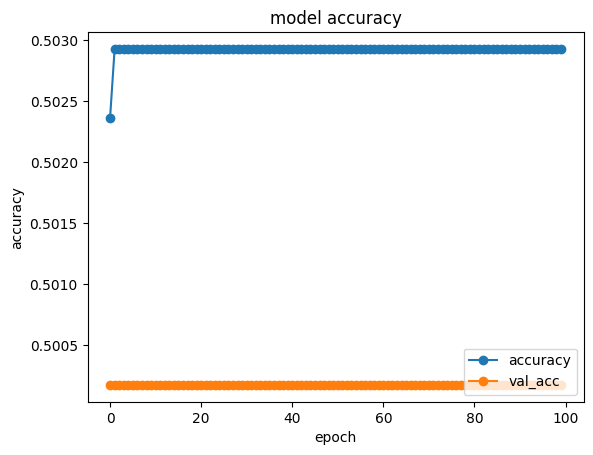

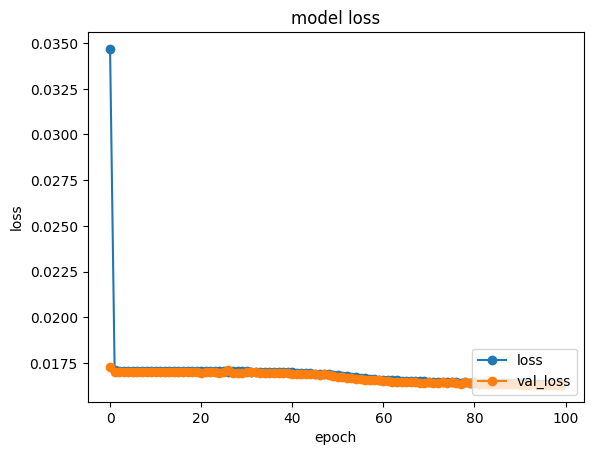

=== History 1 ===


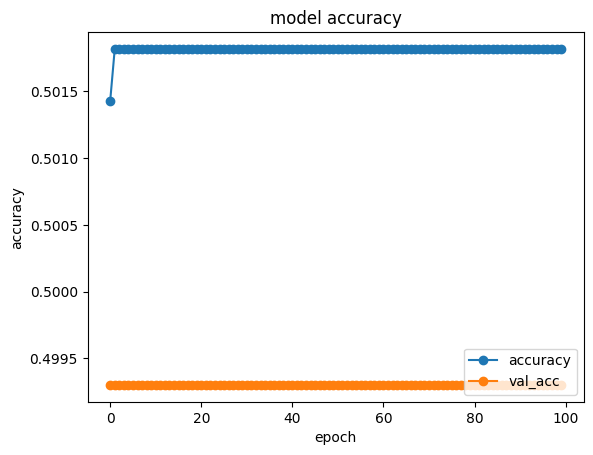

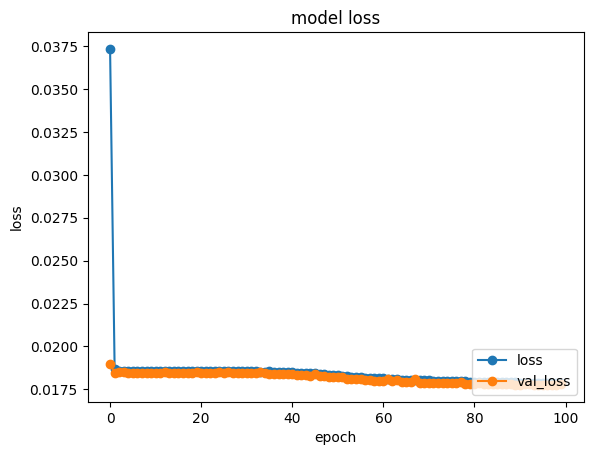

=== History 2 ===


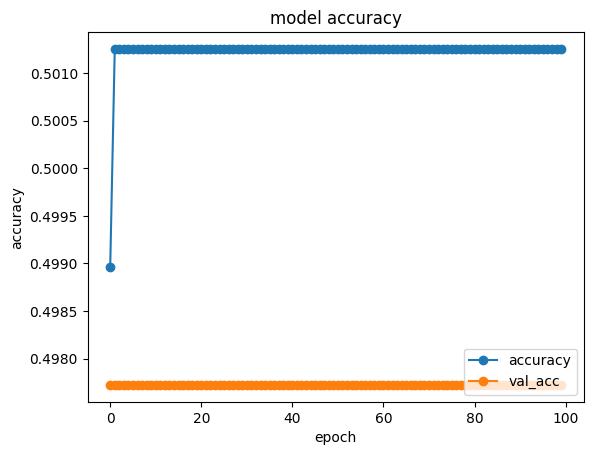

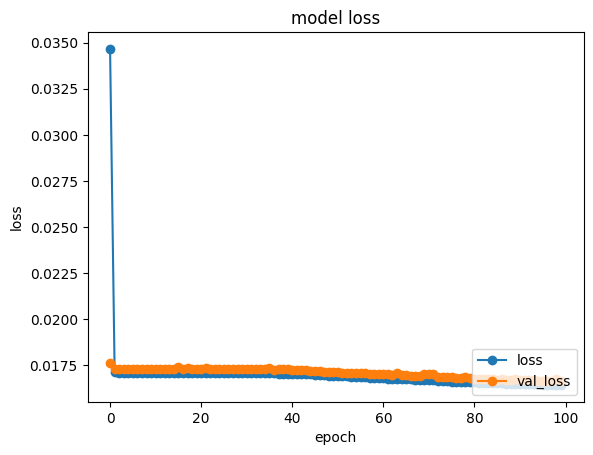

=== History 3 ===


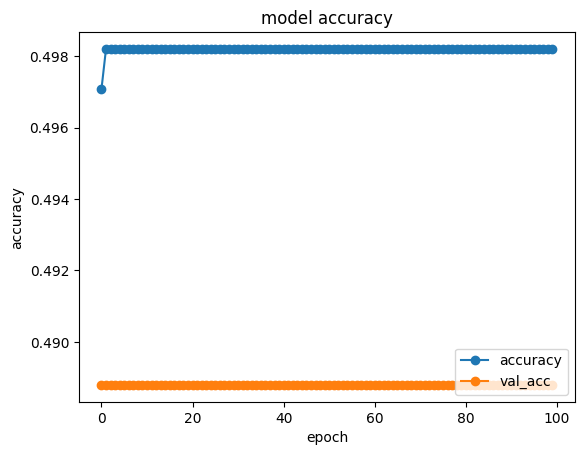

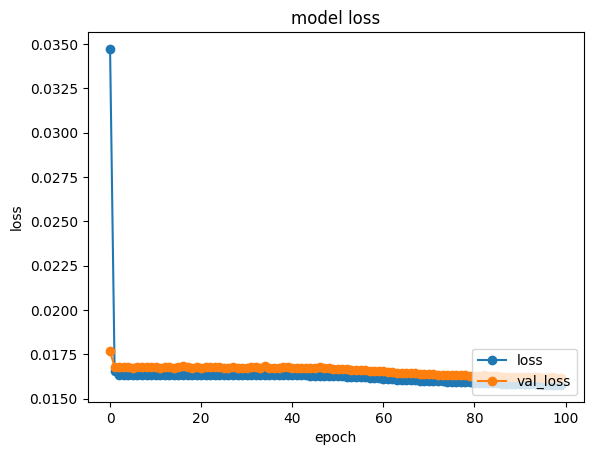

=== History 4 ===


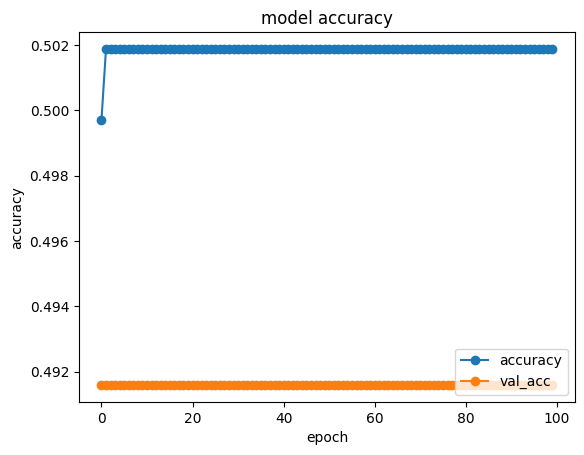

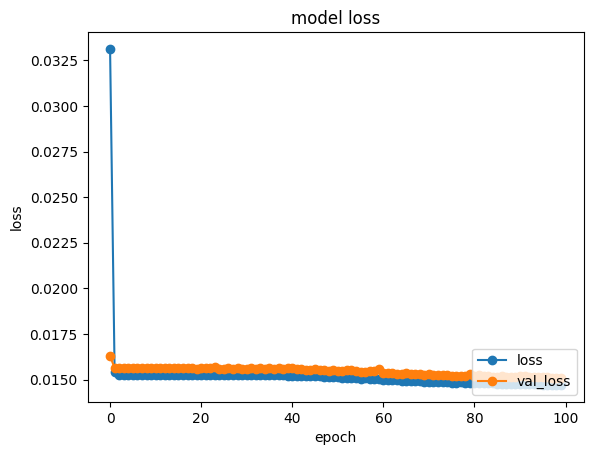

=== History 5 ===


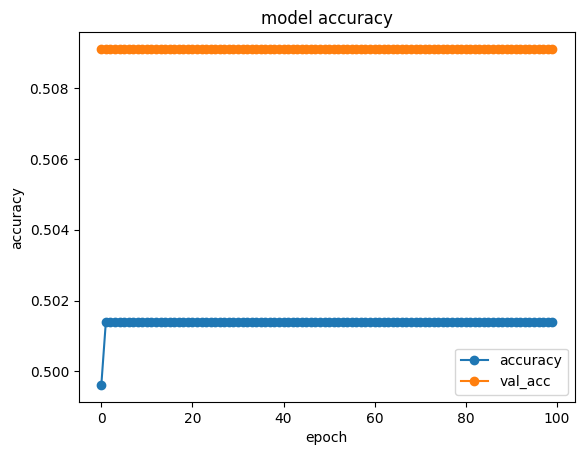

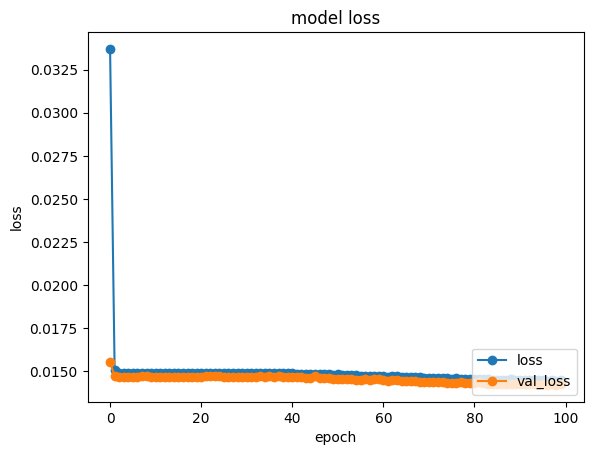

=== History 6 ===


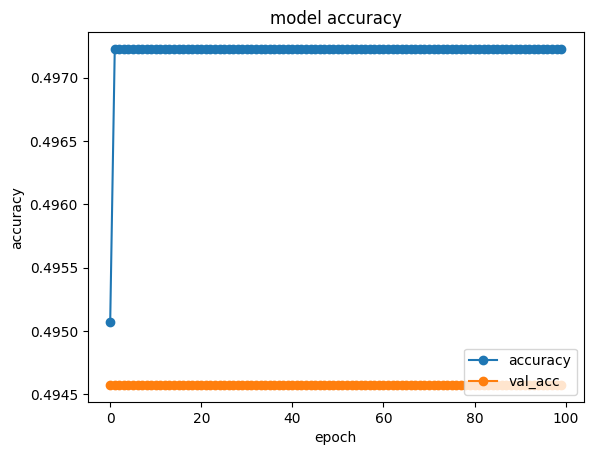

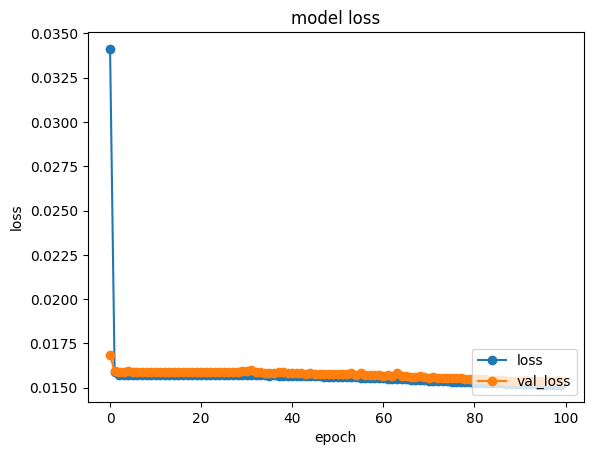

=== History 7 ===


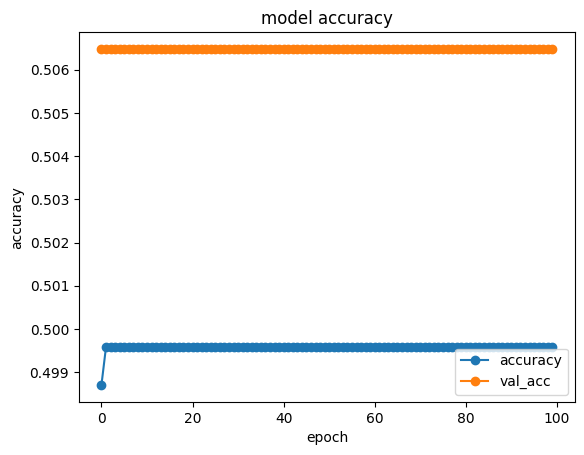

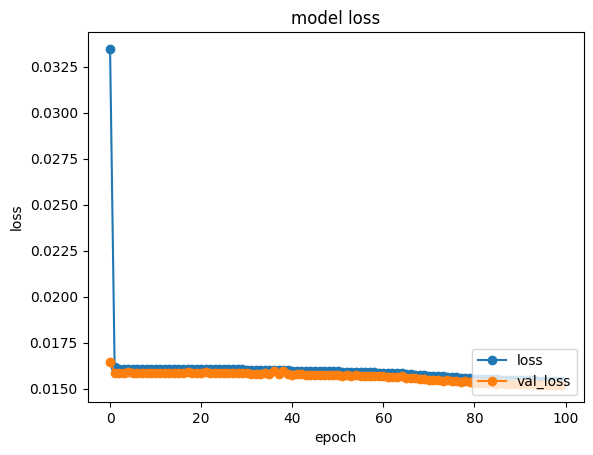

=== History 8 ===


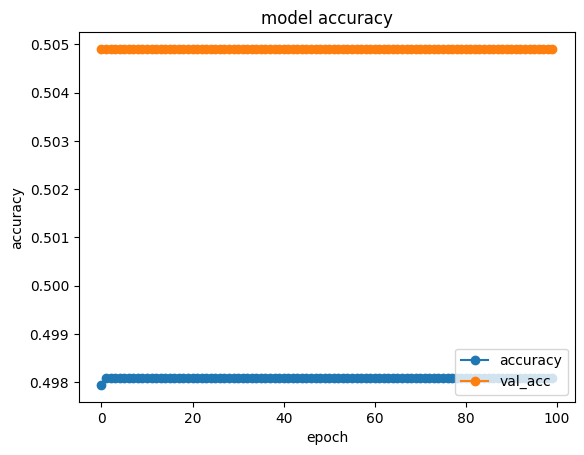

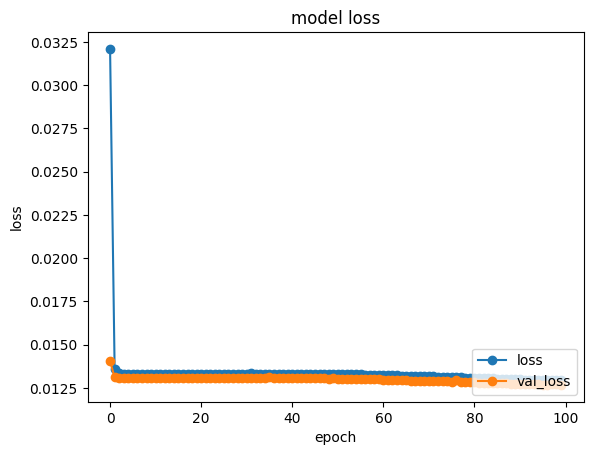

=== History 9 ===


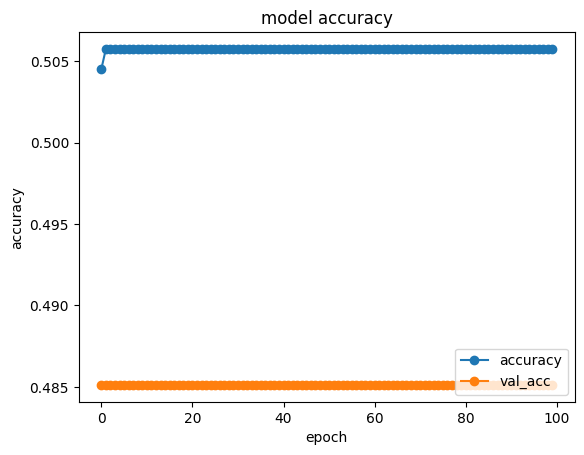

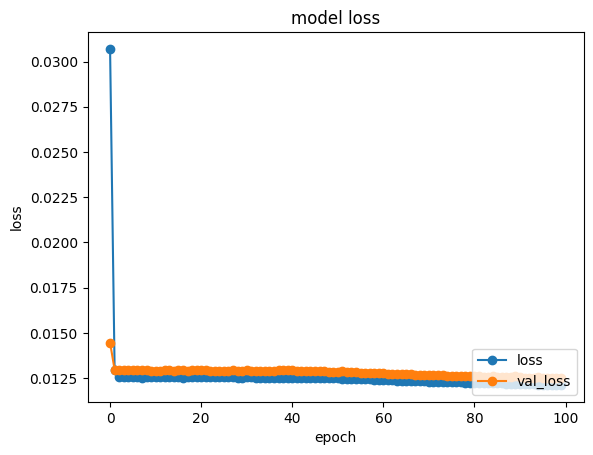

=== History 10 ===


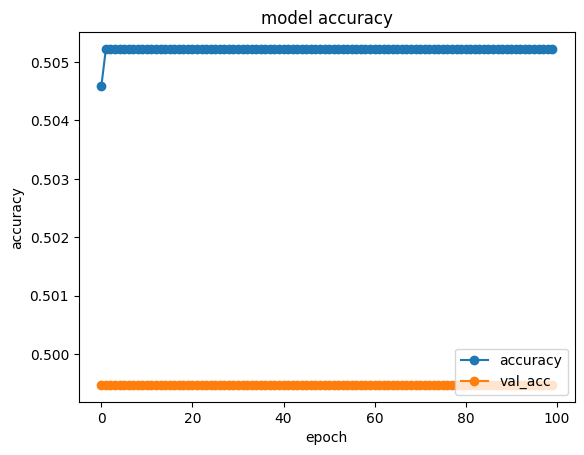

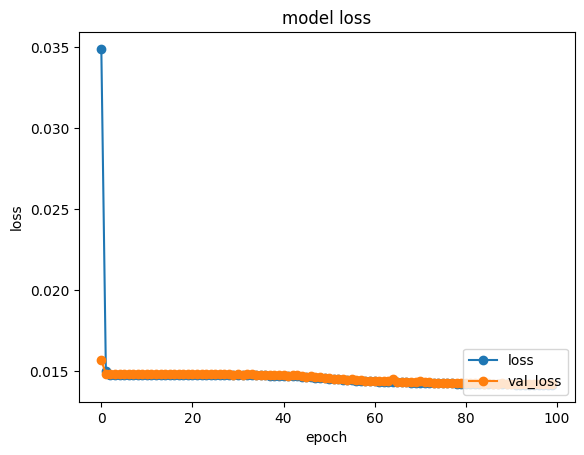

=== History 11 ===


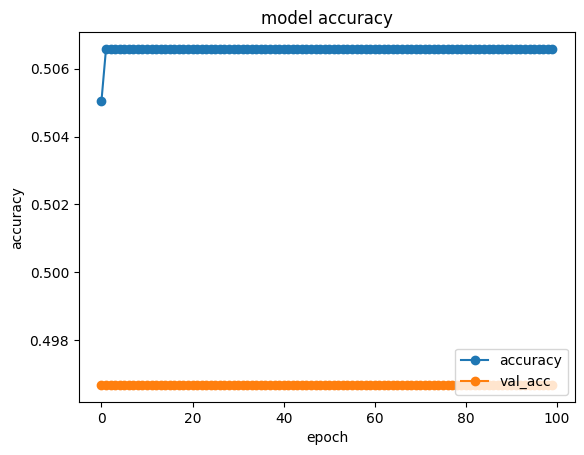

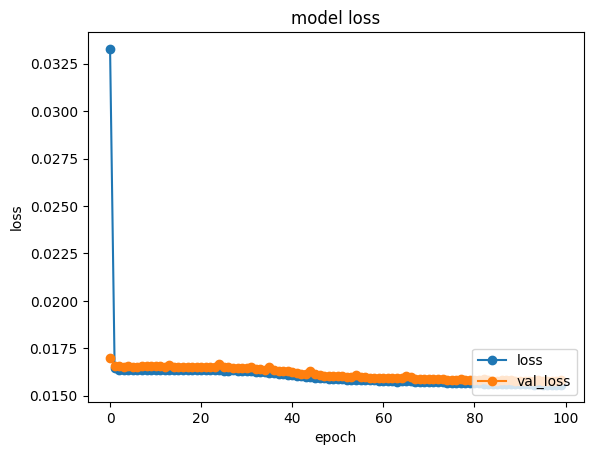

=== History 12 ===


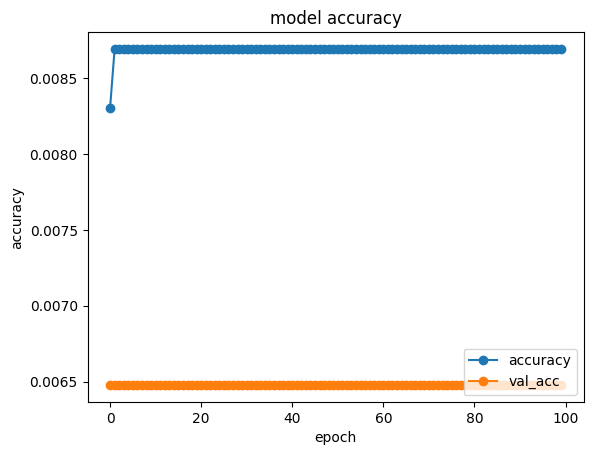

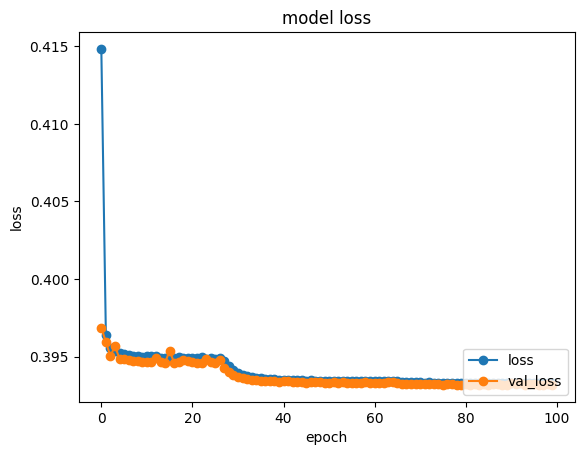

=== History 13 ===


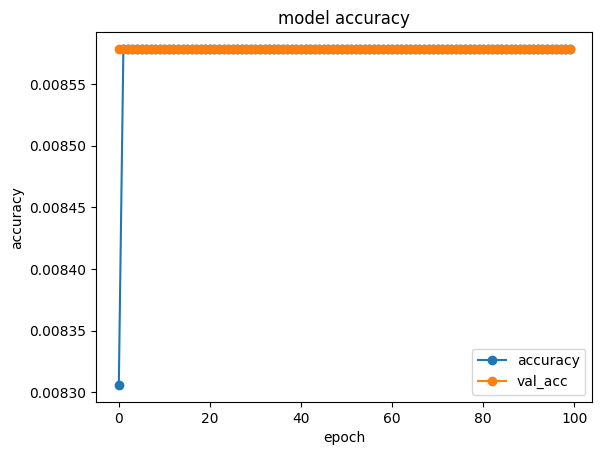

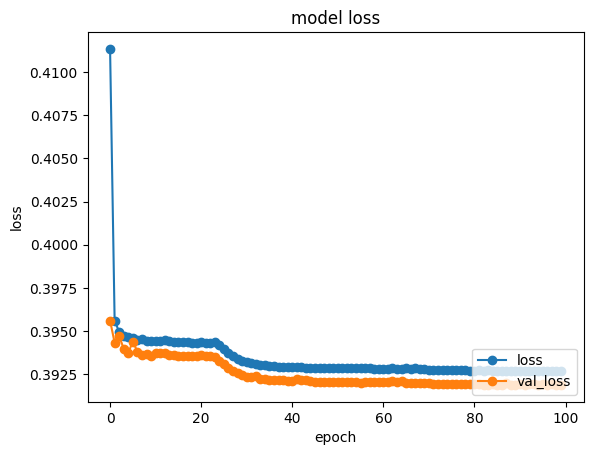

=== History 14 ===


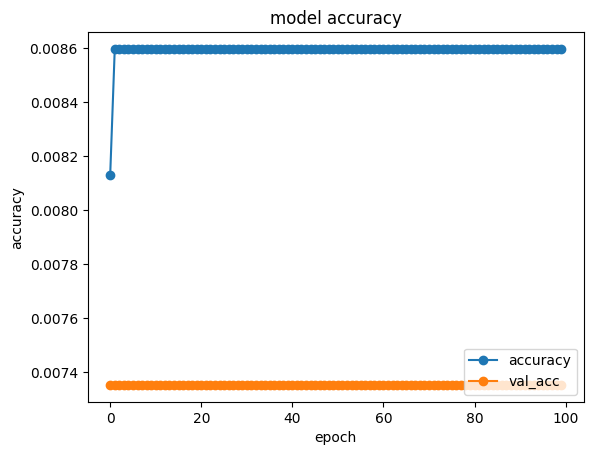

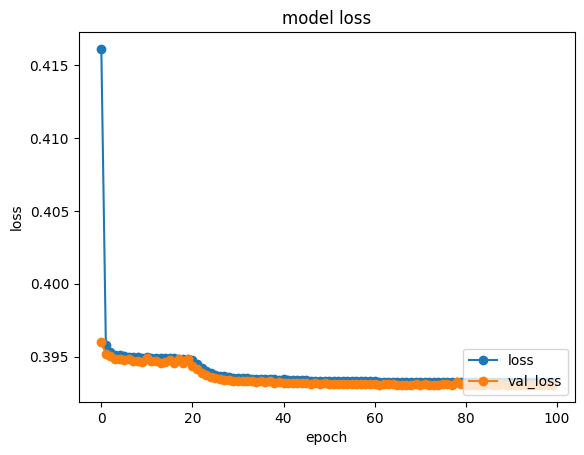

=== History 15 ===


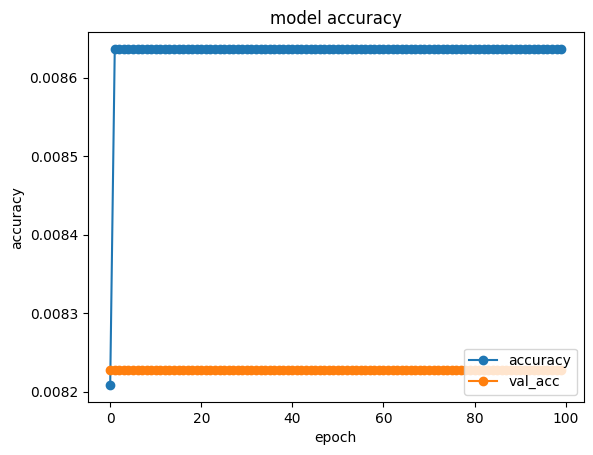

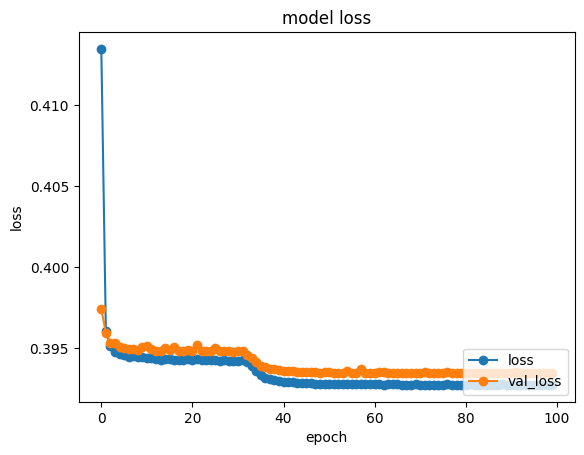

=== History 16 ===


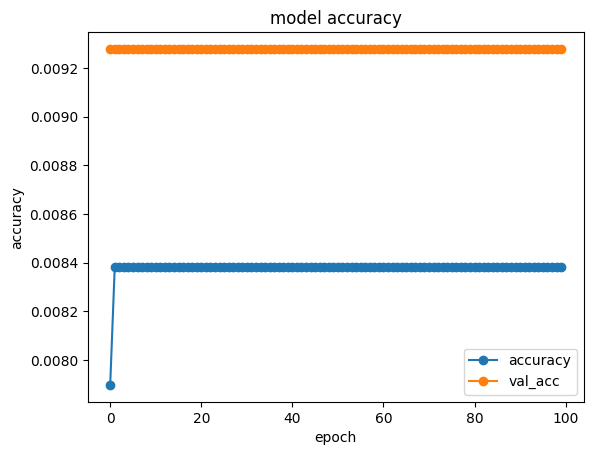

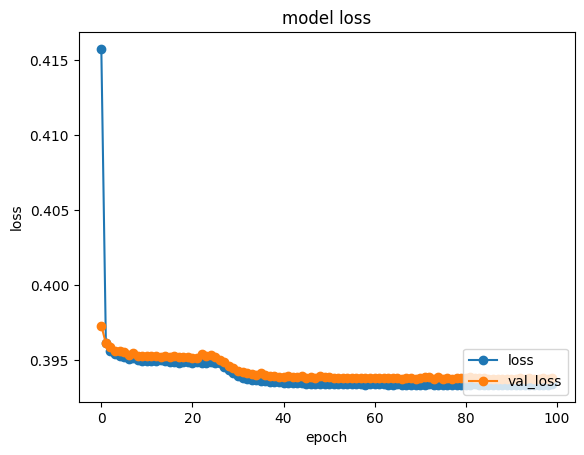

=== History 17 ===


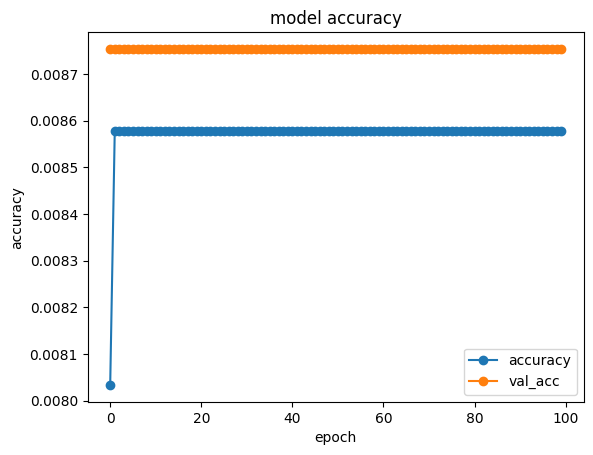

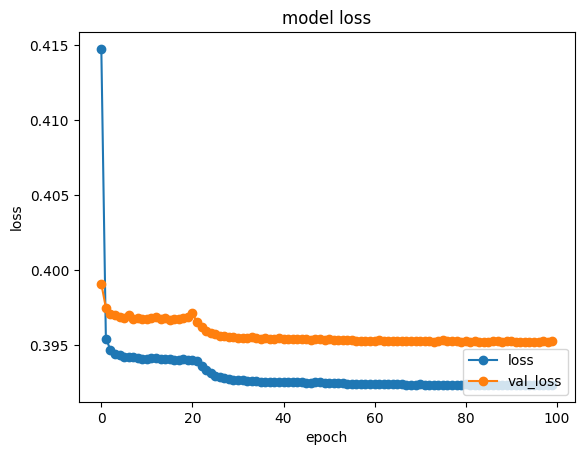

=== History 18 ===


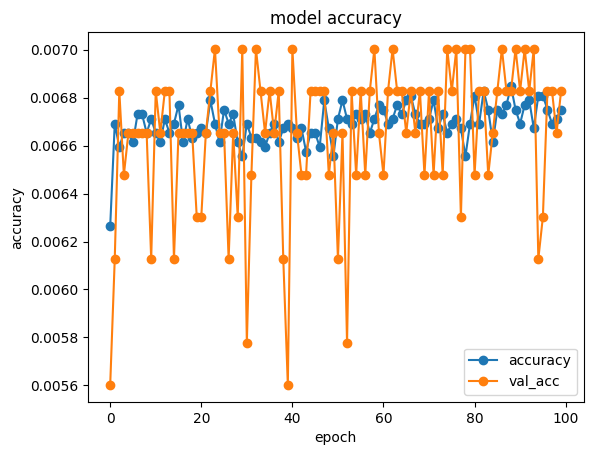

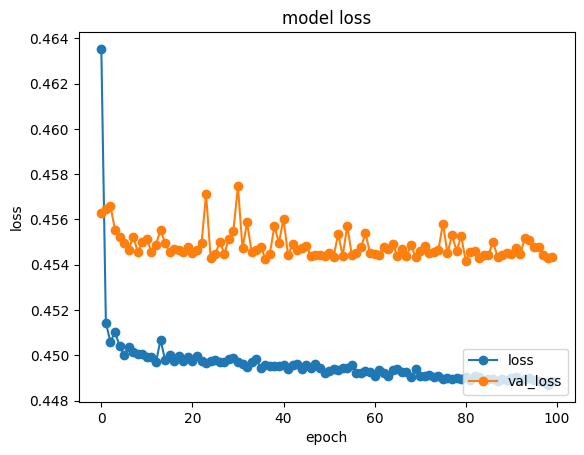

=== History 19 ===


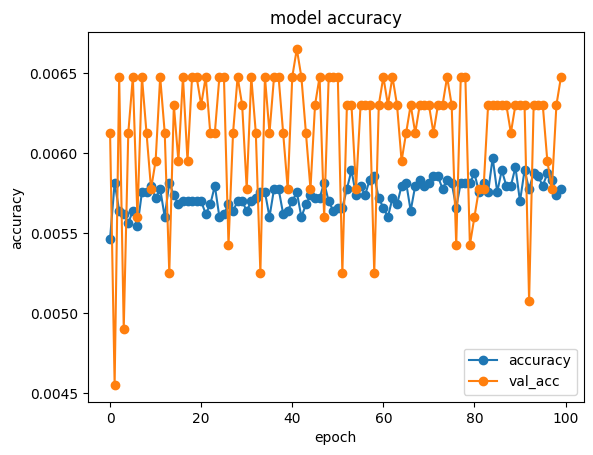

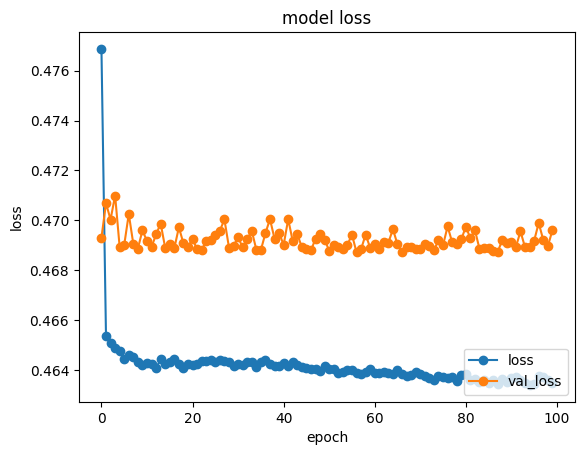

In [15]:
# loss 遷移のプロット

!pip install matplotlib

import matplotlib.pyplot as plt

for i in range(x.shape[2]):
    print("=== History " + str(i) + " ===")
    plot_history(histories[i])

In [16]:
# 楽曲の出力

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from keras.models import load_model
import soundfile as sf

def add_fade(x, fadetime, sr):
    ft_len = int(fadetime*sr)
    r = np.arange(0, ft_len)*np.pi/ft_len
    w_fo = (0.5+0.5*np.cos(r))**0.5
    w_fi = (0.5-0.5*np.cos(r))**0.5
    
    x[0:ft_len]        *= w_fi
    x[clip_size-ft_len::] *= w_fo
    return x

def gen_xfade(x_pre, x_next, fadetime, sr):
    ft_len = int(fadetime*sr)
    if x_pre is None:
        xfade = x_next
    else:
        x_pre_begin = x_pre[:x_pre.shape[0] - ft_len]
        x_pre_end = x_pre[x_pre.shape[0] - ft_len:]
        x_pre_len = clip_size
        x_next_len = clip_size
        x_pre_len -= ft_len
        x_next_len -= ft_len
        xfade = np.concatenate((x_pre_begin, np.concatenate((x_pre_end, np.zeros(x_next_len))) + x_next))
    return xfade

def create_music_consider_weights(fname):
    first_index = np.random.randint(0, len(cqt_chromas))
    predict_index = first_index
    out = None
    
    for i in range(num_clips):
        print("-- generate " + str(i + 1) + " / " + str(num_clips))
        predict_vec = np.zeros((0, ))
        for i in range(x.shape[2]):
            predict = models[i].predict(np.array([cqt_chromas[predict_index, :-1]]))[0]
            predict_vec = np.hstack((predict_vec, predict))
        predict_chroma = predict_vec[:len(predict_vec)-num_divide]
        predict_rhythm = predict_vec[len(predict_vec)-num_divide:]

        index = 0
        similar_index = 0
        score = -1 - rhythm_weight
        chroma_score = 0
        rhythm_score = 0
        for cqt_chroma in cqt_chromas[:, 0]:
            cqt_chroma_chroma = cqt_chroma[:len(cqt_chroma)-num_divide]
            cqt_chroma_rhythm = cqt_chroma[len(cqt_chroma)-num_divide:]
            tmp_chroma_score = cosine_similarity(np.array([predict_chroma]), np.array([cqt_chroma_chroma]))
            tmp_rhythm_score = cosine_similarity(np.array([predict_rhythm]), np.array([cqt_chroma_rhythm]))
            tmp_score = tmp_chroma_score + rhythm_weight * tmp_rhythm_score
            if tmp_score > score:
                score = tmp_score
                similar_index = index
            index += 1

        print("score: " + str(score))
        print("predict_vec: " + str(predict_vec))
        print("cqt_chromas[similar_index]: " + str(cqt_chromas[similar_index, 0]))
        print("similar_index: " + str(similar_index))
        print("--")

        predict_index = similar_index

        tmp = add_fade(clips[predict_index], 0.1, SAMPLING_RATE)
        out = gen_xfade(out, tmp, 0.1, SAMPLING_RATE)
        
    sf.write(fname, out, SAMPLING_RATE, subtype="PCM_16")

rhythm_weight = 1

models = []
for i in range(x.shape[2]):
    model_name = "independent_" + data_name + "_batch" + str(batch_size) + "_e" + str(epochs) + "_" + str(i)
    
    models.append(load_model("../data/models/" + model_name))

file_name = "out_" + "independent_" + data_name + "_batch" + str(batch_size) + "_e" + str(epochs) + "_rw" + str(rhythm_weight).replace('.', '_')
num_clips = 10

for i in range(10):
    fname = "../data/out/" + file_name + "_track" + str(i) + ".wav"
    print("creating " + fname + " ...")
    create_music_consider_weights(fname)

creating ../data/out/out_independent_c81920_s20480_w10240_h640_d8_batch256_e100_rw1_0.wav ...
-- generate 1 / 10
1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 45ms/step
score: [[1.86872824]]
predict_vec: [0.00150171 0.00142208 0.00135333 0.00589247 0.00095149 0.00105386
 0.00061386 0.00148866 0.00164766 0.00166037 0.0004551  0.00318799
 0.00052221 0.00029696 0.00029935 0.00043507 0.00023367 0.00022898
 0.01432186 0.03898474]
cqt_chromas[similar_index]: [0.0000000e+00 2.0959720e-03 3.0039120e-03 7.8125000e-03 0.0000000e+00
 0.0000000e+00 8.6952251e-04 1.2454812e-03 2.0630569e-03 1.5965737e-03
 0.0000000e+00 1.3423318e-03 2.5355257e-05 1.4320016e-05 1.3411045e-05
 6.4158812e-06 6.8044374e-03 4.8328973e-03 2.9081240e-02 4.2849302e-02]
similar_index: 53857
--
-- generate 2 / 10
1/1 [==============================] - 0s 17ms/step
score: [[1.89881701]]
predict_vec: [0.0008277  0.00171992 0.00066245 0.00073896 0.00735186 0.00790657
 0.00306375 0.00146646 0.00152313 0.00116583 0.00094553 0.00097855
 0.00019838 0.00018279 0.0072143  0.00730669 0.02839066 0.04642607
 0.06203587 0.07324374]
cqt_chromas[similar_

1/1 [==============================] - 0s 16ms/step
score: [[1.87992838]]
predict_vec: [2.33303499e-03 1.92443724e-03 1.48120616e-03 9.12476145e-03
 2.65906053e-03 1.09845737e-03 1.04127580e-03 1.43430033e-03
 1.65410584e-03 1.93288445e-03 4.67656471e-04 1.38821849e-03
 2.27120832e-01 1.32559821e-01 3.74909848e-01 3.61867100e-01
 4.34418350e-01 9.98163402e-01 6.39736354e-01 5.87330699e-01]
cqt_chromas[similar_index]: [0.00289396 0.         0.         0.0078125  0.         0.
 0.         0.00144008 0.         0.         0.         0.00108295
 0.11113824 0.11481029 0.15703051 0.21909758 0.12327453 0.5295796
 0.38216454 0.29431817]
similar_index: 49222
--
-- generate 2 / 10
1/1 [==============================] - 0s 17ms/step
score: [[1.86263757]]
predict_vec: [0.00098161 0.00158071 0.00381511 0.00093412 0.00816834 0.00239053
 0.00095894 0.00105047 0.00091625 0.00089525 0.00063675 0.00075158
 0.15583387 0.21725215 0.12646171 0.53794807 0.37920934 0.29674113
 0.33823967 0.34555849]
cqt_chro

1/1 [==============================] - 0s 17ms/step
score: [[1.84039479]]
predict_vec: [0.00143651 0.0046918  0.0021596  0.00145314 0.00118702 0.00130341
 0.0029046  0.00061496 0.00110518 0.00166606 0.00319615 0.00093028
 0.00028505 0.00022278 0.01482772 0.00895368 0.10997031 0.09563825
 0.11906898 0.13651119]
cqt_chromas[similar_index]: [0.00487435 0.0078125  0.         0.00328512 0.         0.00271133
 0.00596851 0.         0.00343321 0.00382434 0.00471777 0.
 0.00205378 0.00109234 0.00061406 0.00586743 0.00783783 0.00579286
 0.01608612 0.01233287]
similar_index: 33172
--
-- generate 2 / 10
1/1 [==============================] - 0s 16ms/step
score: [[1.8551389]]
predict_vec: [0.00180603 0.00089786 0.00120366 0.0030903  0.00305858 0.00197079
 0.00158959 0.00125166 0.00107231 0.00129882 0.001402   0.00051553
 0.00053427 0.00565583 0.00799745 0.00859109 0.01722495 0.01442106
 0.02648712 0.03654385]
cqt_chromas[similar_index]: [0.00633164 0.         0.         0.0061798  0.0078125  0.005

1/1 [==============================] - 0s 16ms/step
score: [[1.87504419]]
predict_vec: [0.00072587 0.000797   0.00370793 0.00115607 0.01032791 0.0010706
 0.00229779 0.00107459 0.00060669 0.00062871 0.00059349 0.00063317
 0.00025655 0.00421765 0.04943029 0.16732514 0.07162665 0.07625408
 0.10927407 0.10308832]
cqt_chromas[similar_index]: [0.0000000e+00 0.0000000e+00 4.4625574e-03 0.0000000e+00 7.8125000e-03
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 2.2819731e-04 2.1101534e-04 1.7866865e-04
 1.9778715e-01 1.6923100e-01 1.0407161e-01 1.1441769e-01 8.2554504e-02]
similar_index: 27556
--
-- generate 2 / 10
1/1 [==============================] - 0s 18ms/step
score: [[1.87020132]]
predict_vec: [0.00186956 0.00174655 0.00057295 0.00100886 0.00330609 0.00300452
 0.00175541 0.00089405 0.00150419 0.00122849 0.00100183 0.00205329
 0.00032513 0.1991363  0.17476276 0.10513658 0.11606184 0.08395272
 0.10755809 0.10257219]
cqt_chromas[similar_i

1/1 [==============================] - 0s 17ms/step
score: [[1.90410025]]
predict_vec: [0.00125744 0.00224046 0.00201828 0.00276096 0.00120113 0.00155679
 0.00469368 0.0028652  0.00198665 0.0033965  0.00195101 0.00437096
 0.12602054 0.24444319 0.22035861 0.17923772 0.19764592 0.11829141
 0.16100806 0.17718534]
cqt_chromas[similar_index]: [0.0000000e+00 4.0819650e-03 3.0536251e-03 7.8125000e-03 0.0000000e+00
 1.9772712e-04 5.4526185e-03 5.1964317e-03 4.2251432e-03 3.1562271e-03
 3.0290892e-03 6.7041060e-03 2.7022991e-01 5.1704037e-01 3.4004045e-01
 2.7000785e-01 2.8806046e-01 2.9800510e-01 3.8359970e-01 3.6818320e-01]
similar_index: 18964
--
-- generate 2 / 10
1/1 [==============================] - 0s 17ms/step
score: [[1.89833351]]
predict_vec: [0.00201188 0.00292053 0.00206946 0.00544336 0.00207633 0.00144192
 0.00137032 0.00221838 0.00146236 0.0012916  0.00133996 0.00079349
 0.34125951 0.2670531  0.29241356 0.29495996 0.38225064 0.36694315
 0.37719136 0.40689909]
cqt_chromas[similar_

1/1 [==============================] - 0s 16ms/step
score: [[1.90974854]]
predict_vec: [1.26895588e-03 5.31893689e-03 3.17595969e-03 1.67401275e-03
 1.22040114e-03 1.76239223e-03 4.29498916e-03 1.33576337e-03
 1.61661545e-03 9.39810066e-04 9.69898014e-04 6.58174744e-04
 2.84747899e-01 2.71751881e-01 6.33853257e-01 6.69564068e-01
 5.86610556e-01 6.65872276e-01 5.50549567e-01 5.01571774e-01]
cqt_chromas[similar_index]: [0.         0.0078125  0.00407146 0.00254197 0.00184492 0.00209941
 0.00520993 0.         0.         0.         0.         0.
 0.09127893 0.04049468 0.09261145 0.08705093 0.09096571 0.14223173
 0.08724913 0.09594718]
similar_index: 4602
--
-- generate 3 / 10
1/1 [==============================] - 0s 19ms/step
score: [[1.88758108]]
predict_vec: [0.00627742 0.00277203 0.00117471 0.00103192 0.00190908 0.00248748
 0.0014976  0.00112556 0.00086787 0.00279105 0.00186829 0.00159433
 0.09033138 0.0841861  0.09212493 0.14063114 0.0888276  0.10011109
 0.11792639 0.13288741]
cqt_chro

1/1 [==============================] - 0s 16ms/step
score: [[1.89666548]]
predict_vec: [3.75334313e-03 6.36068464e-04 2.14369176e-03 1.43174280e-03
 3.08106490e-03 2.25699763e-03 1.74778013e-03 2.01476389e-03
 3.89073836e-03 2.39682896e-03 6.30951137e-04 5.73442259e-04
 9.97700393e-01 5.06200075e-01 5.62665761e-01 4.09127742e-01
 3.86281937e-01 4.88062084e-01 4.76800352e-01 5.18782914e-01]
cqt_chromas[similar_index]: [0.0078125  0.         0.00352608 0.00512512 0.00618107 0.0050544
 0.         0.00526252 0.00556889 0.00423884 0.         0.
 0.54249376 0.67006177 0.5355928  0.42610997 0.36674023 0.36143696
 0.39490914 0.5016208 ]
similar_index: 45882
--
-- generate 3 / 10
1/1 [==============================] - 0s 19ms/step
score: [[1.90504879]]
predict_vec: [3.63439624e-03 3.47360759e-03 1.82010164e-03 2.75988923e-03
 5.29823964e-03 4.13833605e-03 2.20122817e-03 2.47746869e-03
 2.61773448e-03 1.48861133e-03 1.85032201e-03 5.15340827e-04
 5.38135648e-01 4.23496038e-01 3.70313555e-01 3.56

1/1 [==============================] - 0s 19ms/step
score: [[1.89371293]]
predict_vec: [0.00082605 0.00335593 0.00379373 0.00130028 0.00080452 0.00143338
 0.00268819 0.00098938 0.00179255 0.00341109 0.00075414 0.00077263
 0.04285103 0.02275833 0.03941887 0.02225775 0.03920226 0.03044773
 0.04841427 0.07085197]
cqt_chromas[similar_index]: [0.00393841 0.00666094 0.0078125  0.005523   0.00495816 0.0034464
 0.00608705 0.00375799 0.00264613 0.00389344 0.         0.
 0.40118584 0.23535882 0.5232029  0.25964326 0.31809077 0.42423946
 0.50084305 0.57515895]
similar_index: 37848
--
-- generate 8 / 10
1/1 [==============================] - 0s 20ms/step
score: [[1.89534714]]
predict_vec: [0.00106511 0.00193432 0.00215763 0.0045327  0.00578175 0.00266248
 0.00082123 0.00299664 0.00136056 0.00106589 0.00093422 0.0010332
 0.52603048 0.256531   0.32243887 0.42215672 0.50964397 0.58258003
 0.52204078 0.51109678]
cqt_chromas[similar_index]: [1.7030000e-03 1.7279593e-03 0.0000000e+00 7.1977656e-03 7.812

1/1 [==============================] - 0s 19ms/step
score: [[1.94431179]]
predict_vec: [3.43121774e-03 1.13810664e-02 1.22557220e-03 1.24498387e-03
 1.75785366e-03 3.41677084e-03 1.71235763e-03 1.10959820e-03
 2.27488228e-03 1.74675207e-03 1.84539682e-03 9.06910514e-04
 9.97721493e-01 9.96261299e-01 9.99250233e-01 8.17955434e-01
 9.97577250e-01 9.98200297e-01 7.45081186e-01 7.30304658e-01]
cqt_chromas[similar_index]: [0.00308086 0.0078125  0.         0.         0.         0.00326952
 0.00166303 0.00092505 0.00294598 0.00264748 0.00169192 0.00179957
 0.13820931 0.1501657  0.09945738 0.13660297 0.12700975 0.12989724
 0.10565277 0.08840677]
similar_index: 41632
--
-- generate 8 / 10
1/1 [==============================] - 0s 19ms/step
score: [[1.92685624]]
predict_vec: [0.00102326 0.00631061 0.0019888  0.00352855 0.00263714 0.00479638
 0.00099714 0.00071981 0.00053448 0.00131573 0.00168639 0.003894
 0.09845813 0.13560915 0.13002415 0.13035513 0.10876209 0.09124028
 0.12288136 0.14253308]
c

1/1 [==============================] - 0s 21ms/step
score: [[1.92685624]]
predict_vec: [0.00102326 0.00631061 0.0019888  0.00352855 0.00263714 0.00479638
 0.00099714 0.00071981 0.00053448 0.00131573 0.00168639 0.003894
 0.09845813 0.13560915 0.13002415 0.13035513 0.10876209 0.09124028
 0.12288136 0.14253308]
cqt_chromas[similar_index]: [0.         0.0078125  0.00298365 0.00546893 0.00428753 0.00724256
 0.         0.00336285 0.         0.         0.         0.00306914
 0.17705275 0.23096754 0.23925377 0.23370355 0.26110703 0.15234956
 0.26593208 0.23108488]
similar_index: 20904
--
-- generate 8 / 10
1/1 [==============================] - 0s 21ms/step
score: [[1.90176156]]
predict_vec: [0.00238283 0.00494982 0.00116953 0.00143539 0.00201874 0.00458024
 0.00148349 0.00064784 0.00553575 0.0046072  0.00150944 0.0020479
 0.23925829 0.23150164 0.26448497 0.14994808 0.26849177 0.23427337
 0.25979781 0.29444158]
cqt_chromas[similar_index]: [0.00347918 0.0078125  0.         0.         0.        

1/1 [==============================] - 0s 18ms/step
score: [[1.93183584]]
predict_vec: [4.69323539e-04 3.84823163e-03 1.87565072e-03 3.45069682e-03
 1.09193299e-03 2.39553186e-03 2.52213166e-03 3.29653360e-03
 3.82348266e-03 1.82213599e-03 6.86869072e-03 6.28958456e-04
 6.32057726e-01 7.89983928e-01 6.77592874e-01 4.99512911e-01
 5.77799201e-01 7.33587980e-01 6.11929357e-01 6.16140544e-01]
cqt_chromas[similar_index]: [0.         0.0035043  0.         0.00353548 0.         0.00165641
 0.00309874 0.00346304 0.00240461 0.00280962 0.0078125  0.
 0.50712585 0.519281   0.5428535  0.27338013 0.3191243  0.5315357
 0.4596135  0.73485833]
similar_index: 41437
--
-- generate 8 / 10
1/1 [==============================] - 0s 21ms/step
score: [[1.94059063]]
predict_vec: [7.21412059e-03 3.90123809e-03 1.49633980e-03 9.12312942e-04
 8.34705657e-04 7.90697697e-04 1.50929065e-03 1.28871202e-03
 1.33878121e-03 7.15506845e-04 4.73355933e-04 7.70951109e-03
 5.45609474e-01 2.69754231e-01 3.25358361e-01 5.38